# Fake News Classification

## Introduction

The project uses the Fake and Real News Dataset downloaded from the Kaggle (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). The dataset includes two csv files  - one contains texts of news articles labeled as 'fake' (23481 articles), another contains texts of news articles labeled as 'true' (21417 articles). Tables in the files contain information about title, text, subject and date when the article was uploaded. 

The purpose of the project is to train machine learning and deep learning models which could be used in predicting whether a particular article is fake or not.

The project consists of two parts: 1) the exploratory analysis of the dataset news articles and 2) building, training, fine-tuning and evaluating classifiers able to predict whether a particular article is fake or not.

### Importing libraries

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib and seaborn will be used for data visualization. As the projects works with text data, for the exploratory analysis such NLP libraries as nltk, gensim, worldcloud, textblob will be used.  Various modules of the torch library as well as pytorch-lightning will be used for data loading, importing pretrained models, training, summarizing and fine-tuning. Sklearn modules will be used for vectorizing article texts, presenting confusion matrix and classification report, building machine learning pipelines, using classifiers for machine learning, etc. Shap library will be used for identifying the most important features. Lime library will be used for interpretability. 


## I. Exploratory data analysis

In [201]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import optim
from torchsummary import summary
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import TensorDataset
import torchmetrics

import pytorch_lightning as pl

import transformers
from transformers import (
    AutoTokenizer,
    DistilBertTokenizer,
    DistilBertForMaskedLM,
    DistilBertModel,
    DistilBertForSequenceClassification,
    DistilBertConfig,
    pipeline,
)

import re
import pickle

from tokenizers import trainers, models, Tokenizer, pre_tokenizers

import optuna

import sklearn
import sklearn.ensemble
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif , mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, \
recall_score, confusion_matrix as cfm, make_scorer, classification_report, mean_absolute_error,\
mean_squared_error,mean_squared_log_error,r2_score, roc_auc_score, average_precision_score, log_loss,\
ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xg

from yellowbrick.classifier import confusion_matrix as ycfm, ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

import joblib
from joblib import load
import shap
import lime
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular

import nltk
from nltk.corpus import stopwords

import gensim
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

from collections import defaultdict
from collections import Counter
from typing import Any, List, Tuple, Union, Dict, Generator

from fake_news_dataset import FakeNewsDataset

import warnings
warnings.filterwarnings("ignore")


<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

The csv files with the fake and true news articles are imported into pandas dataframes named as 'fakenews' and 'truenews'.

In [3]:
fakenews = pd.read_csv("data/Fake.csv")

<IPython.core.display.Javascript object>

In [4]:
truenews = pd.read_csv("data/True.csv")

<IPython.core.display.Javascript object>

The basic information of the dataframes can be seen below.

In [5]:
fakenews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


<IPython.core.display.Javascript object>

In [6]:
truenews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


<IPython.core.display.Javascript object>

It can be concluded that the numbers of fake and news articles in the dataframes are relatively balanced. 

Next, the rows of both dataframes are concatenated in to a single dataframe named 'news', assigning the value 1 to  rows from the fakenews dataframe and the value 0 to rows from the truenews dataframe. Separate dataframes as well as the concatenated dataframe will be used for the further exploratory analysis.

In [7]:
fakenews = fakenews.assign(news_status=1)
truenews = truenews.assign(news_status=0)


<IPython.core.display.Javascript object>

#### Finding and removing duplicates

Duplicates in the dateframes were identified and removed. 

In [8]:
duplicates_fakenews = fakenews.duplicated(keep=False)
duplicates_truenews = truenews.duplicated(keep=False)

<IPython.core.display.Javascript object>

In [9]:
print(f"Duplicates in the fakenews dataframe: {len(fakenews[duplicates_fakenews])}")
print(f"Duplicates in the truenews dataframe: {len(truenews[duplicates_truenews])}")

Duplicates in the fakenews dataframe: 6
Duplicates in the truenews dataframe: 399


<IPython.core.display.Javascript object>

In [10]:
fakenews = fakenews.drop_duplicates(keep="first")
truenews = truenews.drop_duplicates(keep="first")

<IPython.core.display.Javascript object>

#### Merging datasets

In [11]:
news = pd.concat([fakenews, truenews], axis=0)

<IPython.core.display.Javascript object>

In [12]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        44689 non-null  object
 1   text         44689 non-null  object
 2   subject      44689 non-null  object
 3   date         44689 non-null  object
 4   news_status  44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


<IPython.core.display.Javascript object>

#### Checking for duplicates in the merged dataset

The merged dataframe was checked for duplicates and it was found that there were no remaining duplicates in the dataset.

In [13]:
duplicates_news = news.duplicated(keep=False)

print(f"Duplicates in the news dataframe: {len(fakenews[duplicates_news])}")


Duplicates in the news dataframe: 0


<IPython.core.display.Javascript object>

### Checking for missing values

The dataframe was checked for missing values; it can be observed that there are no missing values in the dataset. 

In [14]:
news.isna().sum()

title          0
text           0
subject        0
date           0
news_status    0
dtype: int64

<IPython.core.display.Javascript object>

## Examing differences between fake news and true news

In order to better understand, what characteristics of articles labeled as 'fake' and 'true' are, distributions of fake and true news articles by subjects were analysed, also several analytic steps common in the NLP exploratory data analysis were undertaken, such as counting characters and words, identifying most common stopwords and non-stopwords, counting ngrams, identifying topics and most common words in the topics by the LDA, identifying sentiments.


### Analysing distributions of articles by subject

It can be observed (see below) that news articles labeled as true belong to the subject of politics and world news while 38.5 percent of articles labeled as fake get the general 'news' category. 

In [18]:
(fakenews["subject"].value_counts() / len(fakenews) * 100).round(2)

subject
News               38.55
politics           29.13
left-news          18.99
Government News     6.69
US_News             3.34
Middle-east         3.31
Name: count, dtype: float64

<IPython.core.display.Javascript object>

In [19]:
(truenews["subject"].value_counts() / len(truenews) * 100).round(2)

subject
politicsNews    52.9
worldnews       47.1
Name: count, dtype: float64

<IPython.core.display.Javascript object>

### Counting characters and words

The next step of the exploratory analysis of data is to count characters and words in comment text. For that purpose, the functions to plot the distributions of lenghts of characters and words are created and run on both fakenews and truenews dataframes. 

In [20]:

def plot_counts_hist(df: np.ndarray, bins: int, ax: plt.Axes, title: str) -> None:
    """
    Plot a histogram with counts on top of the bars.

    Parameters:
        df (np.ndarray): Data to be plotted.
        bins (int): Number of bins for the histogram.
        ax (plt.Axes): Matplotlib axis to plot on.
        title (str): Title for the plot.

    Returns:
        None
    """
    counts, bins, patches = ax.hist(
        df,
        color="green",
        bins=bins,
        edgecolor="black",
        alpha=0.7,
    )
    
    for count, x, patch in zip(counts, bins, patches):
        x_center = x + (bins[1] - bins[0]) / 2
        ax.text(x_center, count, str(int(count)), ha="center", va="bottom", fontsize=12)
        ax.text(
            x_center, count + 5, str(int(count)), ha="center", va="bottom", fontsize=12
        )
    
    ax.set_xlabel("")
    ax.set_ylabel("Frequency")
    ax.set_title(title)


<IPython.core.display.Javascript object>

#### Counts of characters in news articles and titles:

The characters were counted both for the titles and text of the articles.

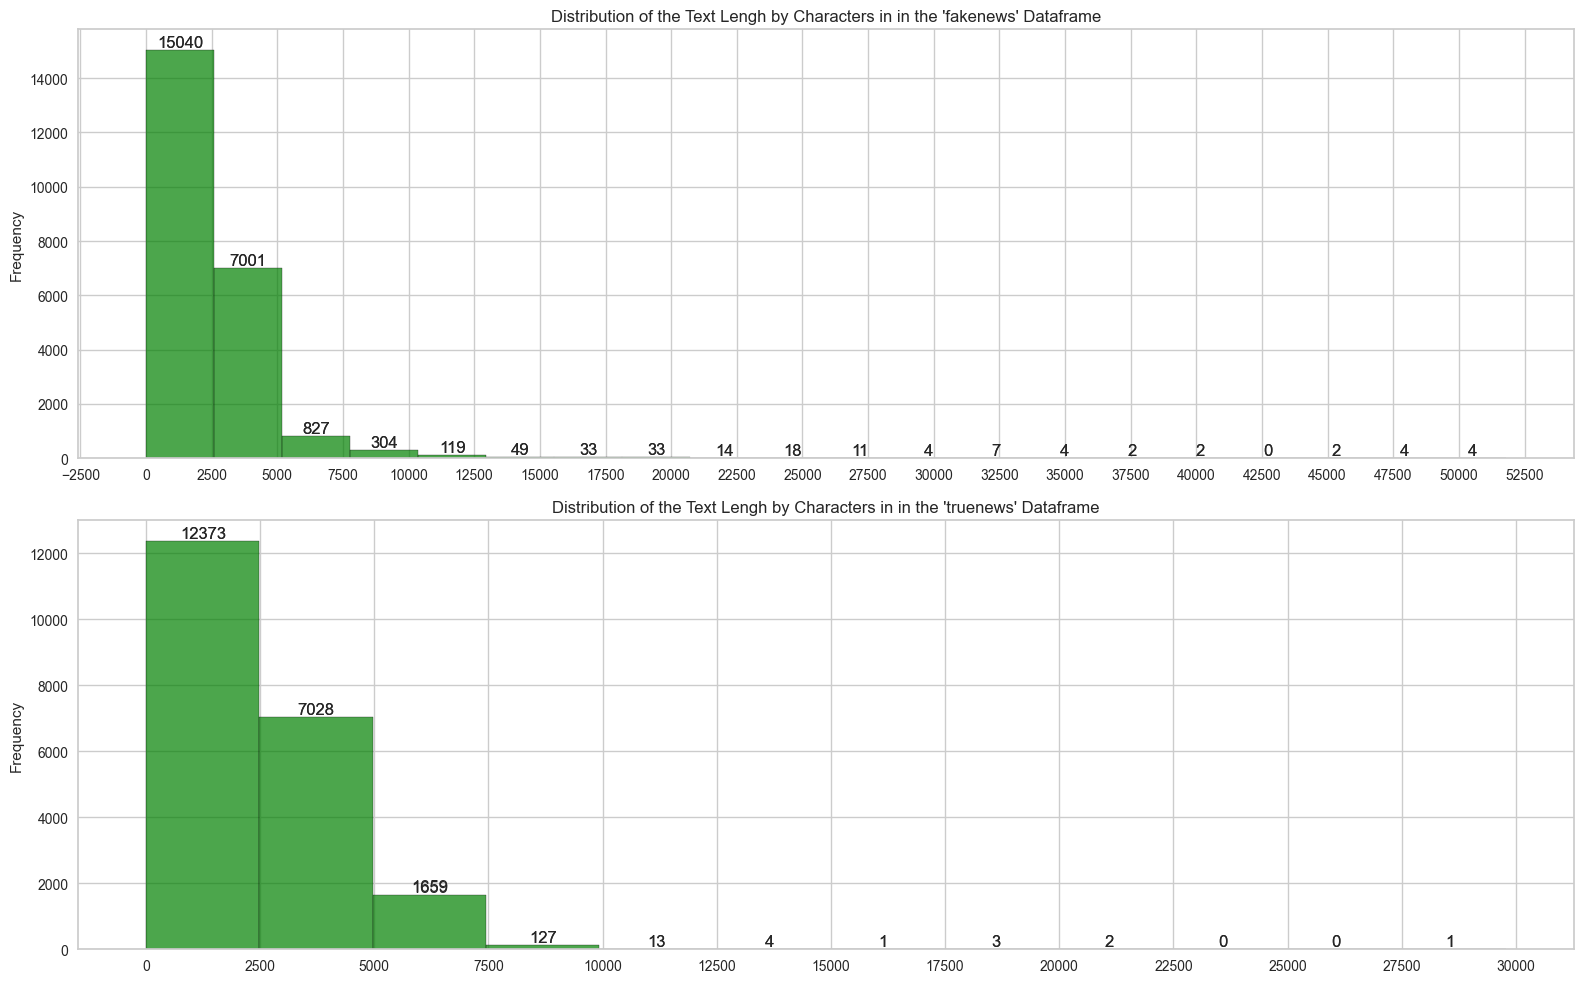

<IPython.core.display.Javascript object>

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_counts_hist(
    fakenews["text"].str.len(),
    bins=20,
    ax=ax1,
    title="Distribution of the Text Lengh by Characters in in the 'fakenews' Dataframe",
)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=25))

plot_counts_hist(
    truenews["text"].str.len(),
    bins=12,
    ax=ax2,
    title="Distribution of the Text Lengh by Characters in in the 'truenews' Dataframe",
)
ax2.xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.tight_layout()

plt.show()

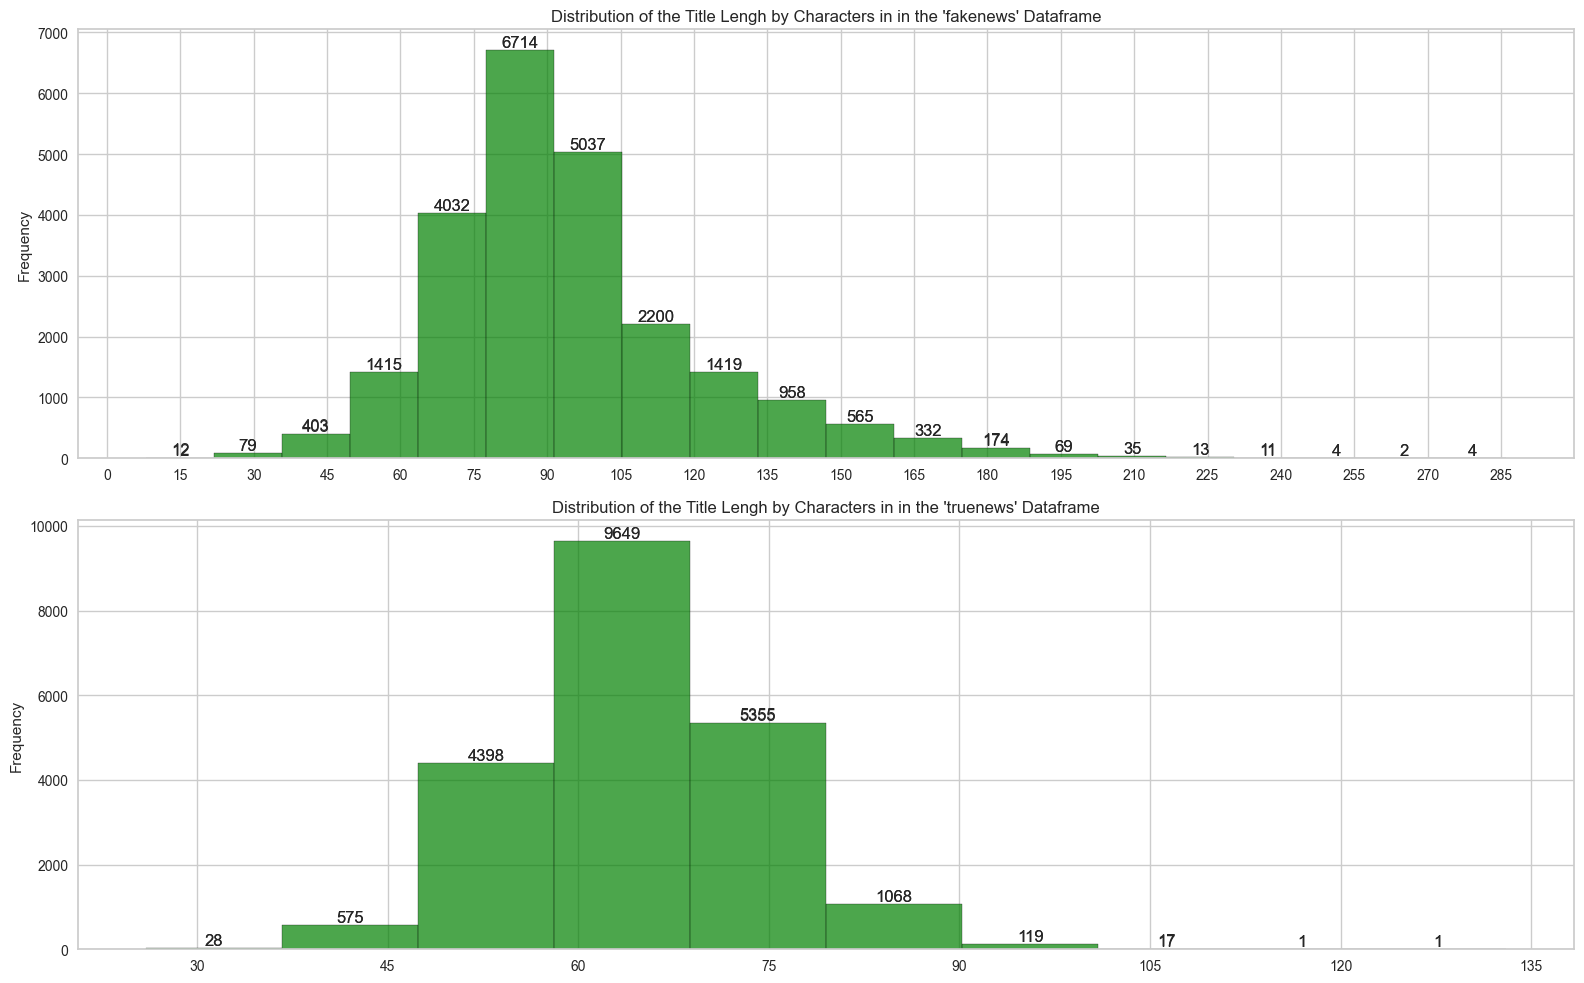

<IPython.core.display.Javascript object>

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_counts_hist(
    fakenews["title"].str.len(),
    bins=20,
    ax=ax1,
    title="Distribution of the Title Lengh by Characters in in the 'fakenews' Dataframe",
)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=25))

plot_counts_hist(
    truenews["title"].str.len(),
    bins=10,
    ax=ax2,
    title="Distribution of the Title Lengh by Characters in in the 'truenews' Dataframe",
)
ax2.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.tight_layout()

plt.show()

In [23]:
print(fakenews["text"].str.len().describe().round(2))
print("")
print(truenews["text"].str.len().describe().round(2))
print("")
print(fakenews["title"].str.len().describe().round(2))
print("")
print(truenews["title"].str.len().describe().round(2))

count    23478.00
mean      2547.56
std       2533.00
min          1.00
25%       1433.00
50%       2166.00
75%       3032.00
max      51794.00
Name: text, dtype: float64

count    21211.00
mean      2378.04
std       1684.47
min          1.00
25%        903.50
50%       2216.00
75%       3226.50
max      29781.00
Name: text, dtype: float64

count    23478.00
mean        94.19
std         27.18
min          8.00
25%         77.00
50%         90.00
75%        105.00
max        286.00
Name: title, dtype: float64

count    21211.00
mean        64.66
std          9.16
min         26.00
25%         59.00
50%         64.00
75%         70.00
max        133.00
Name: title, dtype: float64


<IPython.core.display.Javascript object>

It can be observed that more articles in the fakenews dataframe comparing to the articles in the truenews dataframe have less than 2500 characters in their text. Also, more 'true' articles have less 75 characters (while the majority of 'fake' articles have characters in the range (75 - 90)) in their titles. At the same, the outliers in the fakenews dataframe are more extreme - there are some articles with much larger number of characters than the articles with the largest number of outliers in the truenews dataframe.

#### Counts of words in news articles and titles: 

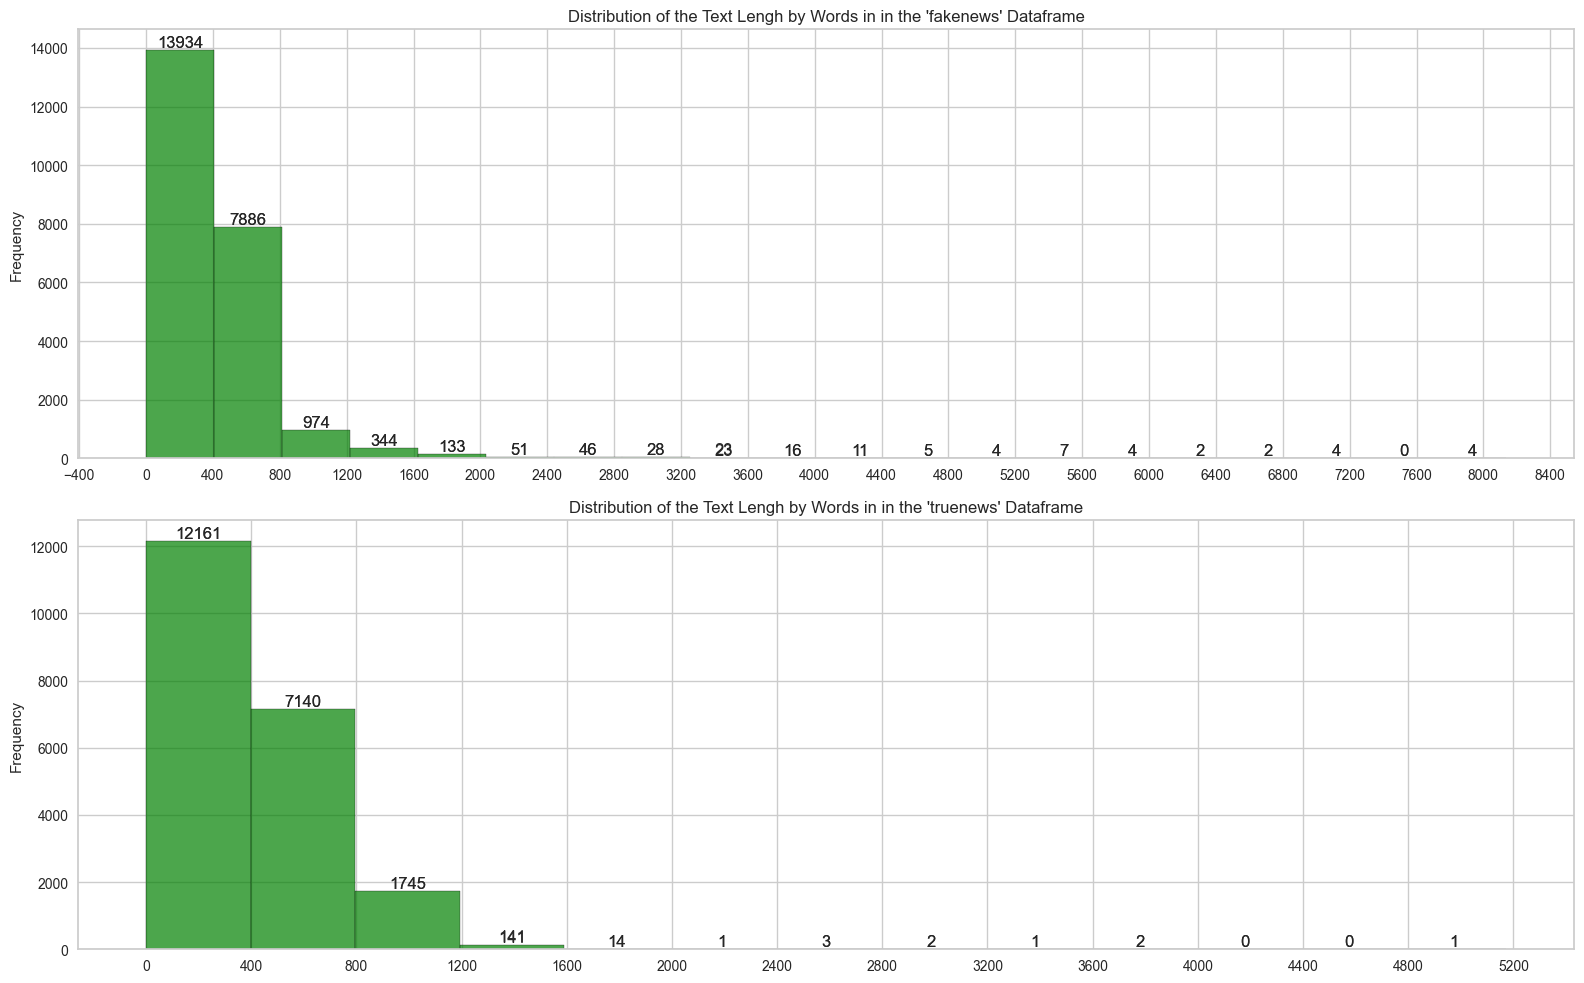

<IPython.core.display.Javascript object>

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_counts_hist(
    fakenews["text"].str.split().apply(len),
    bins=20,
    ax=ax1,
    title="Distribution of the Text Lengh by Words in in the 'fakenews' Dataframe",
)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=25))
plot_counts_hist(
    truenews["text"].str.split().apply(len),
    bins=13,
    ax=ax2,
    title="Distribution of the Text Lengh by Words in in the 'truenews' Dataframe",
)
ax2.xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.tight_layout()

plt.show()

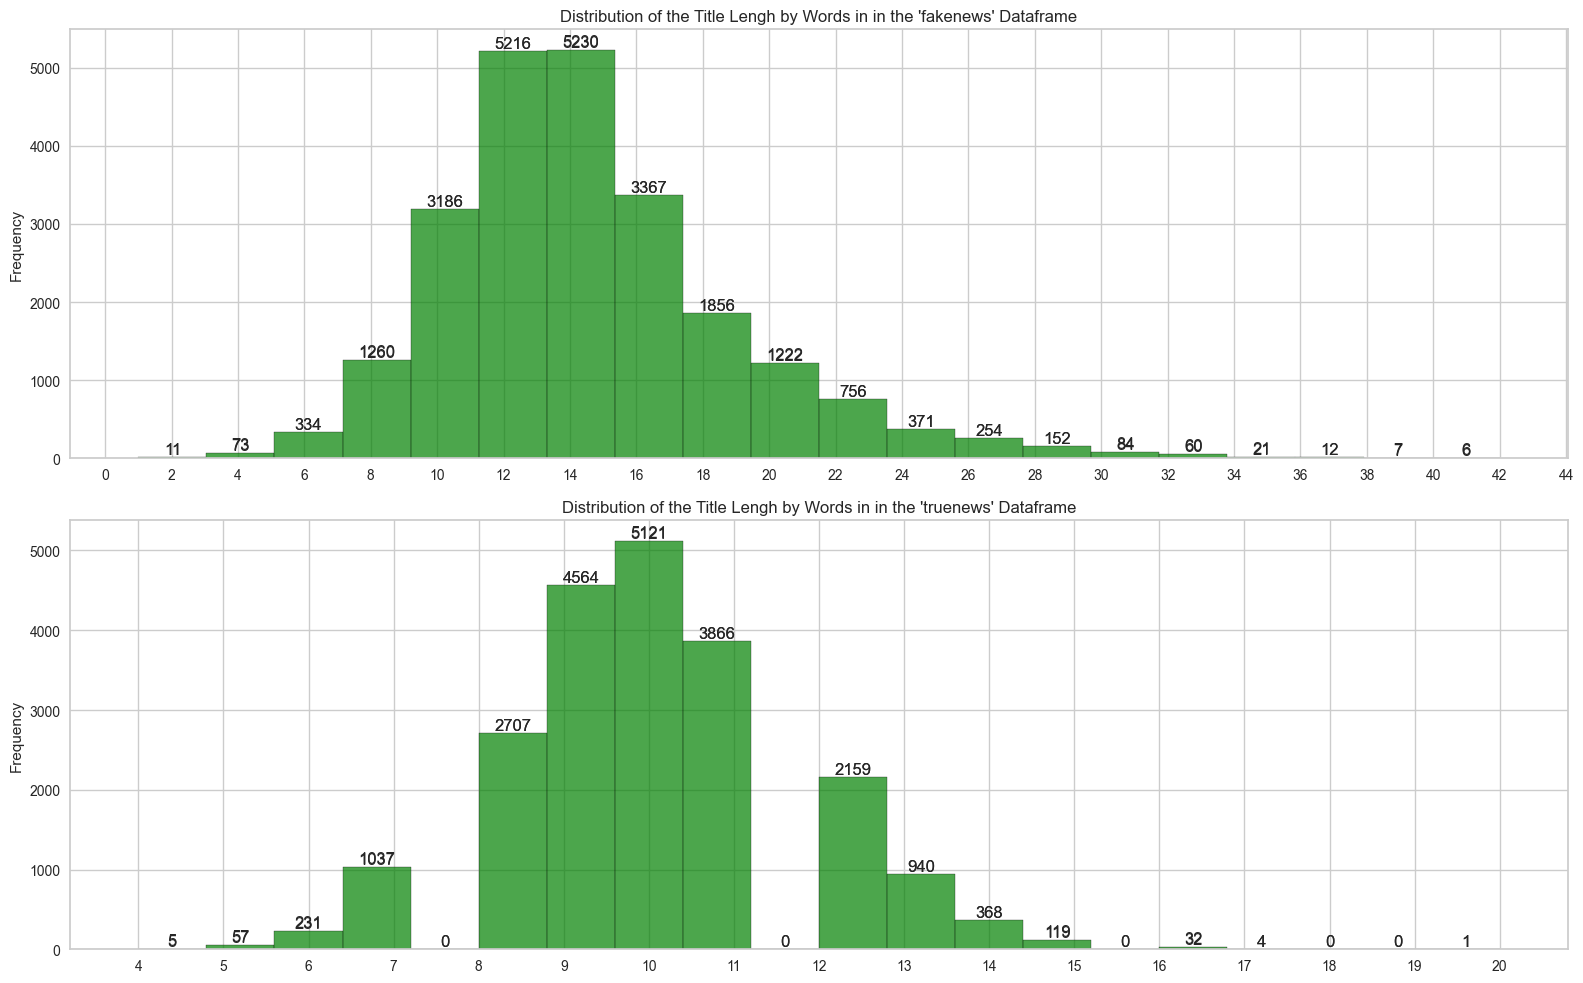

<IPython.core.display.Javascript object>

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_counts_hist(
    fakenews["title"].str.split().apply(len),
    bins=20,
    ax=ax1,
    title="Distribution of the Title Lengh by Words in in the 'fakenews' Dataframe",
)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=25))
plot_counts_hist(
    truenews["title"].str.split().apply(len),
    bins=20,
    ax=ax2,
    title="Distribution of the Title Lengh by Words in in the 'truenews' Dataframe",
)
ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.tight_layout()

plt.show()

In [26]:
print(fakenews["text"].str.split().apply(len).describe().round(2))
print("")
print(truenews["text"].str.split().apply(len).describe().round(2))
print("")
print(fakenews["title"].str.split().apply(len).describe().round(2))
print("")
print(truenews["title"].str.split().apply(len).describe().round(2))

count    23478.00
mean       423.22
std        408.41
min          0.00
25%        240.00
50%        363.00
75%        506.00
max       8135.00
Name: text, dtype: float64

count    21211.00
mean       384.76
std        273.91
min          0.00
25%        147.00
50%        359.00
75%        523.00
max       5172.00
Name: text, dtype: float64

count    23478.00
mean        14.73
std          4.34
min          1.00
25%         12.00
50%         14.00
75%         17.00
max         42.00
Name: title, dtype: float64

count    21211.00
mean         9.95
std          1.70
min          4.00
25%          9.00
50%         10.00
75%         11.00
max         20.00
Name: title, dtype: float64


<IPython.core.display.Javascript object>

The counting of words comfirmed the same observations which were made by examining counts of characters - more 'fake' articles  have less than 400 words in their text but less 'fake' articles have less than 10 words. Also, articles in the fakenes dataframes have more extreme outliers. 

### Counting top stopwords and non-stopwords

Next, numbers of stopwords and other words which are most often used are counted and presented in the plots. The code for calculating stopwords and the function for plotting stopwords was taken and adapted from here: https://app.neptune.ai/o/neptune-ai/org/eda-nlp-tools/n/1-3-top-stopwords-barchart-b953763c-3fea-4331-bff0-429411793e5f/5c0fca05-ba07-4564-a02e-c44b08bfb8cb


##### Stopwords

Stopwords are downloaded from the nltk library.

In [27]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<IPython.core.display.Javascript object>

In [28]:
stop = set(stopwords.words("english"))

<IPython.core.display.Javascript object>

Functions for the inclusion of words into word corpuses were created, both with cases and with lower cases. The corpuses of all words in fakenews and truenews texts and titles are created; occurences of stopwords are counted and saved in the dictionaries (with the created function build_corpus_and_dict()).

In [29]:
def build_corpus_and_dict(data_column: pd.Series) -> List[Any]:
    """
    This function takes a pandas series, splits the strings, converts it into a list and then creates a new list with every single word as separate element

    Args:
    data_column (pd.Series): A pandas series where each entry is assumed to be a space-separated string of words.

    Returns:
    List[Any]: A list where each word from the original series is a separate element.
    """
    corpus_data = []
    data_lst = data_column.str.split()
    data_lst = data_lst.values.tolist()
    corpus_data = [word for i in data_lst for word in i]

    return corpus_data

<IPython.core.display.Javascript object>

In [30]:
def build_corpus_and_dict_lower(data_column: pd.Series) -> List[Any]:
    """
    This function takes a pandas series, splits the strings, converts it into a list and then creates a new list with every single word as separate element

    Args:
    data_column (pd.Series): A pandas series where each entry is assumed to be a space-separated string of words.

    Returns:
    List[Any]: A list where each word from the original series is a separate element.
    """
    corpus_data = []
    data_lst = data_column.str.split()
    data_lst = data_lst.values.tolist()
    corpus_data = [word.lower() for i in data_lst for word in i]
    return corpus_data

<IPython.core.display.Javascript object>

In [31]:
corpus_fakenews_txt = build_corpus_and_dict(fakenews["text"])
corpus_truenews_txt = build_corpus_and_dict(truenews["text"])
corpus_fakenews_title = build_corpus_and_dict(fakenews["title"])
corpus_truenews_title = build_corpus_and_dict(truenews["title"])

<IPython.core.display.Javascript object>

In [32]:
corpus_fakenews_txt_lower = build_corpus_and_dict_lower(fakenews["text"])
corpus_truenews_txt_lower = build_corpus_and_dict_lower(truenews["text"])
corpus_fakenews_title_lower = build_corpus_and_dict_lower(fakenews["title"])
corpus_truenews_title_lower = build_corpus_and_dict_lower(truenews["title"])

<IPython.core.display.Javascript object>

Also, the function for creation of list of non-stopwords was created and run on the corpuses of text and titles in both datasets. 

In [33]:
def create_no_stopwords_list(data):
    no_stopwords_list = []
    for word in data:
        if word not in stop:
            no_stopwords_list.append(word)
    return no_stopwords_list


<IPython.core.display.Javascript object>

In [34]:
no_stopwords_fakenews_txt = create_no_stopwords_list(corpus_fakenews_txt)
no_stopwords_truenews_txt = create_no_stopwords_list(corpus_truenews_txt)
no_stopwords_fakenews_title = create_no_stopwords_list(corpus_fakenews_title)
no_stopwords_truenews_title = create_no_stopwords_list(corpus_truenews_title)

<IPython.core.display.Javascript object>

In [35]:
no_stopwords_fakenews_txt_lower = create_no_stopwords_list(corpus_fakenews_txt_lower)
no_stopwords_truenews_txt_lower = create_no_stopwords_list(corpus_truenews_txt_lower)
no_stopwords_fakenews_title_lower = create_no_stopwords_list(corpus_fakenews_title_lower)
no_stopwords_truenews_title_lower = create_no_stopwords_list(corpus_truenews_title_lower)

<IPython.core.display.Javascript object>

The function for plotting counts of occurences of stowords is created and the distributions of stopword counts are plotted.

In [36]:
def plot_top_stopwords_barchart(
    text: pd.Series, corpus: List, ax: plt.Axes, df: Any
) -> None:
    """
    Plot a bar chart of the top stopwords in the text.

    Parameters:
        text (pd.Series): Pandas Series containing the text data.
        ax (plt.Axes): Matplotlib axis to plot on.
        df (Any): Dataframe associated with the text.

    Returns:
        None
    """
    stop = set(stopwords.words("english"))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
    x, y = zip(*top)

    ax.bar(x, y)
    ax.set_xlabel("Stopwords")
    ax.set_ylabel("Frequency")
    ax.set_title(
        f"Top 10 Stopwords in the News {text.name}: \
the {[name for name in globals() if globals()[name] is df][0]} Dataframe"
    )

<IPython.core.display.Javascript object>

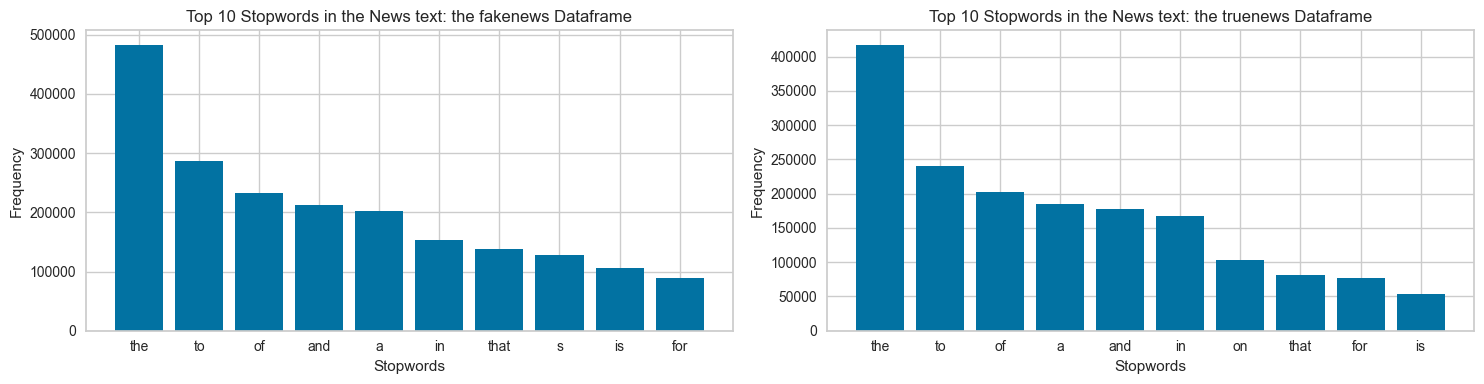

<IPython.core.display.Javascript object>

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

plot_top_stopwords_barchart(fakenews["text"], no_stopwords_fakenews_txt, ax1, fakenews)
plot_top_stopwords_barchart(truenews["text"], no_stopwords_truenews_txt, ax2, truenews)

plt.tight_layout()
plt.show()

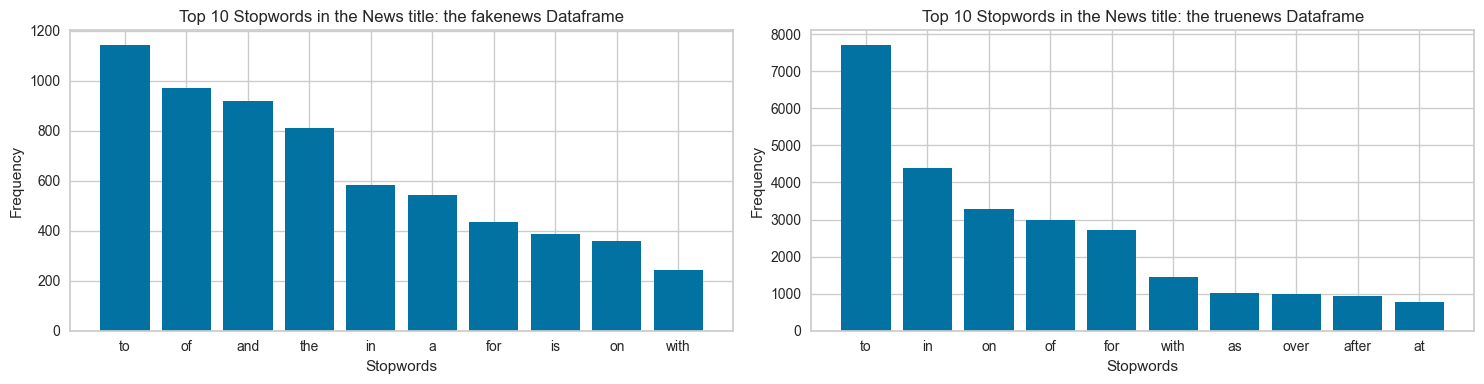

<IPython.core.display.Javascript object>

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

plot_top_stopwords_barchart(fakenews["title"], no_stopwords_fakenews_title, ax1, fakenews)
plot_top_stopwords_barchart(truenews["title"], no_stopwords_truenews_title, ax2, truenews)

plt.tight_layout()
plt.show()

No significant differences in the use of stopwords in fakenews and truenews dataframes are observed. 

##### Non-stopwords

Also, occurences of non-stopwords and most often used words are counted in both fakenews and truenews datasets. As it was assumed that there might be differences in corpuses with and without lowered cases, occurences of words and most often used words were counted with both functions.

In [39]:
counter_fakenews_txt = Counter(no_stopwords_fakenews_txt)
most_fakenews_txt = counter_fakenews_txt.most_common()

counter_truenews_txt = Counter(no_stopwords_truenews_txt)
most_truenews_txt = counter_truenews_txt.most_common()

counter_fakenews_title = Counter(no_stopwords_fakenews_title)
most_fakenews_title = counter_fakenews_title.most_common()

counter_truenews_title = Counter(no_stopwords_truenews_title)
most_truenews_title = counter_truenews_title.most_common()

<IPython.core.display.Javascript object>

In [40]:
counter_fakenews_txt_lower = Counter(no_stopwords_fakenews_txt_lower)
most_fakenews_txt_lower = counter_fakenews_txt_lower.most_common()

counter_truenews_txt_lower = Counter(no_stopwords_truenews_txt_lower)
most_truenews_txt_lower = counter_truenews_txt_lower.most_common()

counter_fakenews_title_lower = Counter(no_stopwords_fakenews_title_lower)
most_fakenews_title_lower = counter_fakenews_title_lower.most_common()

counter_truenews_title_lower = Counter(no_stopwords_truenews_title_lower)
most_truenews_title_lower = counter_truenews_title_lower.most_common()

<IPython.core.display.Javascript object>

The function for plotting the non-stopwords is created and the distributions of the occurences of top non-stopwords are plotted.

In [41]:
def plot_top_non_stopwords_barchart(
    word_counts: List[Tuple[str, int]], ax: plt.Axes, title: str, number: int
) -> None:
    """
    Plot a bar chart of the top non-stopwords.

    Parameters:
        word_counts (List[Tuple[str, int]]): List of tuples containing word-count pairs.
        ax (plt.Axes): Matplotlib axis to plot on.
        title (str): Title for the plot.

    Returns:
        None
    """
    x, y = [], []
    for word, count in word_counts[:number]:
        if word not in stop:
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, ax=ax)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")
    ax.set_title(title)

<IPython.core.display.Javascript object>

#### Cases are not lowered

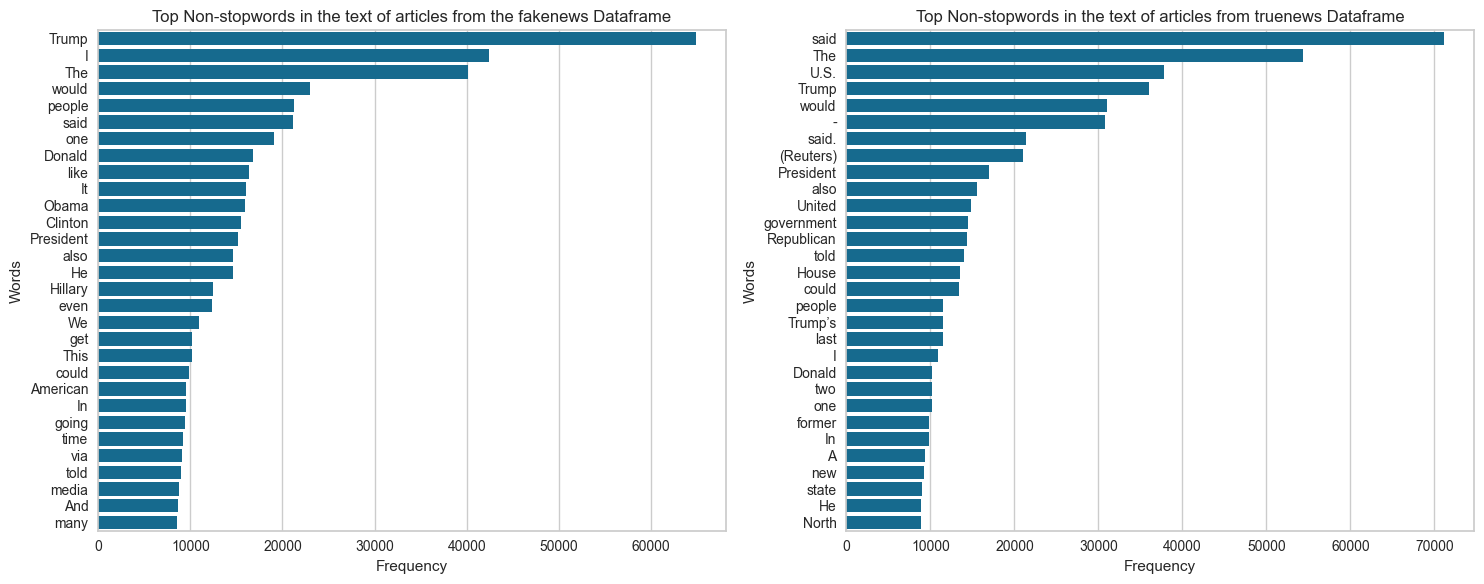

<IPython.core.display.Javascript object>

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_non_stopwords_barchart(
    most_fakenews_txt,
    ax1,
    "Top Non-stopwords in the text of articles from the fakenews Dataframe",
    30,
)
plot_top_non_stopwords_barchart(
    most_truenews_txt,
    ax2,
    "Top Non-stopwords in the text of articles from truenews Dataframe",
    30,
)
plt.tight_layout()
plt.show()

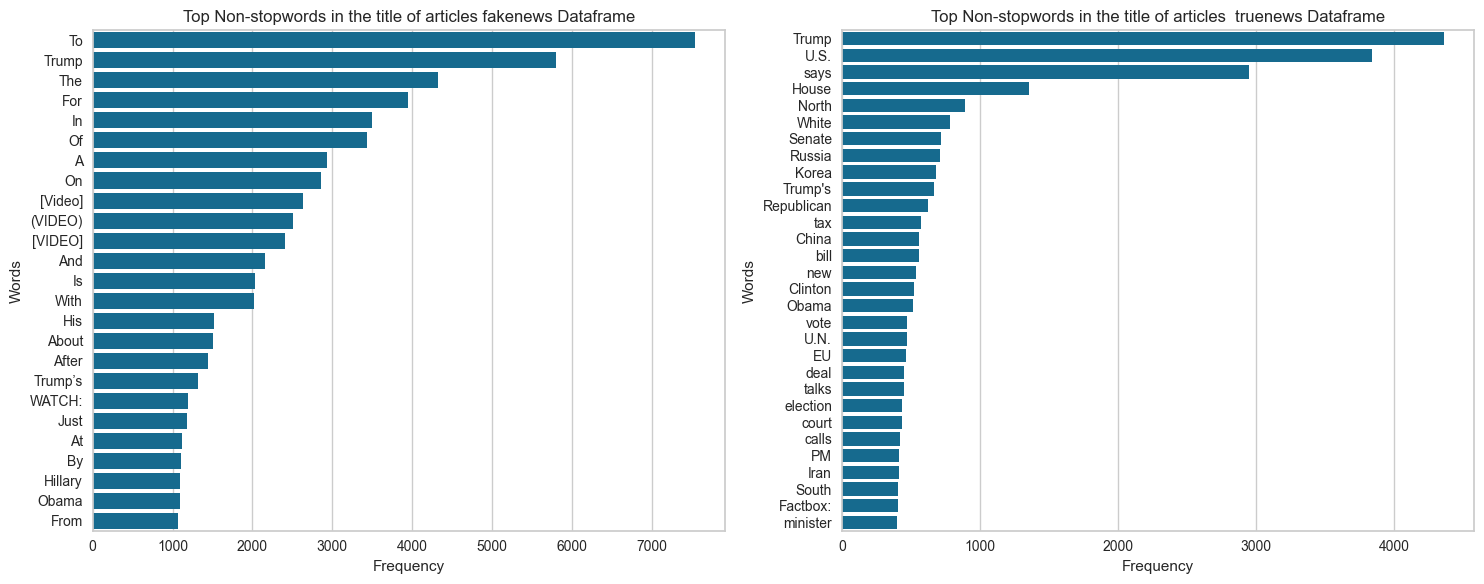

<IPython.core.display.Javascript object>

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_non_stopwords_barchart(
    most_fakenews_title,
    ax1,
    "Top Non-stopwords in the title of articles fakenews Dataframe",
    25,
)
plot_top_non_stopwords_barchart(
    most_truenews_title,
    ax2,
    "Top Non-stopwords in the title of articles  truenews Dataframe",
    30,
)
plt.tight_layout()
plt.show()

#### Cases are lowered

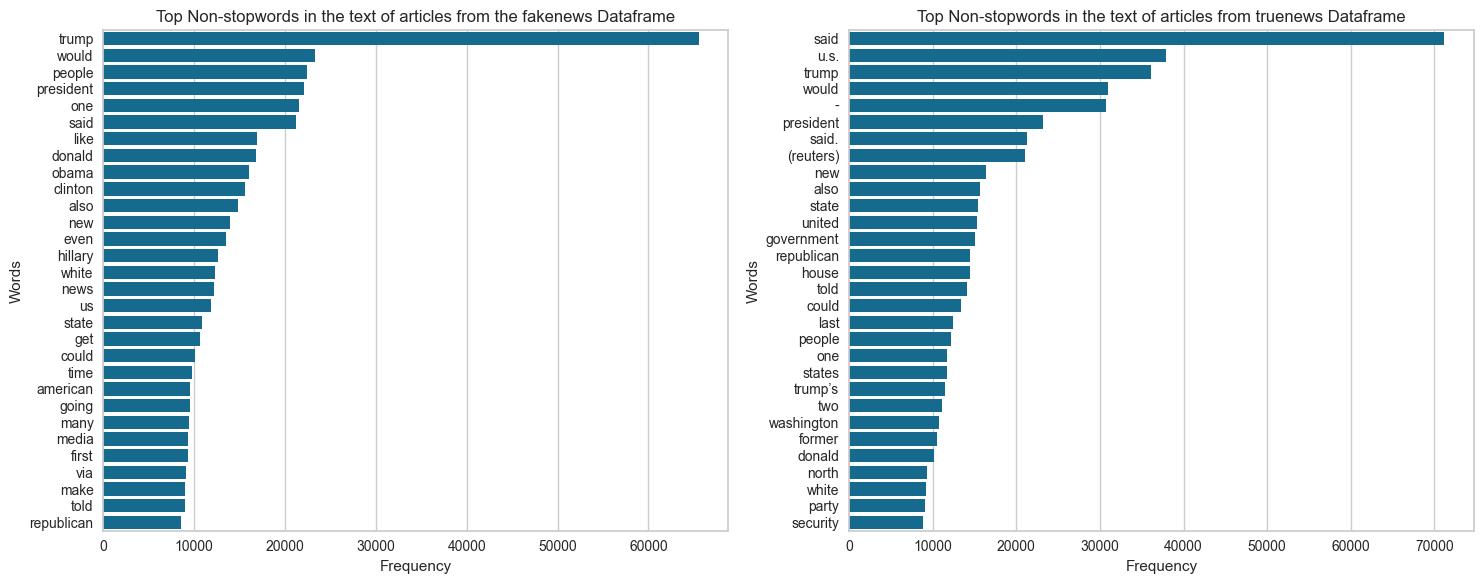

<IPython.core.display.Javascript object>

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_non_stopwords_barchart(most_fakenews_txt_lower, ax1, "Top Non-stopwords in the text of articles from the fakenews Dataframe", 30)
plot_top_non_stopwords_barchart(most_truenews_txt_lower, ax2, "Top Non-stopwords in the text of articles from truenews Dataframe", 30)
plt.tight_layout()
plt.show()


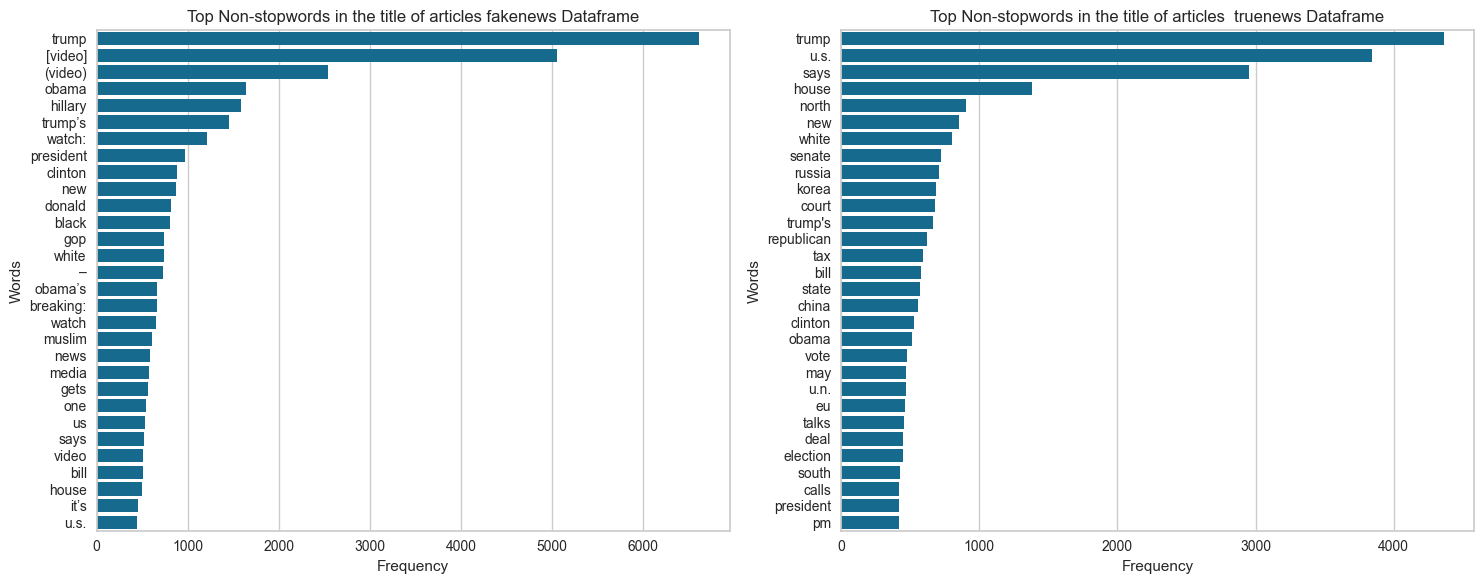

<IPython.core.display.Javascript object>

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_non_stopwords_barchart(
    most_fakenews_title_lower,
    ax1,
    "Top Non-stopwords in the title of articles fakenews Dataframe",
    30,
)
plot_top_non_stopwords_barchart(
    most_truenews_title_lower,
    ax2,
    "Top Non-stopwords in the title of articles  truenews Dataframe",
    30,
)
plt.tight_layout()
plt.show()

The following observations can be noted from the analysis:
- Articles within the 'fakenews' dataset frequently mention first names of U.S. politicians, such as 'Donald' and 'Hilary'.
- Titles of articles categorized as 'fake' often contain keywords like 'WATCH:' or 'video'. Conversely, the text of 'true' articles commonly includes the keyword 'Reuters'.
 - Articles in the fakenews dataset are quite often written in the first-person style (the pronoun "I" is among the most used words).
 - In the analysis of frequently used non-stopwords in the 'fakenews' dataset, it is noted that when cases are not converted to lowercase, stopwords such as 'To', 'In', 'Of', 'A', 'For', 'On', 'The', etc., are among the most commonly used words. Conversely, in the 'truenews' dataset, the most frequently used words in article titles show no significant difference between their lowercase and non-lowercase forms. This suggests that, unlike the 'fakenews' articles, the titles in the 'truenews' dataset typically do not start with capital letters.

### Finding distinctive non-stopwords

In order to find out which non-stopwords are distinctive in fakenews and true news datasets, differences between counts of words in both datasets were calculated. The list containing dictionaires with words as keys and differences between counts as values was created and sorted (see the function bellow).

In [46]:
def get_word_count_differences(data_list1, data_list2):

    differences_dict = {}

    for d1 in data_list1:
        for key, value1 in d1.items():
            value2 = sum(d2.get(key, 0) for d2 in data_list2)    
            differences_dict[key] = value1 - value2
    
    
    for d2 in data_list2:
        for key, value2 in d2.items():
            if key not in differences_dict:
                differences_dict[key] = -value2
    
    differences_list = [{key: value} for key, value in differences_dict.items()]

    return differences_list

<IPython.core.display.Javascript object>

Lists of tuples of words and their counts are transformed to lists of dictionaires. 

In [47]:
most_fakenews_dict_txt = [{t[0]: t[1]} for t in most_fakenews_txt]
most_truenews_dict_txt = [{t[0]: t[1]} for t in most_truenews_txt]
most_fakenews_dict_title = [{t[0]: t[1]} for t in most_fakenews_title]
most_truenews_dict_title = [{t[0]: t[1]} for t in most_truenews_title]

most_fakenews_dict_txt_lower = [{t[0]: t[1]} for t in most_fakenews_txt_lower]
most_truenews_dict_txt_lower = [{t[0]: t[1]} for t in most_truenews_txt_lower]
most_fakenews_dict_title_lower = [{t[0]: t[1]} for t in most_fakenews_title_lower]
most_truenews_dict_title_lower = [{t[0]: t[1]} for t in most_truenews_title_lower]


<IPython.core.display.Javascript object>

Values in lists of dictionaires were sorted (only lowered dataset were examined). 

In [48]:
sorted_most_fakenews_dict_txt_lower = sorted(most_fakenews_dict_txt_lower, key=lambda x: list(x.values())[0])
sorted_most_truenews_dict_txt_lower = sorted(most_truenews_dict_txt_lower, key=lambda x: list(x.values())[0])

sorted_most_fakenews_dict_title_lower = sorted(most_fakenews_dict_title_lower, key=lambda x: list(x.values())[0])
sorted_most_truenews_dict_title_lower = sorted(most_truenews_dict_title_lower, key=lambda x: list(x.values())[0])

<IPython.core.display.Javascript object>

The function for getting differences of counts was run on lists of dictionaires (10000 most frequently used words were selected from text of both datasets in order to save computer resources).

In [49]:
differences_list_words_text_lower = get_word_count_differences(sorted_most_fakenews_dict_txt_lower[-10000:], 
                                                               sorted_most_truenews_dict_txt_lower[-10000:])
                
differences_list_words_title_lower = get_word_count_differences(sorted_most_fakenews_dict_title_lower, 
                                                                sorted_most_truenews_dict_title_lower)

<IPython.core.display.Javascript object>

Values in lists of differences were sorted.

In [50]:
sorted_differences_words_txt_lower = sorted(differences_list_words_text_lower, key=lambda x: list(x.values())[0])
sorted_differences_words_title_lower = sorted(differences_list_words_title_lower, key=lambda x: list(x.values())[0])

<IPython.core.display.Javascript object>

The top highest and lowest values were plotted, highest values indicating distinctive words in the fakenews dataset, and the lowest values (minus values) indicating distinctive words in the truenews dataset. 

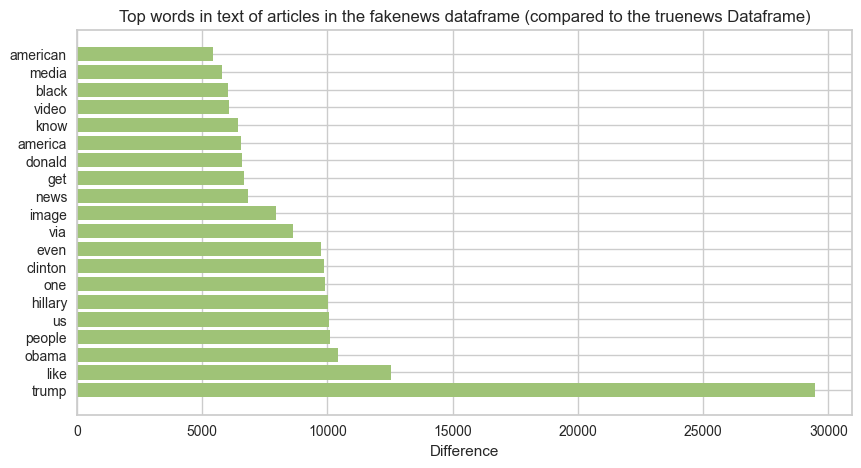

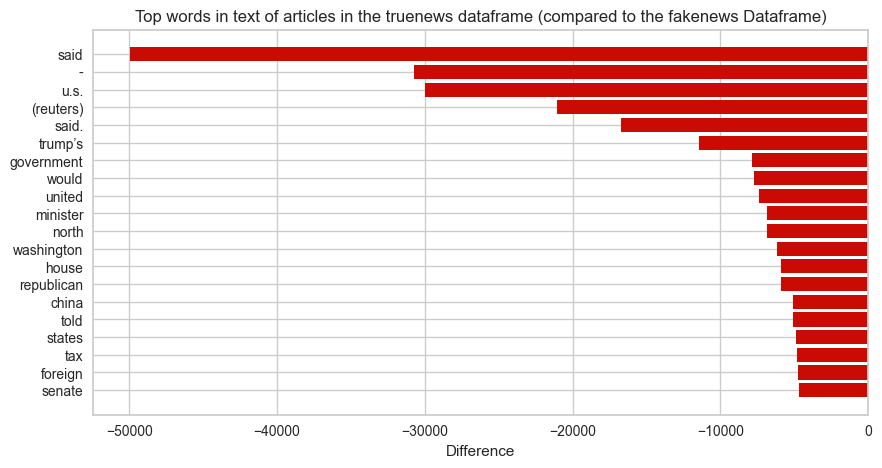

<IPython.core.display.Javascript object>

In [51]:
top_20_highest_txt_words_lower = sorted_differences_words_txt_lower[-20:]
top_20_lowest_txt_words_lower = sorted_differences_words_txt_lower[:20]

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_20_highest_txt_words_lower], [list(d.values())[0] for d in top_20_highest_txt_words_lower], 
         color='g')
plt.xlabel('Difference')
plt.title('Top words in text of articles in the fakenews dataframe (compared to the truenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_20_lowest_txt_words_lower], [list(d.values())[0] for d in top_20_lowest_txt_words_lower], 
         color='r')
plt.xlabel('Difference')
plt.title('Top words in text of articles in the truenews dataframe (compared to the fakenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

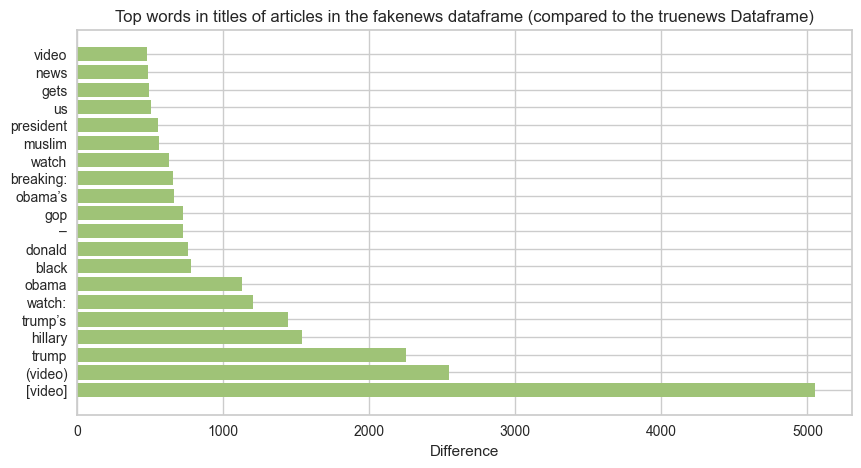

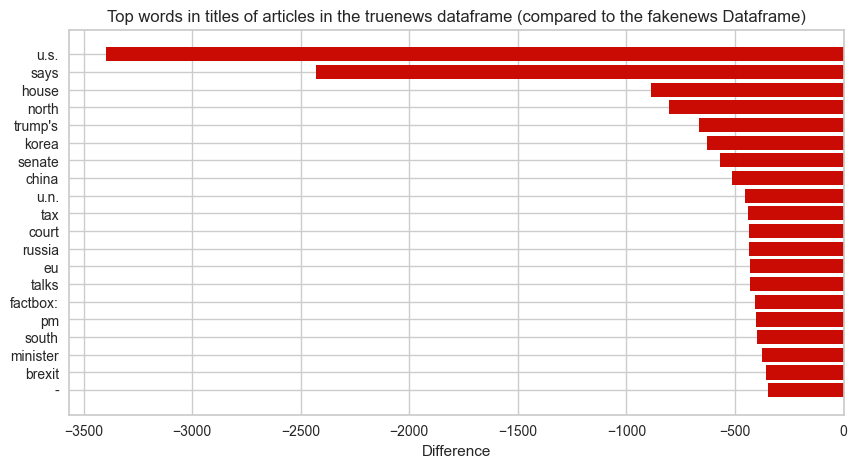

<IPython.core.display.Javascript object>

In [52]:
top_20_highest_title_words_lower = sorted_differences_words_title_lower[-20:]
top_20_lowest_title_words_lower = sorted_differences_words_title_lower[:20]

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_20_highest_title_words_lower], [list(d.values())[0] for d in top_20_highest_title_words_lower], 
         color='g')
plt.xlabel('Difference')
plt.title('Top words in titles of articles in the fakenews dataframe (compared to the truenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_20_lowest_title_words_lower], [list(d.values())[0] for d in top_20_lowest_title_words_lower], 
         color='r')
plt.xlabel('Difference')
plt.title('Top words in titles of articles in the truenews dataframe (compared to the fakenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

It can be observed that:
- in text of the fakenews dataset the most frequently used distinctive word ir 'trump';
- in the text of truenews dataset the most frequenly used distinctive words are 'reuters', 'said';
- in the titles of fakenews dataset the most frequently used distinctive words are 'video', 'trump', 'hilary';
- in the titlese of truenews dataset the most frequently used distinctive words are 'u.s.', 'says', 'house'.

### wordcloud analysis

Finally, worldcloud analysis of the news articles in the fakenews and truenews datasets was conducted by using the WordCloud library. Words which are most often used in the datasets are presented in the worldcloud maps. 

In [179]:
stopwords = set(STOPWORDS)

<IPython.core.display.Javascript object>

In [54]:
def show_wordcloud(data: str) -> None:
    """
    Displays a word cloud of the given data.

    Parameters:
        data (str): The data to be used for creating the word cloud.

    Returns:
        None: Displays the word cloud as a matplotlib figure.

    """

    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1,
    )

    wordcloud = wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.show()

<IPython.core.display.Javascript object>

In [55]:
no_stopwords_fakenews_txt = create_no_stopwords_list(corpus_fakenews_txt)
no_stopwords_truenews_txt = create_no_stopwords_list(corpus_truenews_txt)
no_stopwords_fakenews_title = create_no_stopwords_list(corpus_fakenews_title)
no_stopwords_truenews_title = create_no_stopwords_list(corpus_truenews_title)

<IPython.core.display.Javascript object>

Wordcloud for text in the fakenews dataset:


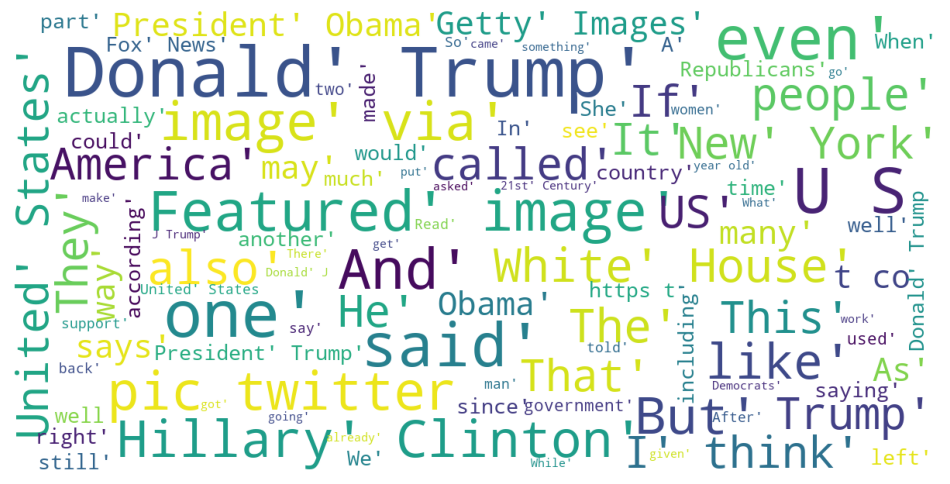

<IPython.core.display.Javascript object>

In [56]:
print("Wordcloud for text in the fakenews dataset:")
show_wordcloud(no_stopwords_fakenews_txt)

Wordcloud for titles in the fakenews dataset:


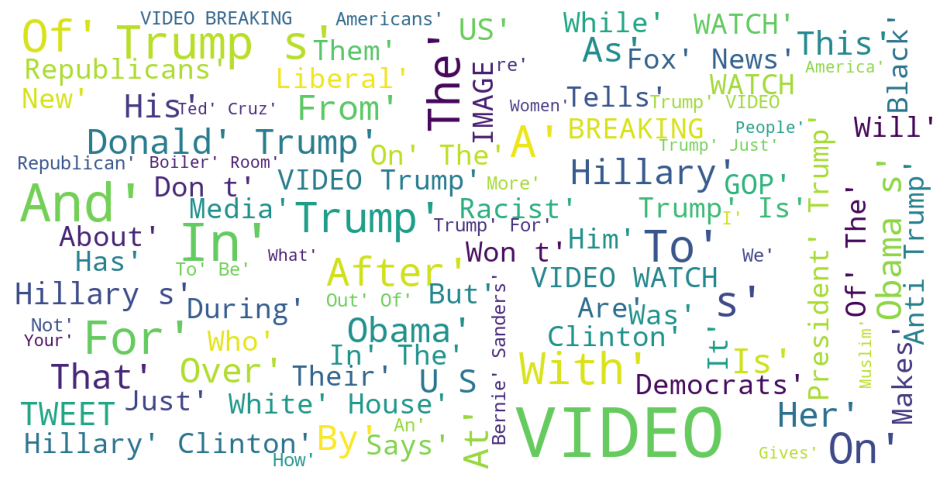

<IPython.core.display.Javascript object>

In [57]:
print("Wordcloud for titles in the fakenews dataset:")
show_wordcloud(no_stopwords_fakenews_title)

Wordcloud for text in the truenews dataset:


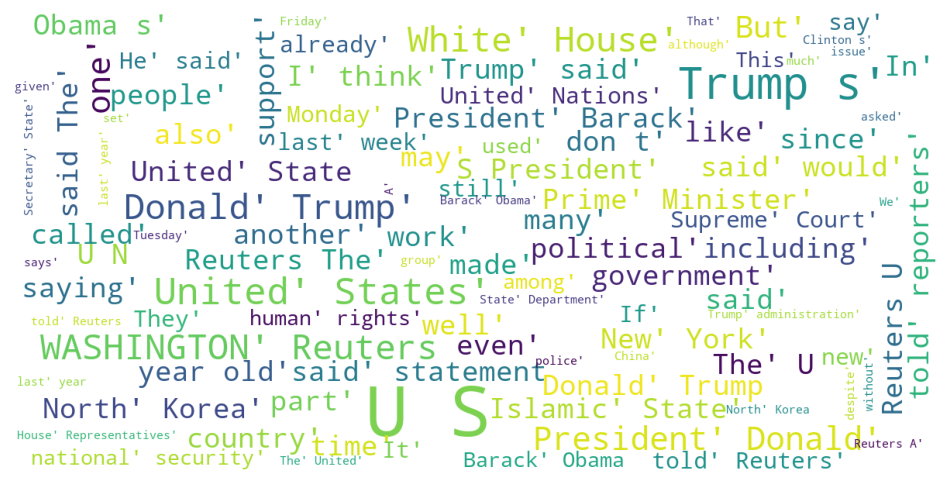

<IPython.core.display.Javascript object>

In [58]:
print("Wordcloud for text in the truenews dataset:")
show_wordcloud(no_stopwords_truenews_txt)

Wordcloud for titles in the truenews dataset:


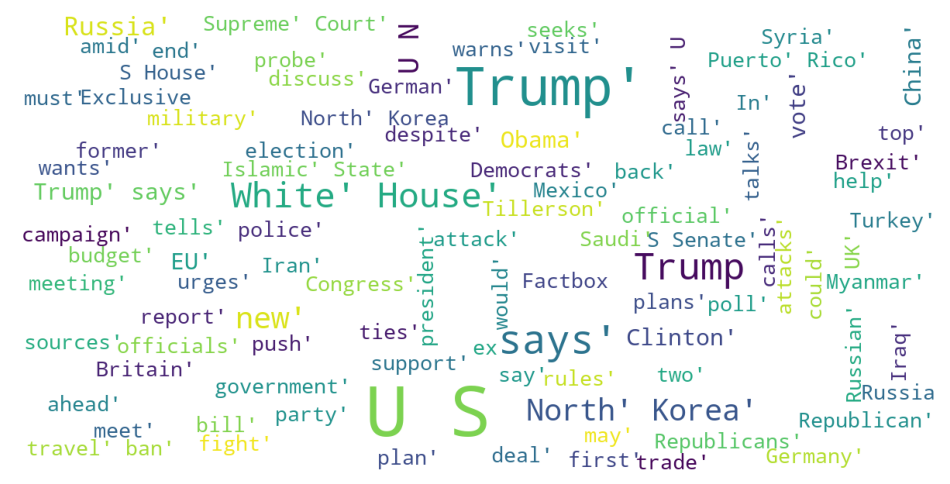

<IPython.core.display.Javascript object>

In [59]:
print("Wordcloud for titles in the truenews dataset:")
show_wordcloud(no_stopwords_truenews_title)

By examining the worldclouds the following observations could be made:
 - most frequently used words in text of articles in the fakenews dataset do not have meaningful content (exept such words as Hillary, Clinton and Trump). The most frequently used words in titles are 'video', 'breaking', and 'watch' (which are used to attract attention); words which could refer to ideological divisions (racist, black, liberal,Republican, Democracy); words referring to personalities (Trump, Hillary, Sanders).

### Counting ngrams

Next, bigrams of the text of articles in the fakenews and truenews dadtasets are analysed. The functions for getting top bigrams and plotting them are created, distributions of top bigrams are plotted. The functions were adapted from here: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [60]:
def get_top_ngram(corpus: List[str], n: int = None) -> List[Tuple[str, int]]:
    """
    Returns the top n ngrams (sequences of n words) in a given corpus.

    Args:
        corpus (List[str]): A list of strings representing the corpus.
        n (int, optional): The length of the ngrams to be counted. Defaults to None.

    Returns:
        List[Tuple[str, int]]: A list of tuples containing the ngram and its frequency in the corpus, sorted in descending order by frequency.
    """

    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

<IPython.core.display.Javascript object>

In [61]:
def get_top_ngram_differences(corpus1: List[str], corpus2: List[str], n: int = None) -> List[Tuple[str, int]]:
    """
    Returns the top n ngrams (sequences of n words) in a given corpus.

    Args:
        corpus (List[str]): A list of strings representing the corpus.
        n (int, optional): The length of the ngrams to be counted. Defaults to None.

    Returns:
        List[Tuple[str, int]]: A list of tuples containing the ngram and its frequency in the corpus, sorted in descending order by frequency.
    """

    vec1 = CountVectorizer(ngram_range=(n, n)).fit(corpus1)
    bag_of_words1 = vec1.transform(corpus1)
    sum_words1 = bag_of_words1.sum(axis=0)

    vec2 = CountVectorizer(ngram_range=(n, n)).fit(corpus2)
    bag_of_words2 = vec2.transform(corpus2)
    sum_words2 = bag_of_words2.sum(axis=0)

    words_freq1 = [{word: sum_words1[0, idx]} for word, idx in vec1.vocabulary_.items()]
    words_freq2 = [{word: sum_words2[0, idx]} for word, idx in vec2.vocabulary_.items()]

    differences_dict = {}

    for d1 in words_freq1:
        for key, value1 in d1.items():
            value2 = sum(d2.get(key, 0) for d2 in words_freq2)    
            differences_dict[key] = value1 - value2
    
    
    for d2 in words_freq2:
        for key, value2 in d2.items():
            if key not in differences_dict:
                differences_dict[key] = -value2
    
    differences_list = [{key: value} for key, value in differences_dict.items()]

    return differences_list

<IPython.core.display.Javascript object>

#### finding distinctive bigrams:

The function was run to get distinctive bigrams in both datasets. 

In [62]:
differences_list_txt = get_top_ngram_differences(corpus_fakenews_txt, corpus_truenews_txt, 2)
differences_list_title = get_top_ngram_differences(corpus_fakenews_title, corpus_truenews_title, 2)

<IPython.core.display.Javascript object>

The values in lists of differences were sorted. 

In [63]:
sorted_differences_txt = sorted(differences_list_txt, key=lambda x: list(x.values())[0])
sorted_differences_title = sorted(differences_list_title, key=lambda x: list(x.values())[0])

<IPython.core.display.Javascript object>

The top values (highest and lowest differences) were selected and plotted. 

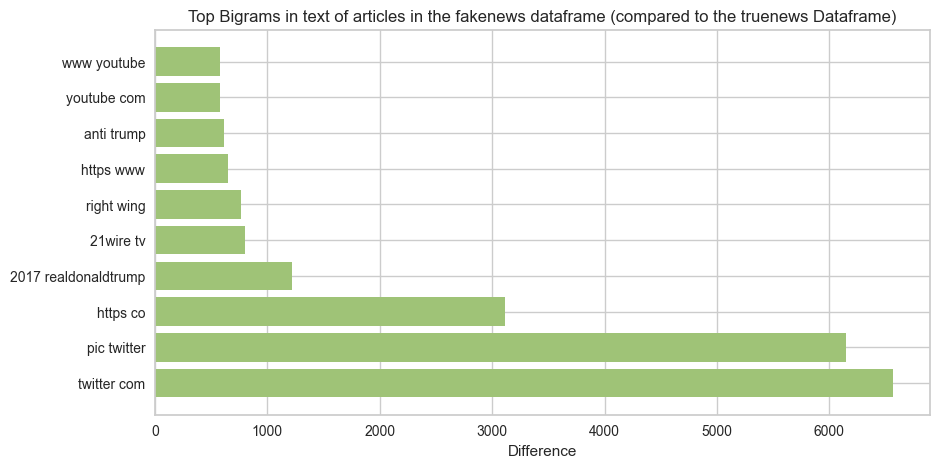

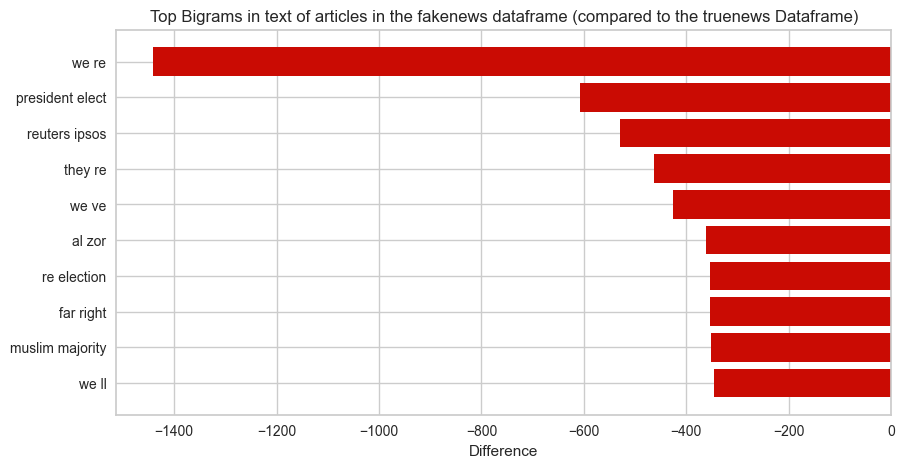

<IPython.core.display.Javascript object>

In [64]:
top_10_highest_txt = sorted_differences_txt[-10:]
top_10_lowest_txt = sorted_differences_txt[:10]

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_10_highest_txt], [list(d.values())[0] for d in top_10_highest_txt], color='g')
plt.xlabel('Difference')
plt.title('Top Bigrams in text of articles in the fakenews dataframe (compared to the truenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_10_lowest_txt], [list(d.values())[0] for d in top_10_lowest_txt], color='r')
plt.xlabel('Difference')
plt.title('Top Bigrams in text of articles in the fakenews dataframe (compared to the truenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

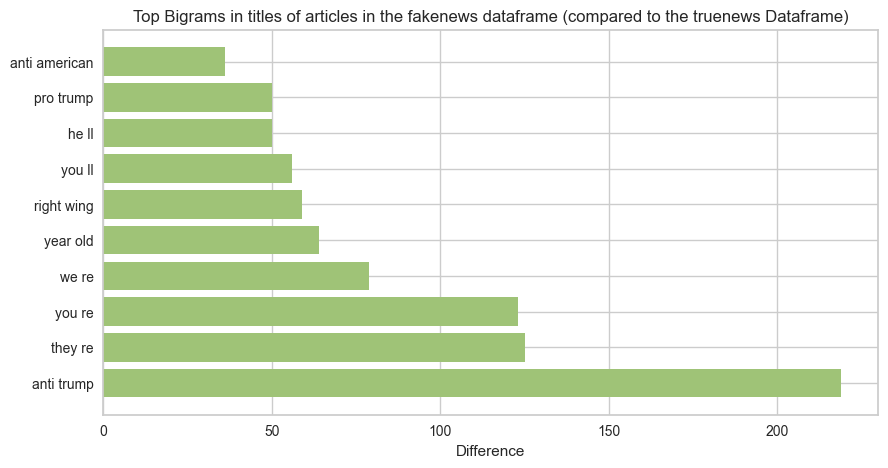

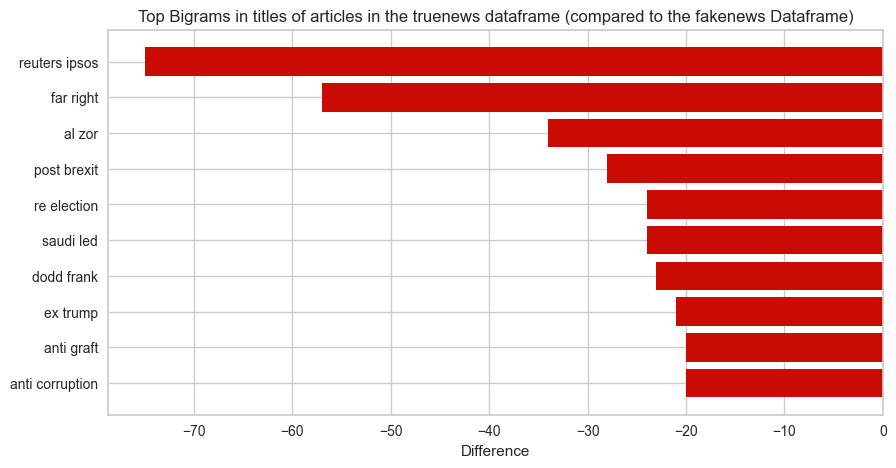

<IPython.core.display.Javascript object>

In [65]:
top_10_highest_title = sorted_differences_title[-10:]
top_10_lowest_title = sorted_differences_title[:10]

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_10_highest_title], [list(d.values())[0] for d in top_10_highest_title], color='g')
plt.xlabel('Difference')
plt.title('Top Bigrams in titles of articles in the fakenews dataframe (compared to the truenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_10_lowest_title], [list(d.values())[0] for d in top_10_lowest_title], color='r')
plt.xlabel('Difference')
plt.title('Top Bigrams in titles of articles in the truenews dataframe (compared to the fakenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

#### Finding top bigrams in each dataset

Next, top bigrams in each dataset were identified without teh reference to another dataset.

In [66]:
def plot_top_bigrams_barchart(top_bigrams: List[Tuple[str, int]], ax: plt.Axes, title: str) -> None:
    """
    Plot a bar chart of the top bigrams.

    Args:
        top_bigrams: A list of tuples containing the bigram and its frequency.
        ax: The axes on which to plot the bar chart.
        title: The title of the bar chart.
    """
    x, y = map(list, zip(*top_bigrams))
    sns.barplot(x=y, y=x, ax=ax)

    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")
    ax.set_title(title)


<IPython.core.display.Javascript object>

In [67]:
top_bigrams_fakenews_txt = get_top_ngram(corpus_fakenews_txt, 2)[:10]
top_bigrams_truenews_txt = get_top_ngram(corpus_truenews_txt, 2)[:10]

top_bigrams_fakenews_title = get_top_ngram(corpus_fakenews_title, 2)[:10]
top_bigrams_truenews_title = get_top_ngram(corpus_truenews_title, 2)[:10]


<IPython.core.display.Javascript object>

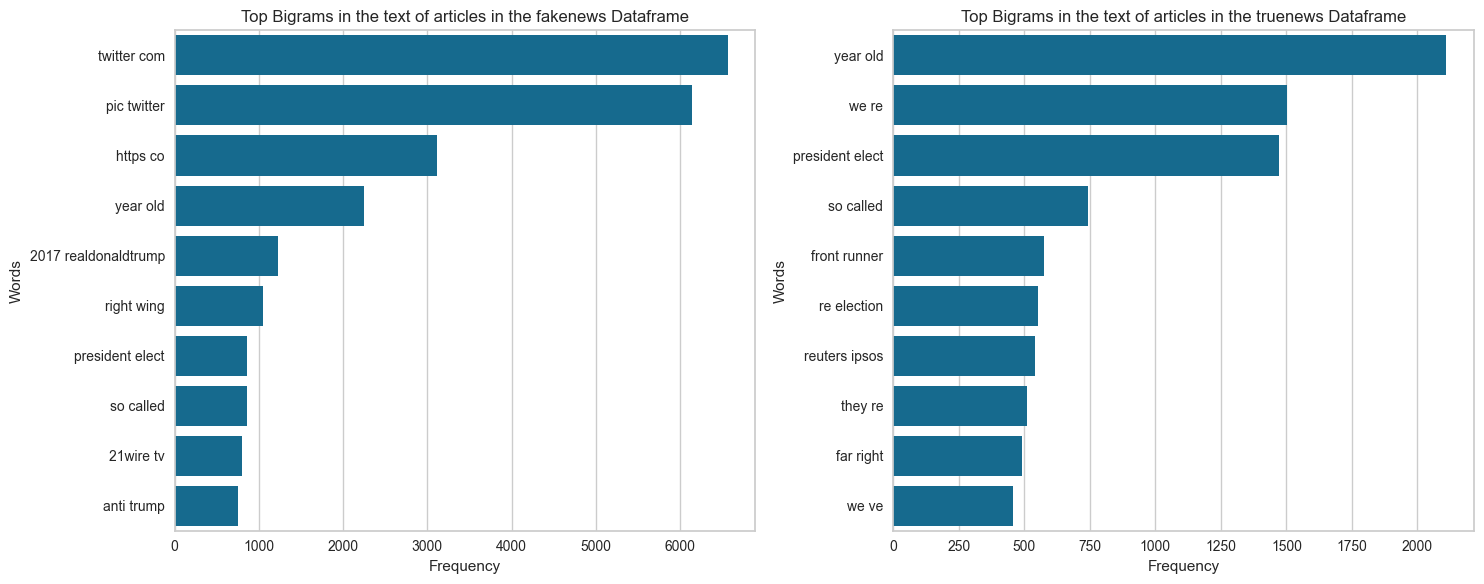

<IPython.core.display.Javascript object>

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_bigrams_barchart(
    top_bigrams_fakenews_txt,
    ax1,
    "Top Bigrams in the text of articles in the fakenews Dataframe",
)
plot_top_bigrams_barchart(
    top_bigrams_truenews_txt,
    ax2,
    "Top Bigrams in the text of articles in the truenews Dataframe",
)

plt.tight_layout()
plt.show()

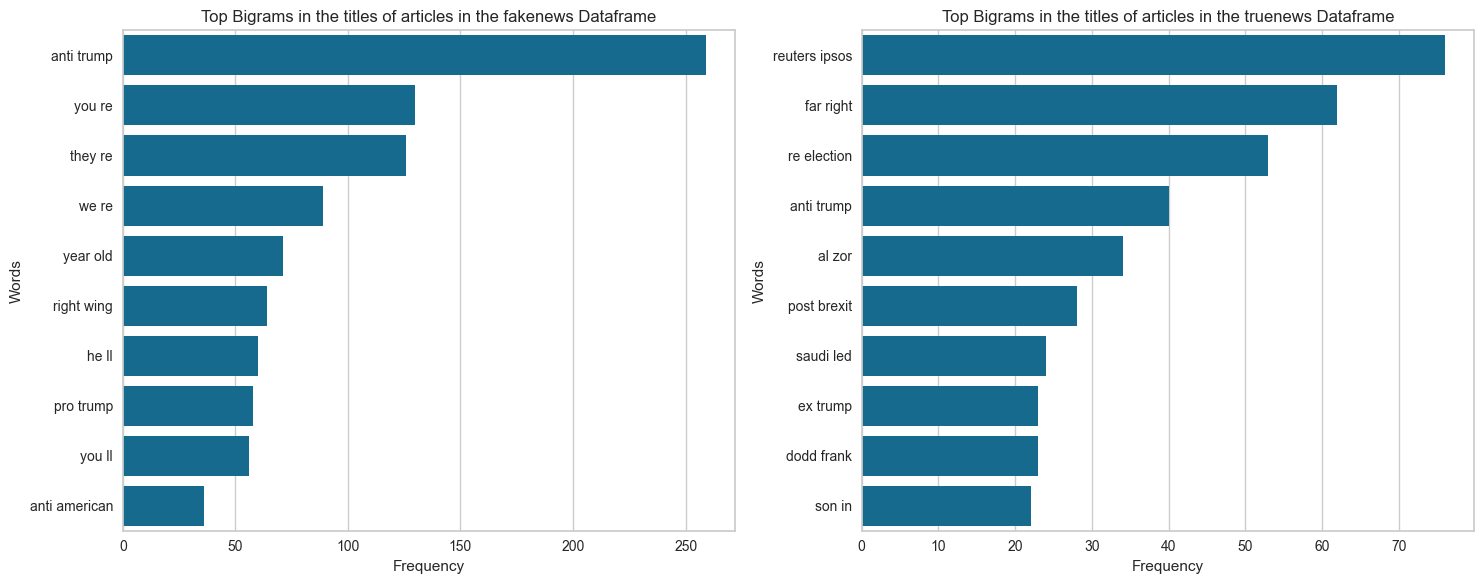

<IPython.core.display.Javascript object>

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_bigrams_barchart(
    top_bigrams_fakenews_title,
    ax1,
    "Top Bigrams in the titles of articles in the fakenews Dataframe",
)
plot_top_bigrams_barchart(
    top_bigrams_truenews_title,
    ax2,
    "Top Bigrams in the titles of articles in the truenews Dataframe",
)

plt.tight_layout()
plt.show()

#### finding distinctive trigrams:

The distinctive trigrams were identified and plotted in both datasets. 

In [70]:
differences_list_txt = get_top_ngram_differences(corpus_fakenews_txt, corpus_truenews_txt, 3)
differences_list_title = get_top_ngram_differences(corpus_fakenews_title, corpus_truenews_title, 3)

<IPython.core.display.Javascript object>

In [71]:
sorted_differences_txt = sorted(differences_list_txt, key=lambda x: list(x.values())[0])
sorted_differences_title = sorted(differences_list_title, key=lambda x: list(x.values())[0])

<IPython.core.display.Javascript object>

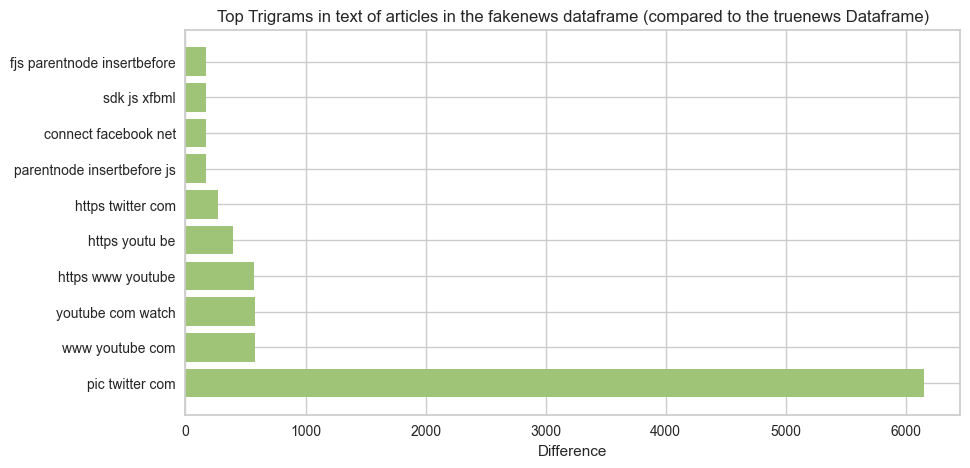

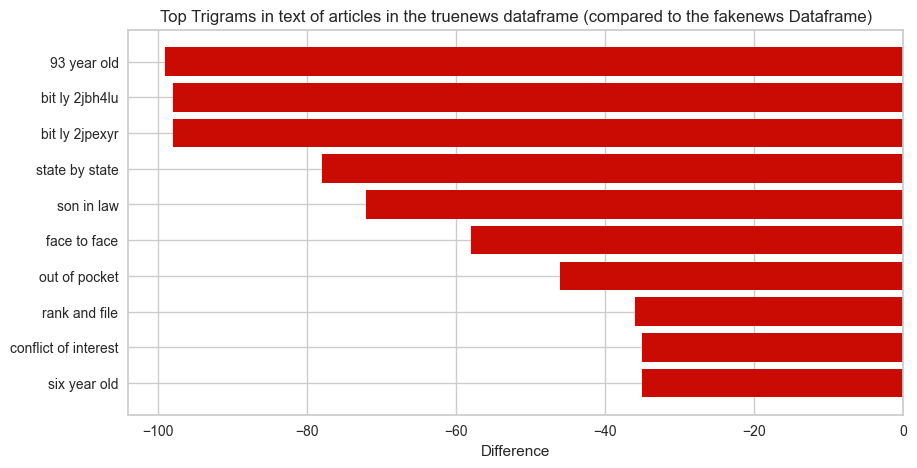

<IPython.core.display.Javascript object>

In [72]:

top_10_highest_txt = sorted_differences_txt[-10:]
top_10_lowest_txt = sorted_differences_txt[:10]

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_10_highest_txt], [list(d.values())[0] for d in top_10_highest_txt], color='g')
plt.xlabel('Difference')
plt.title('Top Trigrams in text of articles in the fakenews dataframe (compared to the truenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_10_lowest_txt], [list(d.values())[0] for d in top_10_lowest_txt], color='r')
plt.xlabel('Difference')
plt.title('Top Trigrams in text of articles in the truenews dataframe (compared to the fakenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

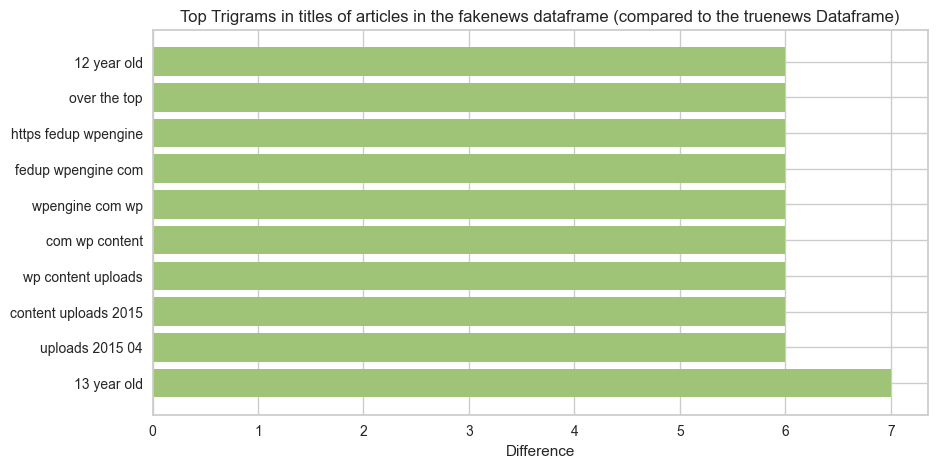

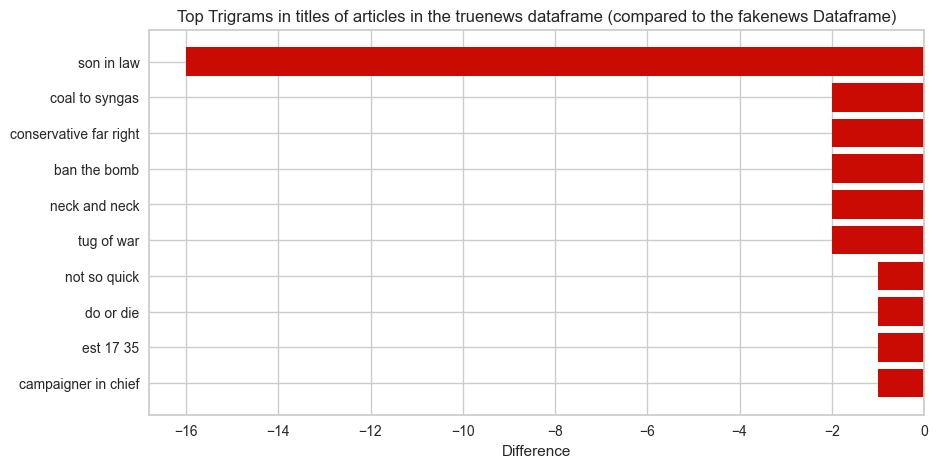

<IPython.core.display.Javascript object>

In [73]:
top_10_highest_title = sorted_differences_title[-10:]
top_10_lowest_title = sorted_differences_title[:10]

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_10_highest_title], [list(d.values())[0] for d in top_10_highest_title], color='g')
plt.xlabel('Difference')
plt.title('Top Trigrams in titles of articles in the fakenews dataframe (compared to the truenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 5))
plt.barh([list(d.keys())[0] for d in top_10_lowest_title], [list(d.values())[0] for d in top_10_lowest_title], color='r')
plt.xlabel('Difference')
plt.title('Top Trigrams in titles of articles in the truenews dataframe (compared to the fakenews Dataframe)')
plt.gca().invert_yaxis()
plt.show()

#### Finding top bigrams in each dataset

Top trigrams were identified in each dataset without reference to another dataset. 

In [74]:
top_trigrams_fakenews_txt = get_top_ngram(corpus_fakenews_txt, 3)[:10]
top_trigrams_truenews_txt = get_top_ngram(corpus_truenews_txt, 3)[:10]

top_trigrams_fakenews_title = get_top_ngram(corpus_fakenews_title, 3)[:10]
top_trigrams_truenews_title = get_top_ngram(corpus_truenews_title, 3)[:10]


<IPython.core.display.Javascript object>

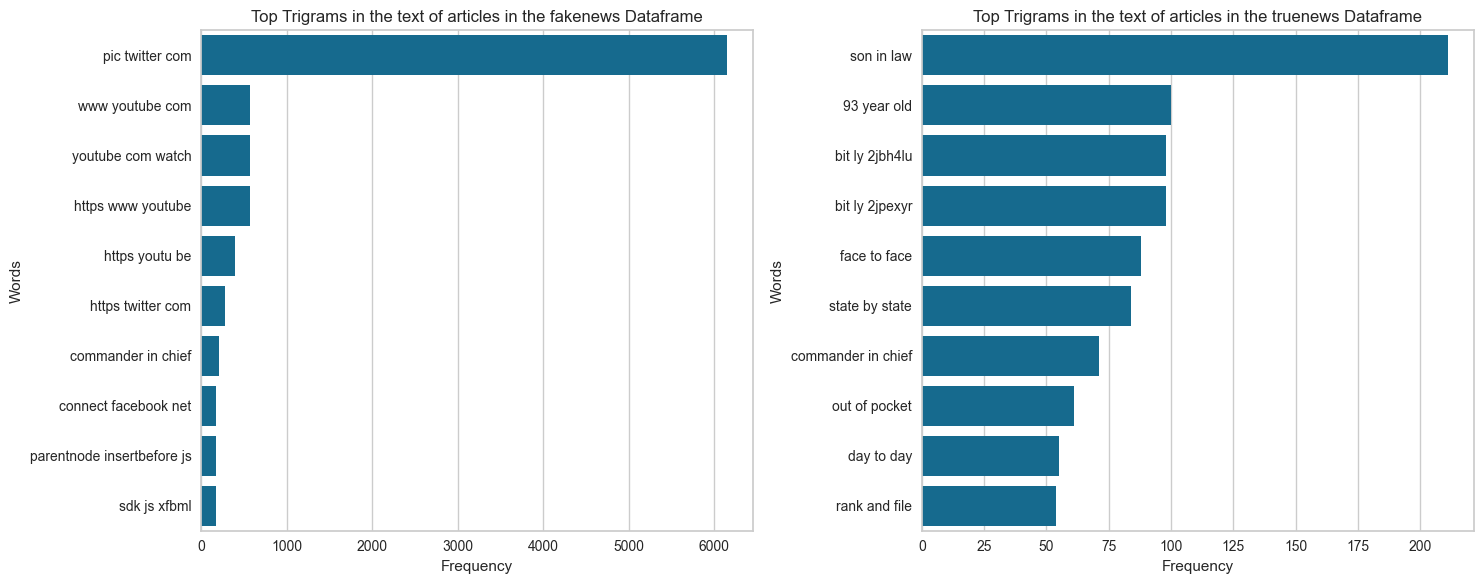

<IPython.core.display.Javascript object>

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_bigrams_barchart(
    top_trigrams_fakenews_txt,
    ax1,
    "Top Trigrams in the text of articles in the fakenews Dataframe",
)
plot_top_bigrams_barchart(
    top_trigrams_truenews_txt,
    ax2,
    "Top Trigrams in the text of articles in the truenews Dataframe",
)

plt.tight_layout()
plt.show()

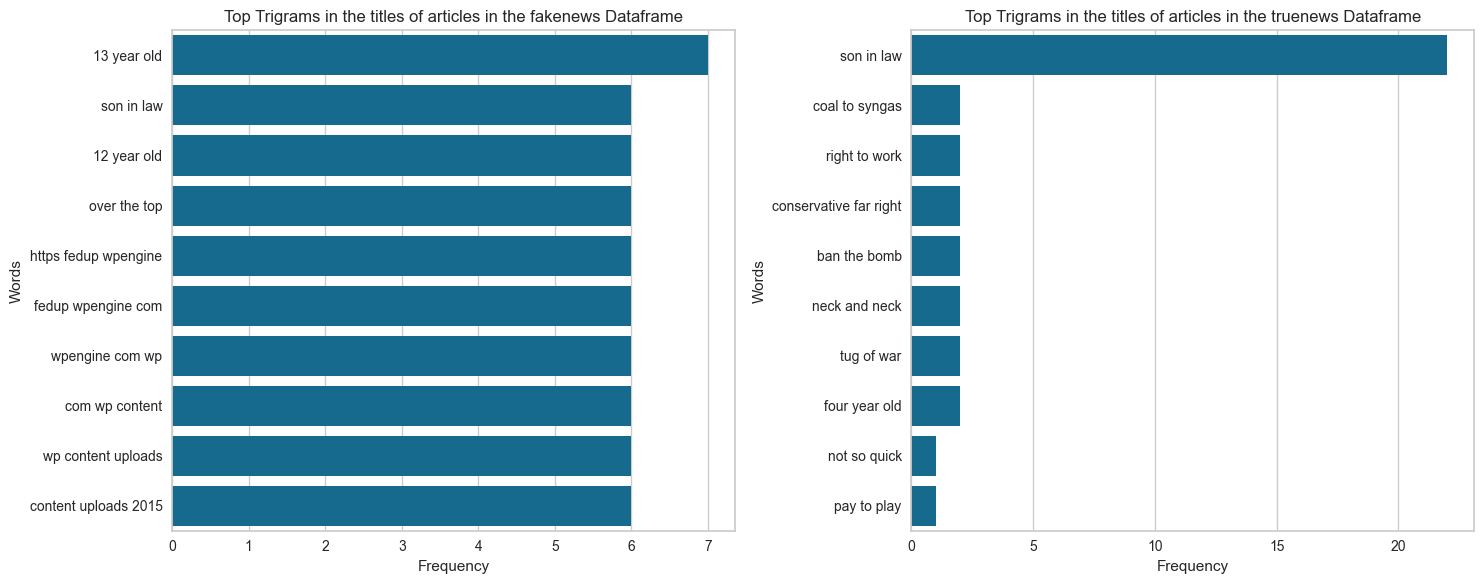

<IPython.core.display.Javascript object>

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

plot_top_bigrams_barchart(
    top_trigrams_fakenews_title,
    ax1,
    "Top Trigrams in the titles of articles in the fakenews Dataframe",
)
plot_top_bigrams_barchart(
    top_trigrams_truenews_title,
    ax2,
    "Top Trigrams in the titles of articles in the truenews Dataframe",
)

plt.tight_layout()
plt.show()

- By examining the most frequently used bigrams and trigrams in text and titles of news articles it can be observed that quite a lot of so-called fake articles provide references to twitter comments ar are twitter comments themselves (twitter com is the most frequenty used bigram in the fakenews dataset) or to YouTube videos (next most frequenly used trigrams). 
- Other distinguishing features of fake news articles are frequenly used bigrams 'anti trump', 'pro-trump', 'anti-american' which are either lesser used (ant-trump) or not present ('pro-trump', 'anti-american') among the the most frequenly used bigrams in the articles from the truenews dataset.
- Articles from the truenews dataset are distinguished by frequenly used bigram 'reuters ipsos'.

### LDA analysis

Latent Dirichlet Allocation (LDA) is an method used for topic modeling in the text. Each document is represented by the distribution of topics and each topic is represented by the distribution of words. The functions for preprocessing text and titles of articles in the fakenews and truenews datasets and the LDA analysis are adapted from here: https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [77]:
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<IPython.core.display.Javascript object>

In [78]:
def preprocess_comments(df: pd.DataFrame) -> list:
    """
    Preprocesses the comments in a given dataframe by removing stop words, 
    lemmatizing words, and tokenizing the text.

    Parameters:
        df (pd.DataFrame): A dataframe containing text to be preprocessed.

    Returns:
        corpus (list): A list of tokenized and lemmatized text.

    """
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for comment in df:
        words = [w for w in word_tokenize(comment) if (w not in stop)]

        words = [lem.lemmatize(w) for w in words if len(w) > 2]

        corpus.append(words)
    return corpus


<IPython.core.display.Javascript object>

Preprocessed corpuses of words in text and titles were created. 

In [79]:
corpus_fakenews_prep_txt = preprocess_comments(fakenews["text"])
corpus_truenews_prep_txt = preprocess_comments(truenews["text"])

<IPython.core.display.Javascript object>

In [80]:
corpus_fakenews_prep_title = preprocess_comments(fakenews["title"])
corpus_truenews_prep_title = preprocess_comments(truenews["title"])

<IPython.core.display.Javascript object>

Dictionaries were created. 

In [81]:
dic_fakenews_txt = gensim.corpora.Dictionary(corpus_fakenews_prep_txt)
bow_corpus_fakenews_txt = [
    dic_fakenews_txt.doc2bow(doc) for doc in corpus_fakenews_prep_txt
]
dic_truenews_txt = gensim.corpora.Dictionary(corpus_truenews_prep_txt)
bow_corpus_truenews_txt = [
    dic_truenews_txt.doc2bow(doc) for doc in corpus_truenews_prep_txt
]

<IPython.core.display.Javascript object>

In [82]:
dic_fakenews_title = gensim.corpora.Dictionary(corpus_fakenews_prep_title)
bow_corpus_fakenews_title = [
    dic_fakenews_title.doc2bow(doc) for doc in corpus_fakenews_prep_title
]
dic_truenews_title = gensim.corpora.Dictionary(corpus_truenews_prep_title)
bow_corpus_truenews_title = [
    dic_truenews_title.doc2bow(doc) for doc in corpus_truenews_prep_title
]

<IPython.core.display.Javascript object>

Th LDA analysis was conducted on the dictionaries. 

In [83]:
lda_model_fakenews_txt = gensim.models.LdaMulticore(
    bow_corpus_fakenews_txt,
    num_topics=4,
    id2word=dic_fakenews_txt,
    passes=10,
    workers=1,
)
lda_output_fakenews_txt = lda_model_fakenews_txt.show_topics()

lda_model_truenews_txt = gensim.models.LdaMulticore(
    bow_corpus_truenews_txt,
    num_topics=4,
    id2word=dic_truenews_txt,
    passes=10,
    workers=1,
)
lda_output_truenews_txt = lda_model_truenews_txt.show_topics()

<IPython.core.display.Javascript object>

In [84]:
lda_model_fakenews_title = gensim.models.LdaMulticore(
    bow_corpus_fakenews_title,
    num_topics=4,
    id2word=dic_fakenews_title,
    passes=10,
    workers=1,
)
lda_output_fakenews_title = lda_model_fakenews_title.show_topics()

lda_model_truenews_title = gensim.models.LdaMulticore(
    bow_corpus_truenews_title,
    num_topics=4,
    id2word=dic_truenews_title,
    passes=10,
    workers=1,
)
lda_output_truenews_title = lda_model_truenews_title.show_topics()

<IPython.core.display.Javascript object>

The top words in five topics in both fakenews and truenews dataframes were identified and plotted with the function visualize_lda_topics(). 

In [85]:
def visualize_lda_topics(lda_output: List[Tuple[int, str]]) -> None:
    """
    Visualize the topics generated by LDA (Latent Dirichlet Allocation) algorithm.

    Args:
        lda_output (list of tuples): The output of LDA algorithm, where each tuple
            contains the topic ID and the list of terms and their weights.

    Returns:
        None. The function plots a bar chart for each topic, showing the top 10 terms
        with the highest weights.

    Raises:
        TypeError: If the input argument is not a list of tuples.

    """
    if not isinstance(lda_output, list):
        raise TypeError("The input argument must be a list of tuples.")

    for topic_id, topic_terms in lda_output:
        terms_weights = [
            term_weight.split("*") for term_weight in topic_terms.split(" + ")
        ]
        terms, weights = zip(
            *[(term.strip('"'), float(weight)) for weight, term in terms_weights]
        )

        plt.figure(figsize=(10, 4))
        plt.barh(terms[:10][::-1], weights[:10][::-1], color="skyblue")
        plt.xlabel("Term Weight")
        plt.ylabel("Term")
        plt.title(f"Topic {topic_id + 1}")
        plt.gca().invert_yaxis()
        plt.show()

<IPython.core.display.Javascript object>

Topics in the text of articles in the fakenews dataset:


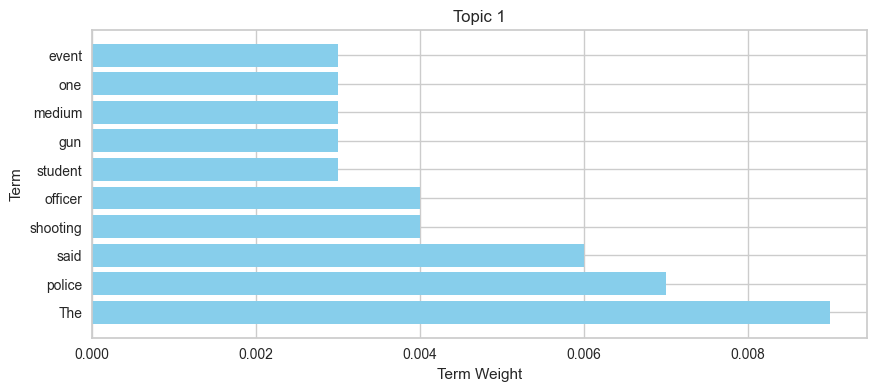

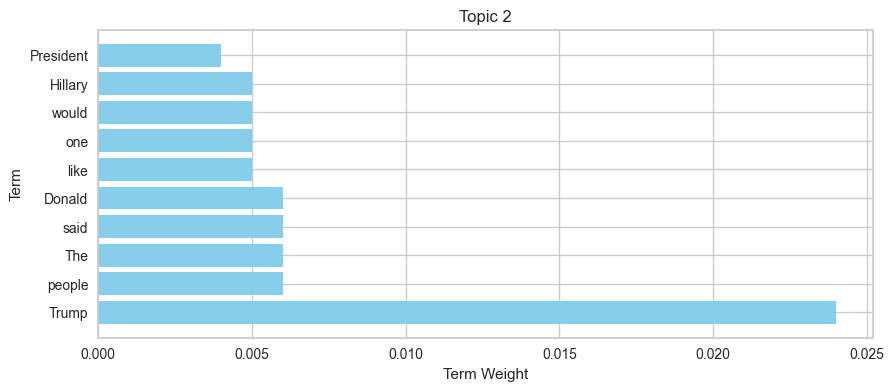

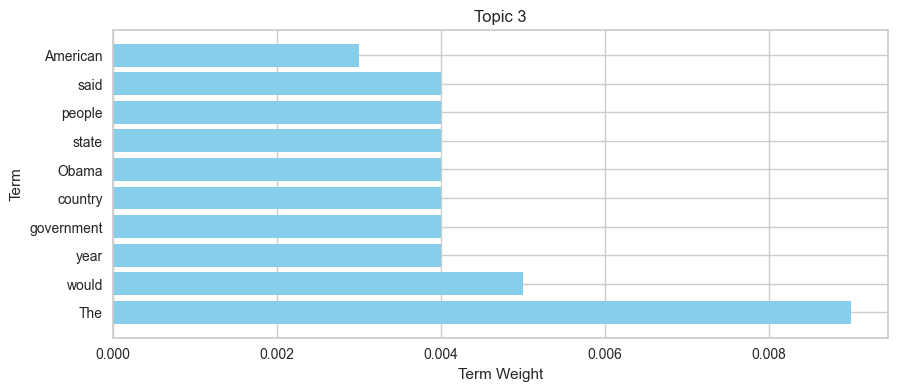

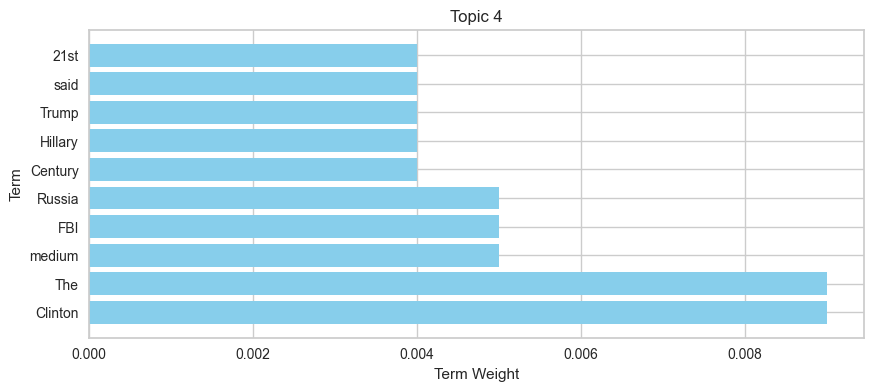

<IPython.core.display.Javascript object>

In [86]:
print("Topics in the text of articles in the fakenews dataset:")
visualize_lda_topics(lda_output_fakenews_txt)

Topics in the titles of articles in the fakenews dataset:


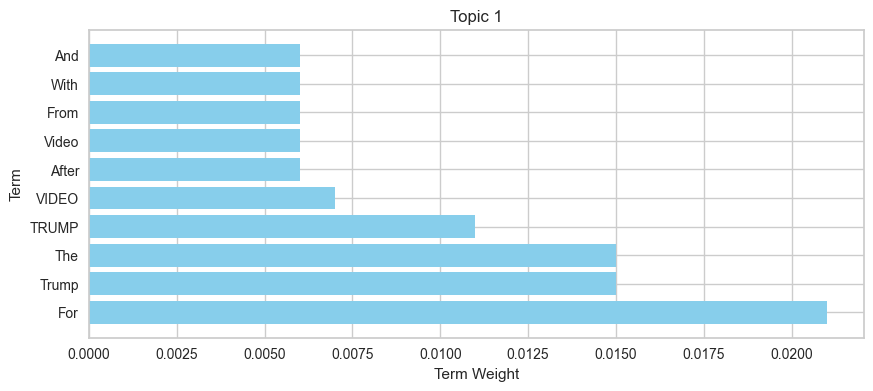

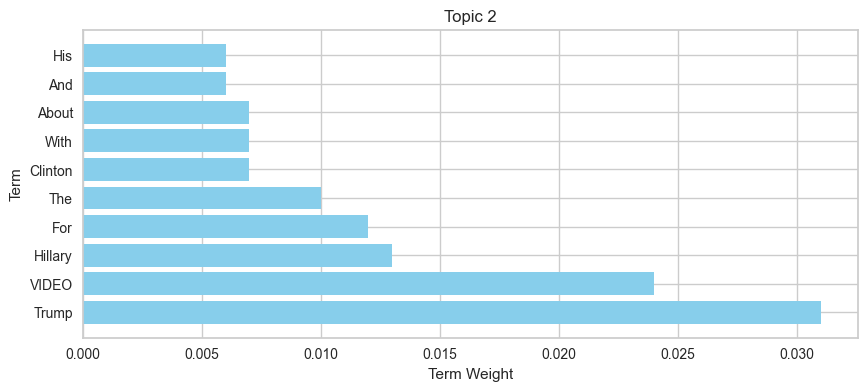

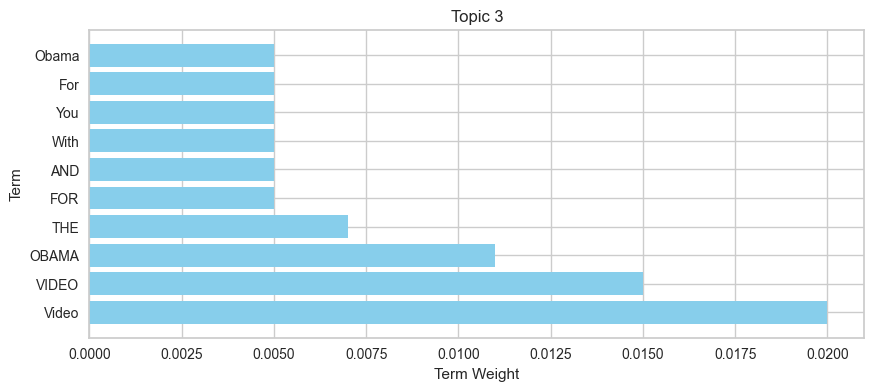

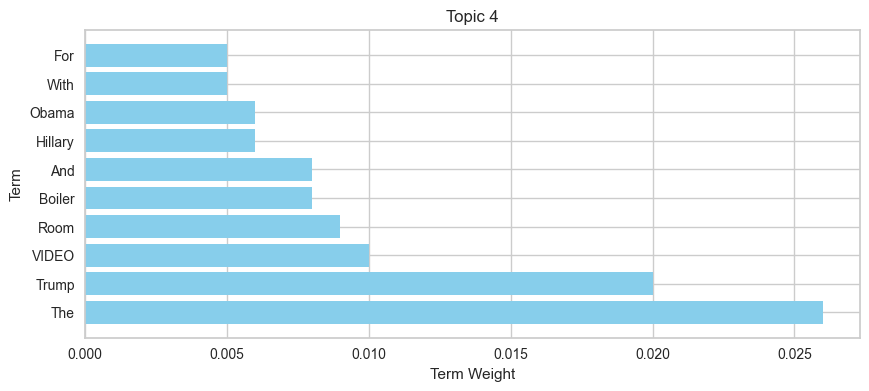

<IPython.core.display.Javascript object>

In [87]:
print("Topics in the titles of articles in the fakenews dataset:")
visualize_lda_topics(lda_output_fakenews_title)

Topics in the text of articles in the truenews dataset:


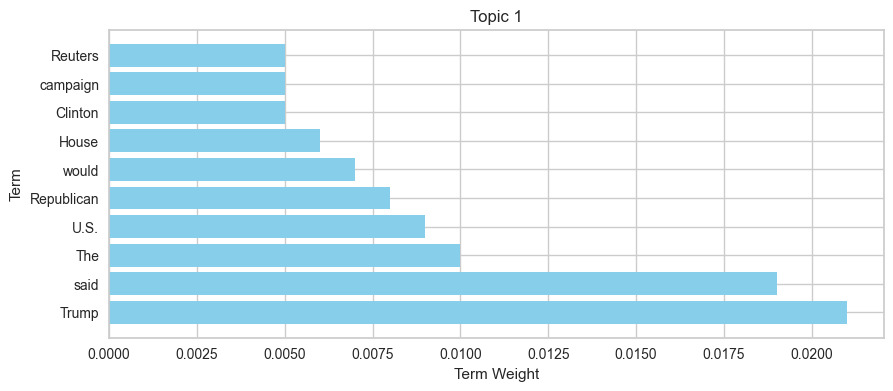

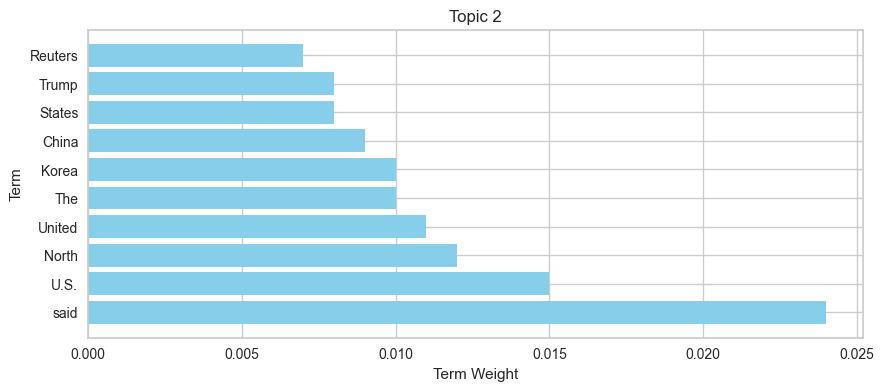

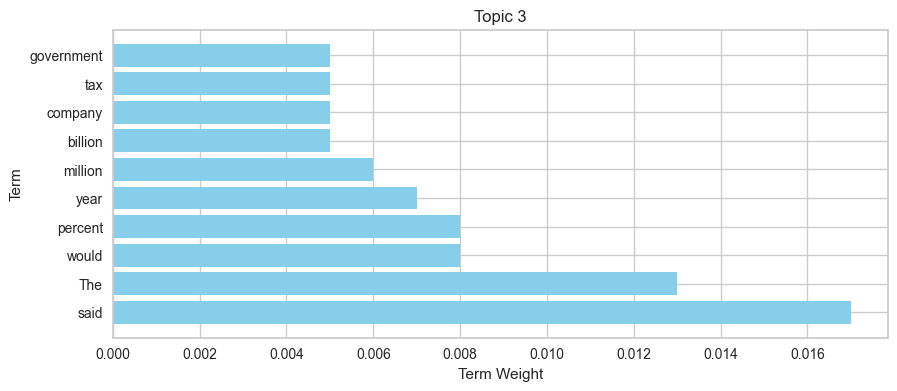

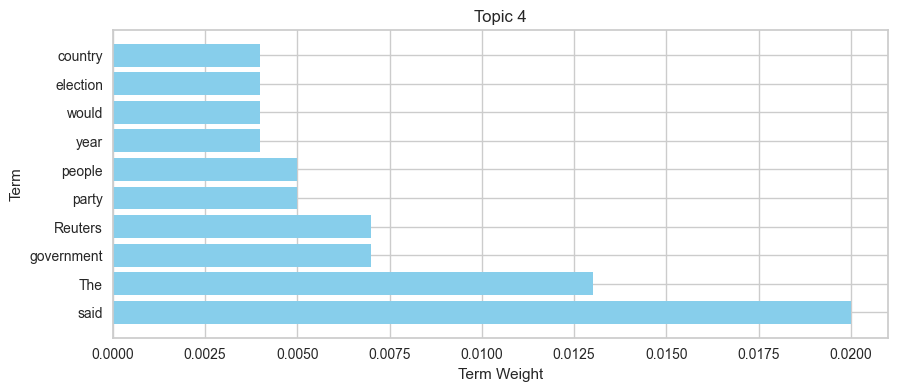

<IPython.core.display.Javascript object>

In [88]:
print("Topics in the text of articles in the truenews dataset:")
visualize_lda_topics(lda_output_truenews_txt)

Topics in the text of titles in the fakenews dataset:


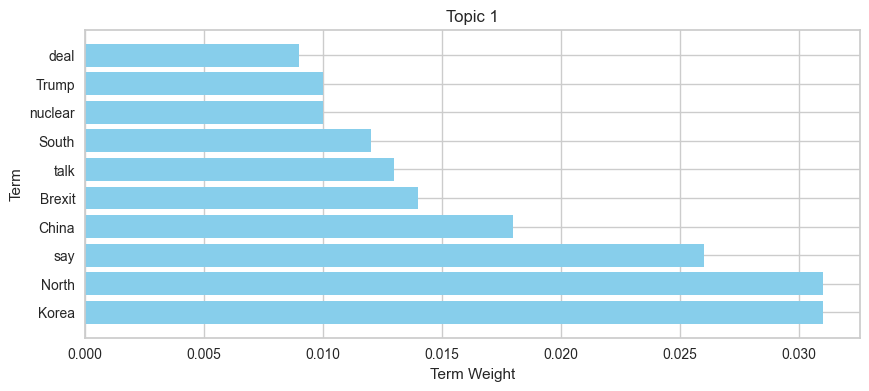

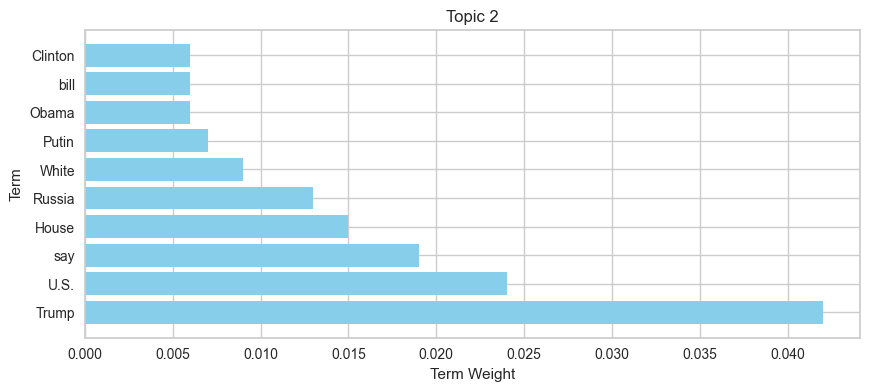

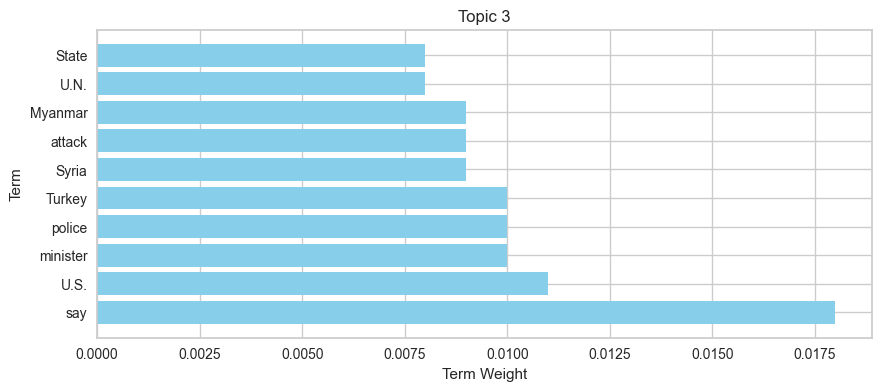

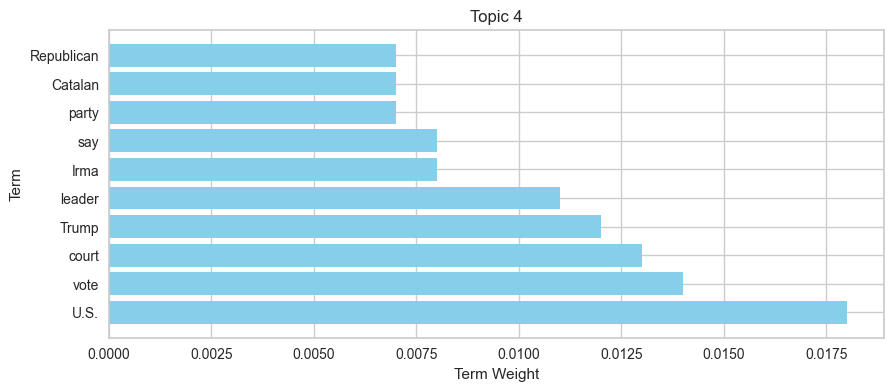

<IPython.core.display.Javascript object>

In [89]:
print("Topics in the text of titles in the fakenews dataset:")
visualize_lda_topics(lda_output_truenews_title)

By analysing the topics and the most frequently used words in the topics, the following observations can be made:
- the topics in text and titles of articles of the fakenews dataset refer to the US foreign policy (Topic 1, text), police (Topic 2, text), FBI investigation of emails of Hillary Clinton (Topic 3, text), Donald Trump and Hillary Clinton (Topic 4, text; Topic 1, 2, 3, title), Trump (Topic 4, title).
- the topics in text and titles of articles of the truenews dataset refer to varrious issues of the US foreign and domestic policy, and not particularly to personalities or scandals.

### Sentiment analysis

Next, sentiments of text and titles of the news articles are analysed by using the TextBlob library. The functions for identifying and plotting polarity of text and titles are created and run on both fakenews and truenews datarames. 

In [56]:
def polarity(text: str) -> float:
    """
    Calculates the polarity of a given text using the TextBlob library.

    Args:
        text (str): The text to be analyzed.

    Returns:
        float: The polarity of the text, which is a value between -1 and 1.
    """
    return TextBlob(text).sentiment.polarity

<IPython.core.display.Javascript object>

In [57]:
fakenews["text_polarity_score"] = fakenews["text"].apply(lambda x: polarity(x))
truenews["text_polarity_score"] = truenews["text"].apply(lambda x: polarity(x))
fakenews["title_polarity_score"] = fakenews["title"].apply(lambda x: polarity(x))
truenews["title_polarity_score"] = truenews["title"].apply(lambda x: polarity(x))

<IPython.core.display.Javascript object>

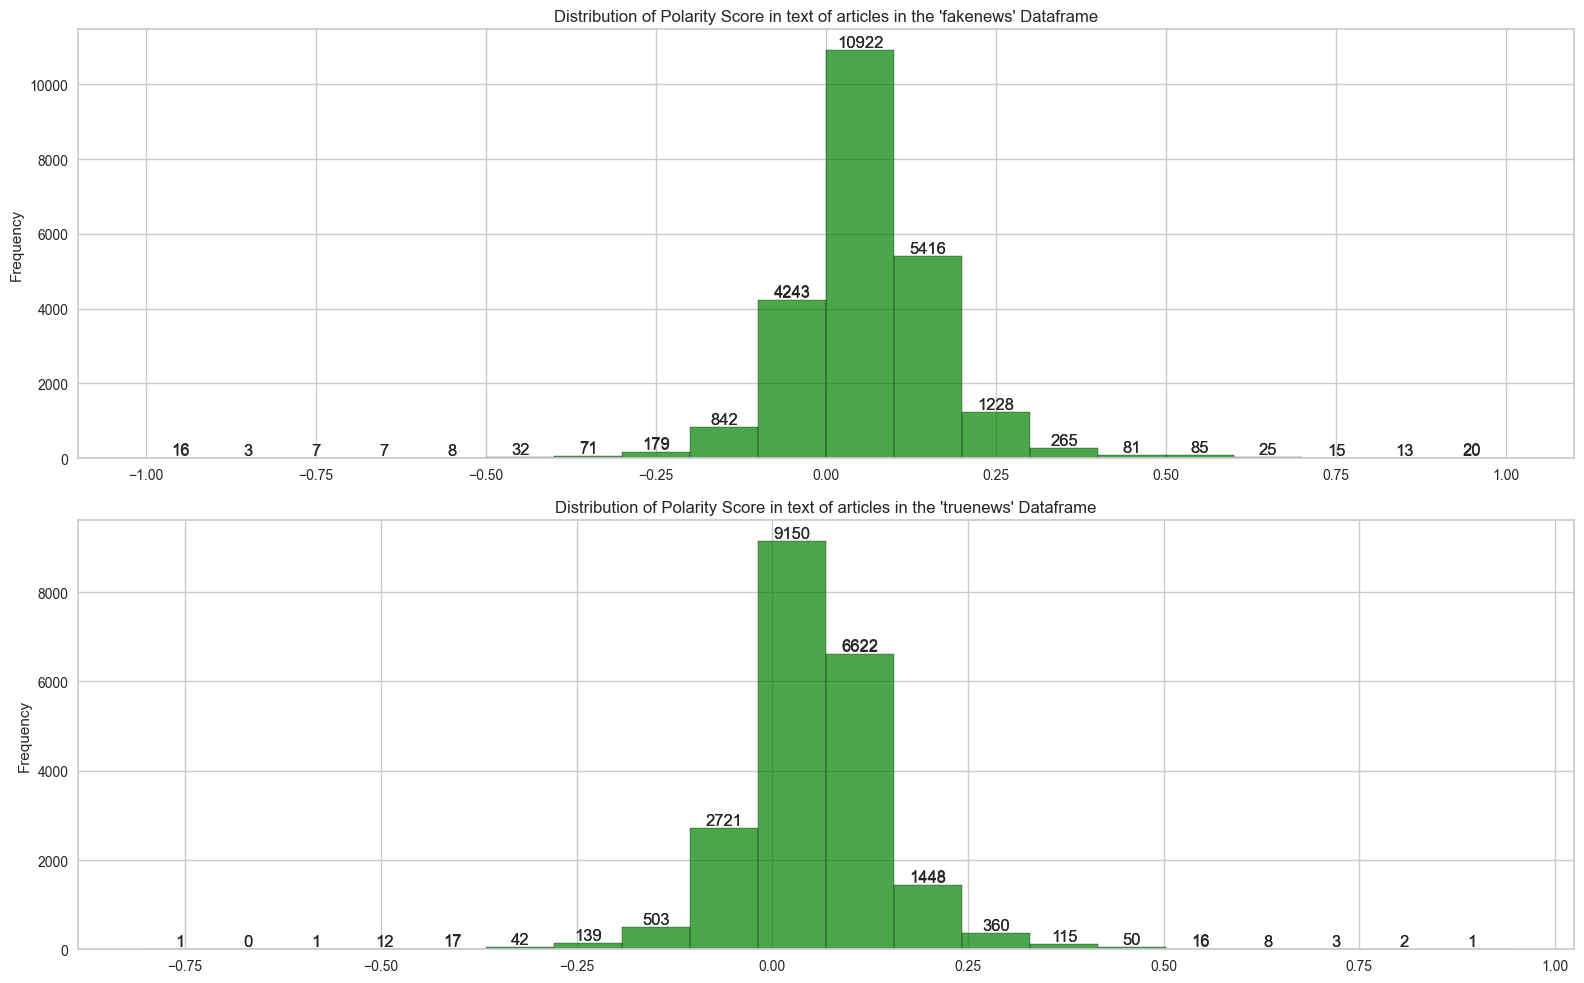

<IPython.core.display.Javascript object>

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_counts_hist(
    fakenews["text_polarity_score"],
    bins=20,
    ax=ax1,
    title="Distribution of Polarity Score in text of articles in the 'fakenews' Dataframe",
)
plot_counts_hist(
    truenews["text_polarity_score"],
    bins=20,
    ax=ax2,
    title="Distribution of Polarity Score in text of articles in the 'truenews' Dataframe",
)

plt.tight_layout()

plt.show()

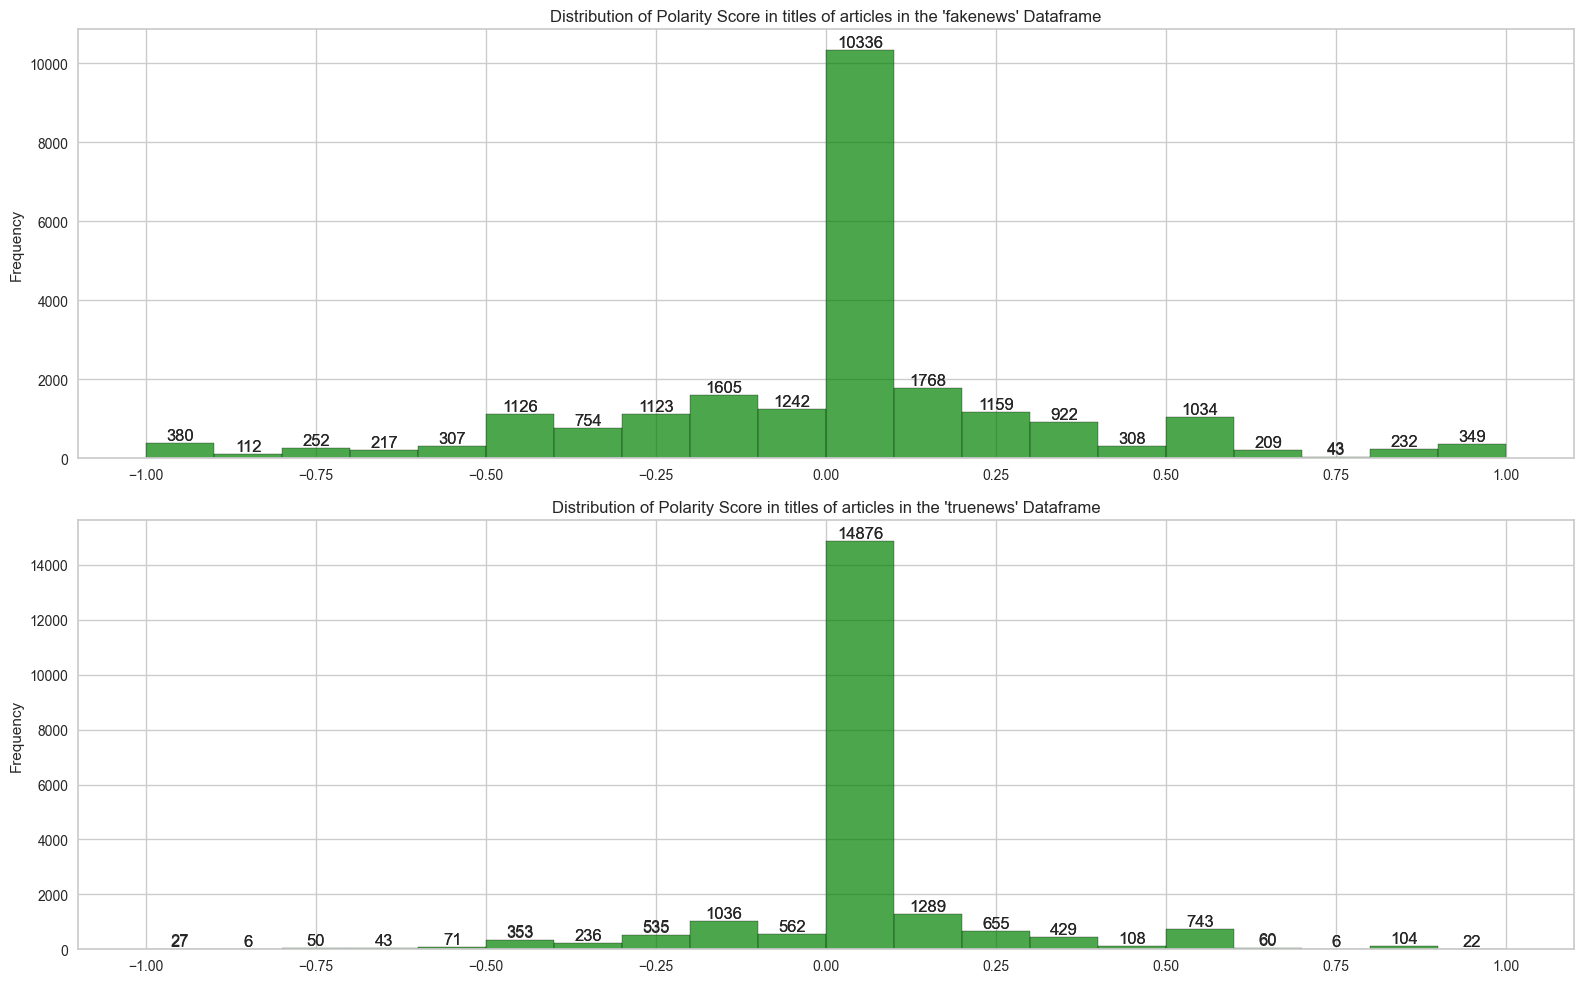

<IPython.core.display.Javascript object>

In [59]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

plot_counts_hist(
    fakenews["title_polarity_score"],
    bins=20,
    ax=ax1,
    title="Distribution of Polarity Score in titles of articles in the 'fakenews' Dataframe",
)
plot_counts_hist(
    truenews["title_polarity_score"],
    bins=20,
    ax=ax2,
    title="Distribution of Polarity Score in titles of articles in the 'truenews' Dataframe",
)

plt.tight_layout()

plt.show()

The functions for grouping polarity in to positive, neutral and negative grours and plotting the distributions of groups are created and run.

In [60]:
def sentiment(x: int) -> str:
    """
    Returns the sentiment of a given number.

    Parameters:
    x (int): The number to be evaluated.

    Returns:
    str: The sentiment of the given number. Can be 'neg' (negative), 'neu' (neutral), or 'pos' (positive).
    """
    if x < 0:
        return "neg"
    elif x == 0:
        return "neu"
    else:
        return "pos"

<IPython.core.display.Javascript object>

In [61]:
fakenews["text_polarity"] = fakenews["text_polarity_score"].map(lambda x: sentiment(x))
truenews["text_polarity"] = truenews["text_polarity_score"].map(lambda x: sentiment(x))
fakenews["title_polarity"] = fakenews["title_polarity_score"].map(
    lambda x: sentiment(x)
)
truenews["title_polarity"] = truenews["title_polarity_score"].map(
    lambda x: sentiment(x)
)

<IPython.core.display.Javascript object>

In [62]:
def plot_counts_bar(df: pd.DataFrame, ax: plt.Axes, title: str) -> None:
    """
    Plots a bar graph of the counts in a given dataframe.

    Parameters:
        df (pd.DataFrame): The dataframe containing the counts to be plotted.
        ax (plt.Axes): The axes to plot the bar graph on.
        title (str): The title of the plot.

    Returns:
        None: This function does not return anything, it only plots the graph.

    """
    ax.bar(df.index, df.values, color="blue", alpha=0.7)

    ax.set_xlabel("")
    ax.set_ylabel("Frequency")
    ax.set_title(title)

    for x, y in zip(df.index, df.values):
        ax.text(x, y, str(int(y)), ha="center", va="bottom", fontsize=10)

<IPython.core.display.Javascript object>

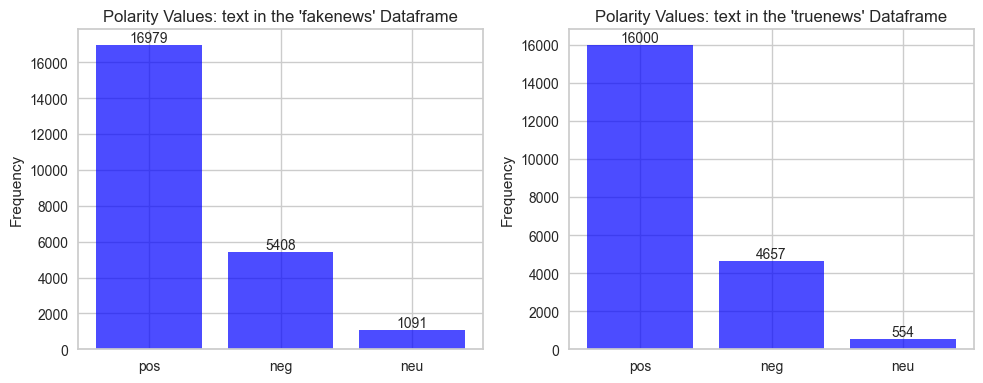

<IPython.core.display.Javascript object>

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_counts_bar(
    fakenews["text_polarity"].value_counts(),
    ax=ax1,
    title="Polarity Values: text in the 'fakenews' Dataframe",
)
plot_counts_bar(
    truenews["text_polarity"].value_counts(),
    ax=ax2,
    title="Polarity Values: text in the 'truenews' Dataframe",
)

plt.tight_layout()

plt.show()

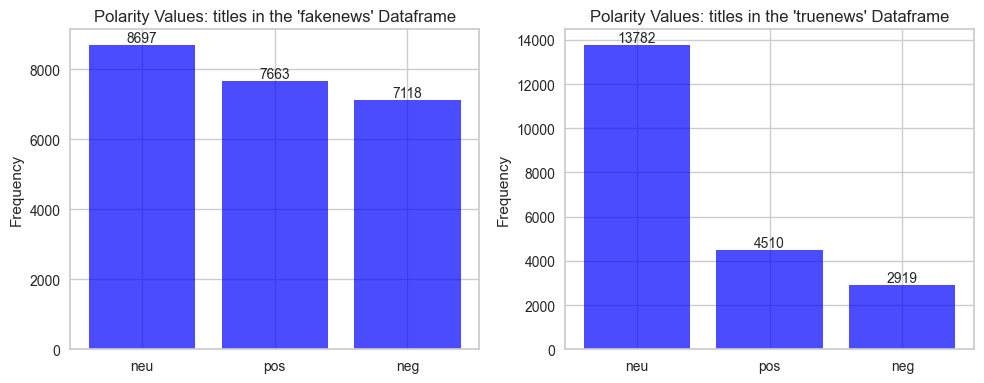

<IPython.core.display.Javascript object>

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plot_counts_bar(
    fakenews["title_polarity"].value_counts(),
    ax=ax1,
    title="Polarity Values: titles in the 'fakenews' Dataframe",
)
plot_counts_bar(
    truenews["title_polarity"].value_counts(),
    ax=ax2,
    title="Polarity Values: titles in the 'truenews' Dataframe",
)

plt.tight_layout()

plt.show()

An analysis of polarity and sentiment categories within the text and titles of news articles reveals:

- The distributions of polarity scores and sentiment categories in the texts of both fake and real news articles are strikingly similar, with a higher proportion of articles being classified as positive rather than neutral or negative.
- A significantly greater proportion of articles in the 'fakenews' dataset have titles that are either strongly positive or negative compared to those in the 'truenews' dataset. This suggests that a characteristic feature of 'fake' news articles is their use of emotionally charged titles, either positive or negative, to engage and attract the audience.

## Preparing the dataset for modeling

After the examination of differences between news articles in fakenews and truenews datasets, another task of exploratory analysis is to prepare the dataset that could be used for modelling. The following steps will be implemented to complete this task: 

1. stopwords will be removed from text and titles of articles in the concatenated dataset;
2. vectorization function will be applied to create datasets of vectors representing importances of words in text and titles;
3. dataframes for text and title word vectors in the approapriate format will be created from these datasets;
4. dataframes will be concatenated into a single dataset.

### Removing stopwords

In [77]:
def remove_stopwords(text: str) -> str:
    """
    Function to remove stopwords from a given text.

    Args:
    text (str): The text from which to remove the stopwords.

    Returns:
    str: The text with the stopwords removed.
    """
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stopwords]
    return " ".join(filtered_text)

<IPython.core.display.Javascript object>

New columns with removed stopwords from text and titles are added to the news dataset. 

In [130]:
news["text_no_stopwords"] = news["text"].apply(remove_stopwords)
news["title_no_stopwords"] = news["title"].apply(remove_stopwords)

<IPython.core.display.Javascript object>

#### Calculating importance of words in news articles

In [78]:
def vectorize_text(max_features: int, data: List[str]) -> Tuple[List[float], List[str]]:
    """
    Function that takes in a specified max number of features to be extracted from the text data and
    vectorizes the text data into a tf-idf matrix.

    Args:
    max_features (int): The maximum number of features to be extracted from the text data.
    data (List[str]): A list of text strings to be vectorized.

    Returns:
    Tuple[List[float], List[str]]: A tuple where the first element is a list of lists where each
    sublist is a dense list representation of each text string's tf-idf scores, and the second element
    is a list of the feature names extracted by the `TfidfVectorizer`.
    """
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(data)

    feature_names = vectorizer.get_feature_names_out()
    dense = tfidf_matrix.todense()
    denselist = dense.tolist()
    return denselist, feature_names

<IPython.core.display.Javascript object>

Lists containing vectors and the words for both text and titles were created (maximum words from a text is set to 400).

In [132]:
denselist_title, feature_names_title = vectorize_text(400, news["title_no_stopwords"])
denselist_text, feature_names_text = vectorize_text(400, news["text_no_stopwords"])

<IPython.core.display.Javascript object>

A dictionary including info from the news dataframe (titles, subjects and news_status of articles) and from the lists of vectors was created. 

In [133]:
news = news.reset_index(drop=True)
tfidf_scores = []
for article, title, text, subject, status in zip(news['title_no_stopwords'], 
                                denselist_title, 
                                denselist_text, 
                                news["subject"], 
                                news["news_status"]):
    word_importance_title = {word: round(score, 3) for word, score in 
                             zip(feature_names_title, title) if score > 0}
    word_importance_text = {word: round(score, 3) for word, score in 
                            zip(feature_names_text, text) if score > 0}
    tfidf_scores.append({'title': article, 
                         'Title Word Importance': word_importance_title,
                        'Text Word Importance': word_importance_text,
                        'subject': subject,
                        'news_status': status})


<IPython.core.display.Javascript object>

### Building the dataframe for modelling

Lists containing info from the keys ands values of the vector dictionary and columns 'subject' and 'news_status' from the news dataframe are created separately for titles and texts. 

In [134]:
df_text_list = []
for dict, (index, row) in zip(tfidf_scores, news.iterrows()):
    df = pd.DataFrame(dict).transpose()
    df_mod = pd.DataFrame(df.iloc[2, :])
    df_mod.columns = [f"{index}"]
    df_mod = df_mod.transpose()
    if not df.empty:
        df_mod["subject"] = df.iloc[3, 0]
        df_mod["news_status"] = df.iloc[4, 0]
    else:
        df_mod["subject"] = None
        df_mod["news_status"] = None
    df_text_list.append(df_mod)

<IPython.core.display.Javascript object>

In [135]:
df_title_list = []
for dict, (index, row) in zip(tfidf_scores, news.iterrows()):
    df = pd.DataFrame(dict).transpose()
    df_mod = pd.DataFrame(df.iloc[1, :])
    df_mod.columns = [f"{index}"]
    df_mod = df_mod.transpose()
    if not df.empty:
        df_mod["subject"] = df.iloc[3, 0]
        df_mod["news_status"] = df.iloc[4, 0]
    else:
        df_mod["subject"] = None
        df_mod["news_status"] = None
    df_title_list.append(df_mod)

<IPython.core.display.Javascript object>

Data from the lists are divided into batches of 100 and the batches were concatenated in dataframes by looping over the  whole lists; the dataframes were appended into lists of dataframes. 

In [79]:
def divide_into_batches(df_list: List[pd.DataFrame], batch_size: int) -> Generator:
    """
    This function divides a list of DataFrames into batches of a specified size.

    Args:
        df_list (List[DataFrame]): list of DataFrames to divide into batches.
        batch_size (int): size of each batch.

    Yields:
        Generator: generator which will yield batches of DataFrames.

    """
    for i in range(0, len(df_list), batch_size):
        yield df_list[i : i + batch_size]

<IPython.core.display.Javascript object>

In [138]:
batched_dfs_text = []
for batch in divide_into_batches(df_text_list, 100):
    concatenated_batch = pd.concat(batch, axis=0).fillna(0)
    batched_dfs_text.append(concatenated_batch)


<IPython.core.display.Javascript object>

In [139]:
batched_dfs_title = []
for batch in divide_into_batches(df_title_list, 100):
    concatenated_batch = pd.concat(batch, axis=0).fillna(0)
    batched_dfs_title.append(concatenated_batch)


<IPython.core.display.Javascript object>

The dataframes in lists of dataframes for text and titles were concatenated into two dataframes (one for text, another for titles). Missing values were recoded to 0.

In [140]:
news_text_df = pd.concat(batched_dfs_text, axis=0).fillna(0)

<IPython.core.display.Javascript object>

In [141]:
news_title_df = pd.concat(batched_dfs_title, axis=0).fillna(0)

<IPython.core.display.Javascript object>

To avoid creating identical columns, 'subject' and 'news_status' columns were removed from the text dataframe (as they were also included into the title dataframe). 

In [142]:
news_text_df = news_text_df.drop(columns=["subject", "news_status"])

<IPython.core.display.Javascript object>

Columns were renamed by adding substring containing the word which was vectorized. 

In [80]:
def rename_columns_add_substring(df: pd.DataFrame, substring: str) -> pd.DataFrame:
    """
    Adds a given substring to the beginning of each column name in the dataframe.

    Args:
        df (pd.DataFrame): an input dataframe whose columns need to be renamed.
        substring (str): a string to be added at the beginning of each column name.

    Returns:
        pd.DataFrame: an output dataframe with renamed columns.
    """
    new_column_names = {col: substring + col for col in df.columns}
    return df.rename(columns=new_column_names)

<IPython.core.display.Javascript object>

In [144]:
news_text_renamed = rename_columns_add_substring(news_text_df, "text_")
news_title_renamed = rename_columns_add_substring(news_title_df, "title_")

<IPython.core.display.Javascript object>

The text and title dataframes were concatenated by columns into the final dataframe  containing information about vectors of words in titles and text of news articles which will be used for modelling.

In [145]:
final_df = pd.concat([news_title_renamed, news_text_renamed], axis=1)

<IPython.core.display.Javascript object>

Bellow is the info about the dataframe. The dataframe contains 1150 columns (a column for each word in text and titles of news articles) and 44898 rows, each representing a news article, and values representing vectors of word importance in each news article. If some word is not present in a title or text of an article the zero value is given for that word in the article.

In [146]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 44688
Columns: 1146 entries, title_donald to text_catalan
dtypes: float64(1081), int64(64), object(1)
memory usage: 391.1+ MB


<IPython.core.display.Javascript object>

In [147]:
final_df.head()

title_donald  title_message  title_new  title_trump  title_year  \
0         0.449          0.584      0.388        0.196       0.518   
1         0.000          0.000      0.000        0.253       0.000   
2         0.000          0.000      0.000        0.000       0.000   
3         0.000          0.000      0.000        0.281       0.000   
4         0.643          0.000      0.000        0.281       0.000   

   title_2016  title_america  title_american  title_americans  title_change  \
0         0.0            0.0             0.0              0.0           0.0   
1         0.0            0.0             0.0              0.0           0.0   
2         0.0            0.0             0.0              0.0           0.0   
3         0.0            0.0             0.0              0.0           0.0   
4         0.0            0.0             0.0              0.0           0.0   

   ...  text_yr  text_brexit  text_boom  text_exclusive  text_leftist  \
0  ...      0.0          0.0        0.0             0.0           0.0   
1  ...      0.0          0.0        0.0             0.0           0.0   
2  ...      0.0          0.0        0.0             0.0           0.0   
3  ...      0.0          0.0        0.0             0.0           0.0   
4  ...      0.0          0.0        0.0             0.0           0.0   

   text_boiler  text_factbox  text_myanmar  text_rohingya  text_catalan  
0          0.0           0.0           0.0            0.0           0.0  
1          0.0           0.0           0.0            0.0           0.0  
2          0.0           0.0           0.0            0.0           0.0  
3          0.0           0.0           0.0            0.0           0.0  
4          0.0           0.0           0.0            0.0           0.0  

[5 rows x 1146 columns]

<IPython.core.display.Javascript object>

Articles with missing subject information were removed from the dataframe.

In [148]:
final_df = final_df[final_df["title_subject"] != 0]

<IPython.core.display.Javascript object>

The dataframe was saved as a csv file and loaded from the file for the further use in the modeling stage of the project. 

In [149]:
final_df.to_csv("final_df.csv")

<IPython.core.display.Javascript object>

In [16]:
final_df = pd.read_csv("final_df.csv")

<IPython.core.display.Javascript object>

## 2. Machine learning

In this stage the dataset of importance vectors with columns representing different words are included in  titles and text of news articles and rows representing news article was used for training machine learning models (classifiers). 

First, the heuristic model was set to choose features for modelling .

### Heuristic model

The heuristic model has the rules:
- features should be selected by selecting to 100 most frequently used words from text of each dataset and 50 frequently used words from text of each dataset;
- the columns such as text_reuters",
        "title_video",
        "title_watch",
        "text_via",
        "text_featured",
        "text_pic",
        "text_com",
        "text_https",
        "text_twitter",
        "text_the",
        "text_said",
        "text_says",
        "text_image" should be removed due to their impact on information leakage - from the results of exploratory analysis it is assumed that these words in titles and text of articles have decisive impact on prediction of articles as fake or true.

The selection code is presented below.

In [81]:
words_fakenews_txt = [list(d)[0] for d in sorted_differences_words_txt_lower[-100:]]
words_truenews_txt = [list(d)[0] for d in sorted_differences_words_txt_lower[:100]]

words_fakenews_title = [list(d)[0] for d in sorted_differences_words_title_lower[-50:]]
words_truenews_title = [list(d)[0] for d in sorted_differences_words_title_lower[:50]]

<IPython.core.display.Javascript object>

In [82]:
filtered_columns_fake_txt = [col for col in final_df.columns if col.startswith('text_') and any(word in col for word in words_fakenews_txt)]
filtered_columns_true_txt = [col for col in final_df.columns if col.startswith('text_') and any(word in col for word in words_truenews_txt)]

filtered_columns_fake_title = [col for col in final_df.columns if col.startswith('text_') and any(word in col for word in words_fakenews_title)]
filtered_columns_true_title = [col for col in final_df.columns if col.startswith('text_') and any(word in col for word in words_truenews_title)]

<IPython.core.display.Javascript object>

In [83]:
final_df_selected = final_df[filtered_columns_fake_txt+filtered_columns_true_txt+filtered_columns_fake_title+filtered_columns_true_title]


<IPython.core.display.Javascript object>

Duplicates of column names were removed. 

In [84]:
final_df_selected = final_df_selected.loc[:,~final_df_selected.columns.duplicated()]


<IPython.core.display.Javascript object>

In [85]:
final_df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44688 entries, 0 to 44687
Columns: 229 entries, text_donald to text_brexit
dtypes: float64(229)
memory usage: 78.1 MB


<IPython.core.display.Javascript object>

The modelling will be conducted both on dataset filtered by both heuristic rules and on the dataset filtered by only the second heuristic rule (removal of leakage words).

### 1. Modelling based on only the second heuristic rule

### Spliting the data into training, validation, and test datasets

First, the data were split into feature variables and a target variable and several variables were removed to prevent the classifiers to depend entirely on these words (the word 'reuters' was removed because it is included into text of almost every truenews article; the words 'video', 'watch' is included in a high number of fakenews articles; the word 'twitter' was included into text of fakenews articles.) Also, the column containg subject information was removed for in the potential use of the trained models in real-life situations the subject of the article would not necessarily be known.

Then th dataset was split into training, validation testing datasets with the proportion of 70 percent of data allocated for training, 15 percent for validation, and 15 percent for test purposes. 

In [86]:
X = final_df.drop(
    [
        "title_news_status",
        "text_reuters",
        "title_subject",
        "title_video",
        "title_watch",
        "text_via",
        "text_featured",
        "text_pic",
        "text_com",
        "text_https",
        "text_twitter",
        "Unnamed: 0",
        "text_the",
        "text_said",
        "text_says",
        "text_image",
    ],
    axis=1,
)
y = final_df["title_news_status"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


<IPython.core.display.Javascript object>

### Building machine learning pipelines

Next task was to build pipelines for data preprocessing. As the data were already preprocessed, the pipeline was made from a single passthrough step. 

In [87]:
features_to_leave_unprocessed = X.columns


<IPython.core.display.Javascript object>

Preprocessor was created grouping pipelines transforming categorical and numerical variables. 

In [88]:
preprocessor = ColumnTransformer(
    transformers=[
        ("passthrough", "passthrough", features_to_leave_unprocessed),
    ]
)

<IPython.core.display.Javascript object>

Various classifiers which will be used for modelling were included into a list of classifiers.

In [89]:
classifiers = [
   
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=42),
    BaggingClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    SVC(random_state=42),
    GradientBoostingClassifier(random_state=42),
    xg.XGBClassifier(random_state=42),
   ]


<IPython.core.display.Javascript object>

Also, the list of model names was created. 

In [90]:
model_name_list = [type(classifier).__name__ for classifier in classifiers]


<IPython.core.display.Javascript object>

#### Running the machine learning pipeline

The function for fitting the pipelines, predicting y values on validation or test datasets, plotting confusion matrixes and presenting classification reports, saving metrics in the dictionary was created. 

In [91]:
def score_model(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_val: pd.DataFrame,
    y_val: pd.DataFrame,
    estimator: BaseEstimator,
    preprocessor: TransformerMixin,
    df: pd.DataFrame,
    models_list: List[BaseEstimator],
    classes: List[str],
    size: float,
    features: int,
    **kwargs: Any,
) -> BaseEstimator:
    """
    This function fits and scores a model, and updates a list of models and a dataframe with metrics.

    :returns: The fitted model.
    """
    # Model fitting and prediction:
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("selectKBest", SelectKBest(score_func=mutual_info_classif, k=features)),
            ("classifier", estimator),
        ]
    )

    model = pipeline.fit(x_train, y_train)
    prediction = model.predict(x_val)

    # Metrics:
    f1 = f1_score(y_val, prediction, average="macro").round(5)
    prec = precision_score(y_val, prediction, average="macro").round(5)
    rec = recall_score(y_val, prediction, average="macro").round(5)
    acc_sq = accuracy_score(y_val, prediction).round(5)
    report = classification_report(y_val, prediction, target_names=classes)
    roc_auc = roc_auc_score(y_val, prediction).round(5)
    pr_auc = average_precision_score(y_val, prediction).round(5)

    # Prints:
    print(estimator.__class__.__name__)

    fig = plt.figure(figsize=(5, 4))
    cm = ConfusionMatrix(
        model, classes=classes, label_encoder={0: "True news", 1: "Fake news"}
    )
    cm.fit(x_train, y_train)
    cm.score(x_val, y_val)
    cm.show()
    print("Classification Report:")
    print(report)
    print(f"Accuracy score: {acc_sq}")
    print(f"Average F1 score: {f1}")
    print(f"ROC-AUC score: {roc_auc}")
    print(f"PR-AUC score: {pr_auc}")
    print("")

    # Appends:
    models_list.append(model)

    df["model_name"].append(f"{estimator.__class__.__name__}")
    df["a_score"].append(acc_sq)
    df["f1_score"].append(f1)
    df["precision_score"].append(prec)
    df["recall_score"].append(rec)
    df["ROC_AUC_score"].append(roc_auc)
    df["PR_AUC_score"].append(pr_auc)
    return model

<IPython.core.display.Javascript object>

The function was run on all classifiers presented in the list of classifiers.

RandomForestClassifier


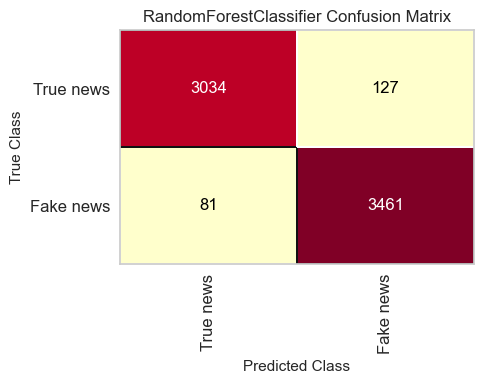

Classification Report:
              precision    recall  f1-score   support

   True news       0.97      0.96      0.97      3161
   Fake news       0.96      0.98      0.97      3542

    accuracy                           0.97      6703
   macro avg       0.97      0.97      0.97      6703
weighted avg       0.97      0.97      0.97      6703

Accuracy score: 0.96897
Average F1 score: 0.96884
ROC-AUC score: 0.96848
PR-AUC score: 0.95463

AdaBoostClassifier


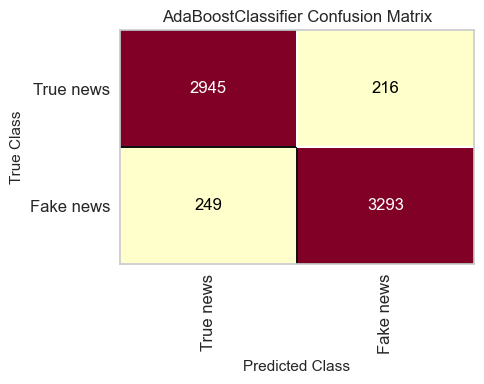

Classification Report:
              precision    recall  f1-score   support

   True news       0.92      0.93      0.93      3161
   Fake news       0.94      0.93      0.93      3542

    accuracy                           0.93      6703
   macro avg       0.93      0.93      0.93      6703
weighted avg       0.93      0.93      0.93      6703

Accuracy score: 0.93063
Average F1 score: 0.93044
ROC-AUC score: 0.93068
PR-AUC score: 0.90962

GaussianNB


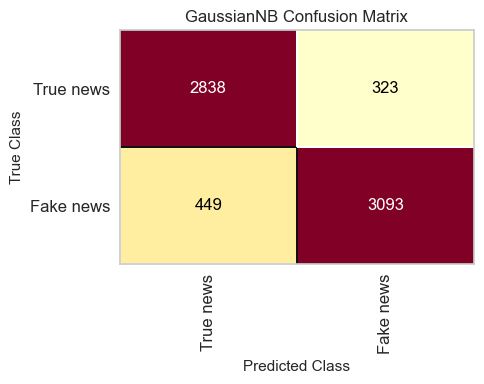

Classification Report:
              precision    recall  f1-score   support

   True news       0.86      0.90      0.88      3161
   Fake news       0.91      0.87      0.89      3542

    accuracy                           0.88      6703
   macro avg       0.88      0.89      0.88      6703
weighted avg       0.89      0.88      0.88      6703

Accuracy score: 0.88483
Average F1 score: 0.88466
ROC-AUC score: 0.88553
PR-AUC score: 0.85765

LogisticRegression


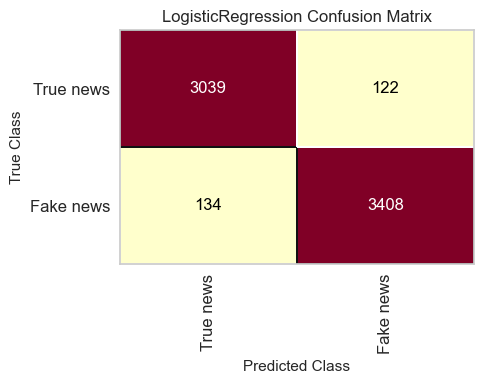

Classification Report:
              precision    recall  f1-score   support

   True news       0.96      0.96      0.96      3161
   Fake news       0.97      0.96      0.96      3542

    accuracy                           0.96      6703
   macro avg       0.96      0.96      0.96      6703
weighted avg       0.96      0.96      0.96      6703

Accuracy score: 0.96181
Average F1 score: 0.96169
ROC-AUC score: 0.96179
PR-AUC score: 0.94891

BaggingClassifier


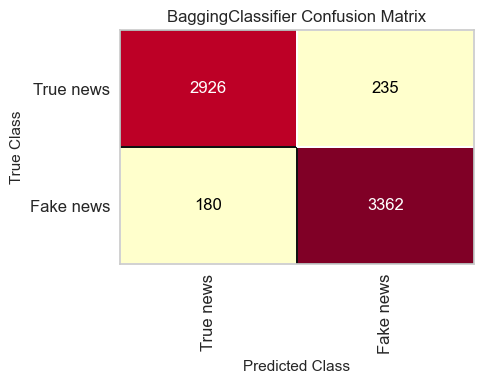

Classification Report:
              precision    recall  f1-score   support

   True news       0.94      0.93      0.93      3161
   Fake news       0.93      0.95      0.94      3542

    accuracy                           0.94      6703
   macro avg       0.94      0.94      0.94      6703
weighted avg       0.94      0.94      0.94      6703

Accuracy score: 0.93809
Average F1 score: 0.93782
ROC-AUC score: 0.93742
PR-AUC score: 0.91402

ExtraTreesClassifier


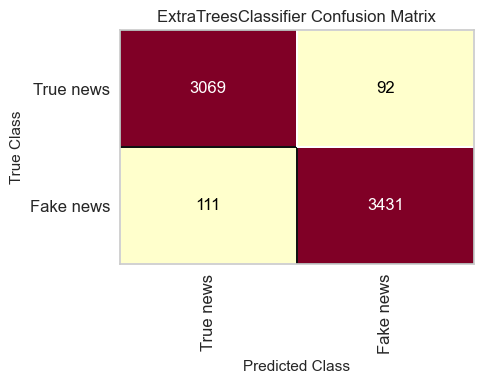

Classification Report:
              precision    recall  f1-score   support

   True news       0.97      0.97      0.97      3161
   Fake news       0.97      0.97      0.97      3542

    accuracy                           0.97      6703
   macro avg       0.97      0.97      0.97      6703
weighted avg       0.97      0.97      0.97      6703

Accuracy score: 0.96972
Average F1 score: 0.96963
ROC-AUC score: 0.96978
PR-AUC score: 0.95993

SVC


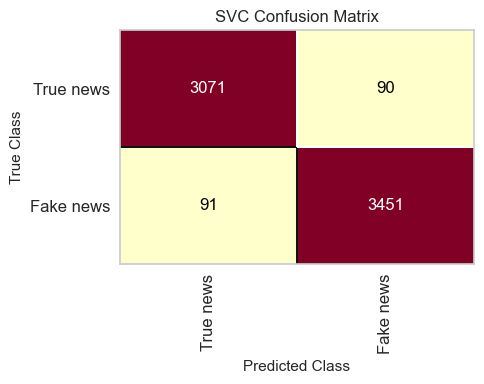

Classification Report:
              precision    recall  f1-score   support

   True news       0.97      0.97      0.97      3161
   Fake news       0.97      0.97      0.97      3542

    accuracy                           0.97      6703
   macro avg       0.97      0.97      0.97      6703
weighted avg       0.97      0.97      0.97      6703

Accuracy score: 0.973
Average F1 score: 0.97291
ROC-AUC score: 0.97292
PR-AUC score: 0.96312

GradientBoostingClassifier


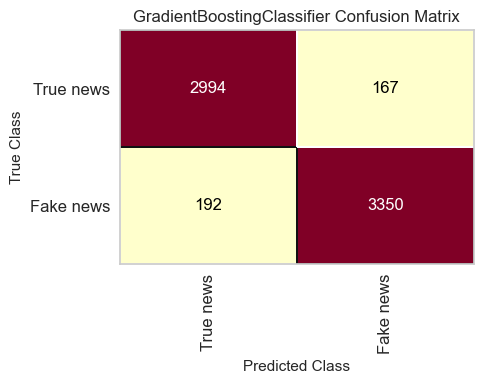

Classification Report:
              precision    recall  f1-score   support

   True news       0.94      0.95      0.94      3161
   Fake news       0.95      0.95      0.95      3542

    accuracy                           0.95      6703
   macro avg       0.95      0.95      0.95      6703
weighted avg       0.95      0.95      0.95      6703

Accuracy score: 0.94644
Average F1 score: 0.94629
ROC-AUC score: 0.94648
PR-AUC score: 0.92953

XGBClassifier


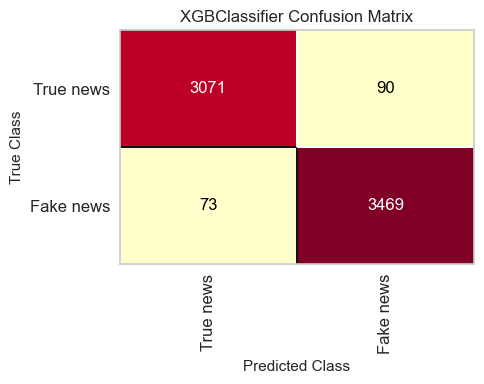

Classification Report:
              precision    recall  f1-score   support

   True news       0.98      0.97      0.97      3161
   Fake news       0.97      0.98      0.98      3542

    accuracy                           0.98      6703
   macro avg       0.98      0.98      0.98      6703
weighted avg       0.98      0.98      0.98      6703

Accuracy score: 0.97568
Average F1 score: 0.9756
ROC-AUC score: 0.97546
PR-AUC score: 0.96551



<IPython.core.display.Javascript object>

In [479]:
classes = ["True news", "Fake news"]
size = (200, 100)
models_list = []
scores = {}
scores["model_name"] = []
scores["a_score"] = []
scores["f1_score"] = []
scores["precision_score"] = []
scores["recall_score"] = []
scores["ROC_AUC_score"] = []
scores["PR_AUC_score"] = []

for classifier in classifiers:
    score_model(
        X_train,
        y_train,
        X_val,
        y_val,
        classifier,
        preprocessor,
        scores,
        models_list,
        classes,
        size,
        "all",
    )

In [258]:
scores = pd.DataFrame(scores).sort_values("f1_score", ascending=False)
scores = scores.set_index("model_name")
scores

a_score  f1_score  precision_score  recall_score  \
model_name                                                                     
ExtraTreesClassifier        0.95927   0.95914          0.95918       0.95910   
XGBClassifier               0.95674   0.95659          0.95665       0.95653   
RandomForestClassifier      0.95644   0.95627          0.95662       0.95597   
SVC                         0.94868   0.94853          0.94839       0.94868   
GradientBoostingClassifier  0.92764   0.92744          0.92729       0.92761   
LogisticRegression          0.92615   0.92592          0.92587       0.92597   
BaggingClassifier           0.92585   0.92560          0.92568       0.92552   
AdaBoostClassifier          0.91467   0.91446          0.91419       0.91485   
GaussianNB                  0.86857   0.86835          0.86809       0.86905   

                            ROC_AUC_score  PR_AUC_score  
model_name                                               
ExtraTreesClassifier              0.95910       0.94445  
XGBClassifier                     0.95653       0.94093  
RandomForestClassifier            0.95597       0.93865  
SVC                               0.94868       0.93214  
GradientBoostingClassifier        0.92761       0.90525  
LogisticRegression                0.92597       0.90245  
BaggingClassifier                 0.92552       0.90106  
AdaBoostClassifier                0.91485       0.89063  
GaussianNB                        0.86905       0.83728

<IPython.core.display.Javascript object>

In [481]:
for model in models_list:
    joblib.dump(model, f"model_news_status{models_list.index(model)}.joblib")

<IPython.core.display.Javascript object>

In [482]:
# scores = pd.DataFrame(scores).set_index("model_name")
scores.to_csv("scores_news.csv")

<IPython.core.display.Javascript object>

In [205]:
def plot_bars(data: pd.DataFrame, y: str, y_label: str, title: str) -> None:
    """
    Plots a bar chart using the provided data.

    Args:
        data (pd.DataFrame): The data to plot.
        y (str): The name of the column in 'data' to use for the y-values.
        y_label (str): The label for the y-axis.
        title (str): The title of the plot.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(
        x=data.index, y=y, data=data, errorbar="sd", color=sns.color_palette()[0]
    ).set(title=title)
    plt.xticks(rotation=90)
    ax.bar_label(ax.containers[0])
    ax.set_ylabel(y_label)
    ax.set_xlabel("")
    plt.show()

<IPython.core.display.Javascript object>

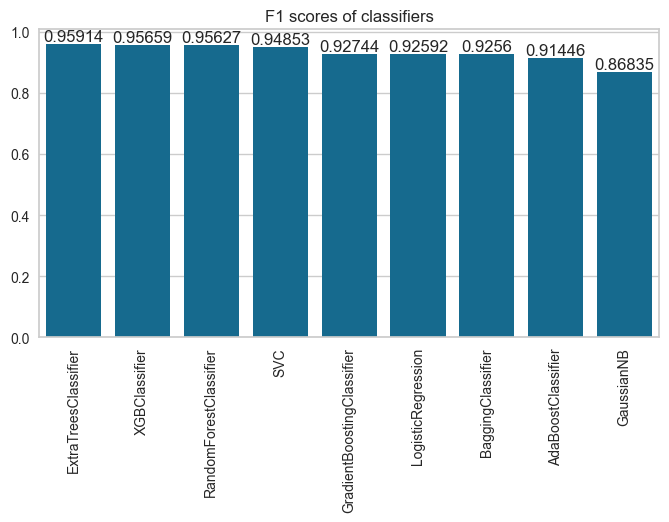

<IPython.core.display.Javascript object>

In [259]:
plot_bars(scores, "f1_score", "", "F1 scores of classifiers")

It can be observed that all the classifiers provided excellent prediction results. The best performance was achieved by the XGboost classifier (accuracy score 0.986, f1 score 0.986).

#### Feature importances

In order to better understand which features contributed to these prediction results, feature importances of for selected decision-tree-type classifiers were examined.

Initially, the data were preprocessed. 

In [92]:
preprocessor.fit(X)
X_pipe = pd.DataFrame(preprocessor.transform(X))
X_pipe_train = pd.DataFrame(preprocessor.transform(X_train))
X_pipe_val = pd.DataFrame(preprocessor.transform(X_val))
X_pipe_test = pd.DataFrame(preprocessor.transform(X_test))

<IPython.core.display.Javascript object>

In [93]:
X_pipe.columns = list(preprocessor.get_feature_names_out())

<IPython.core.display.Javascript object>

Feature importances were calculated for ensemble classifiers.

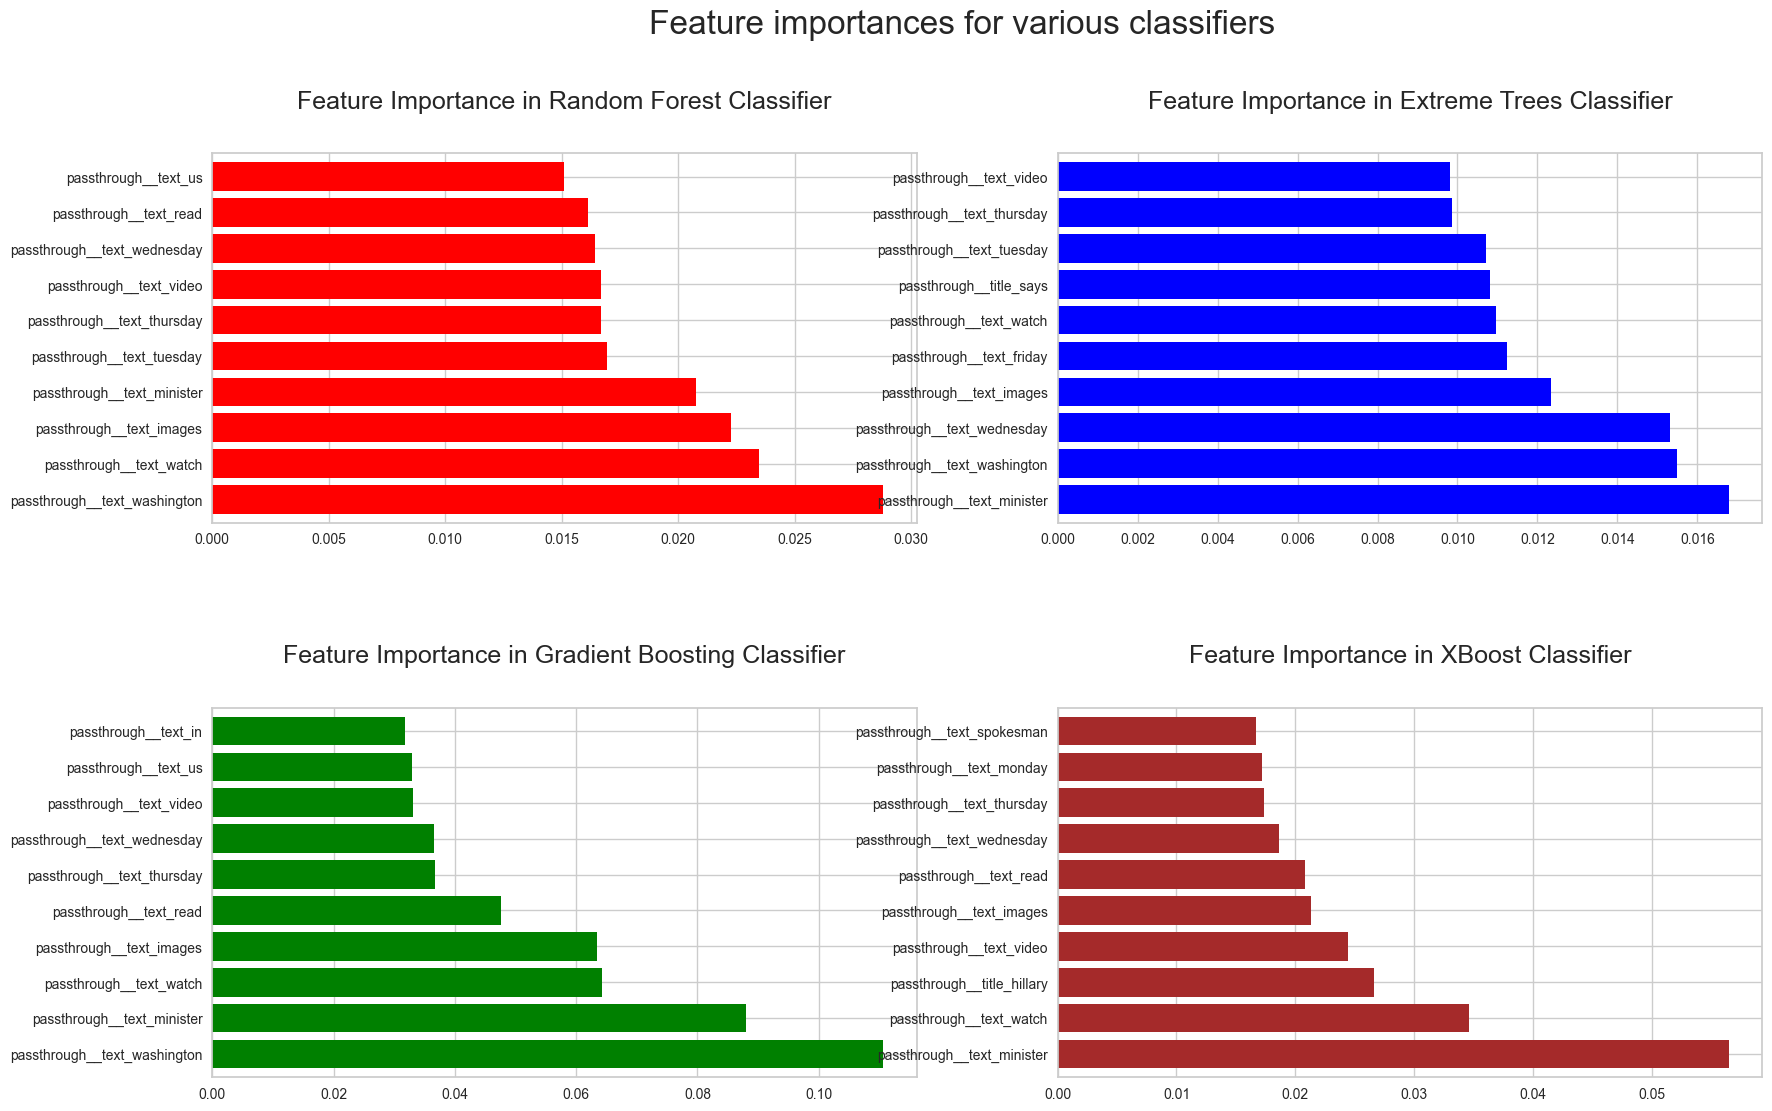

<IPython.core.display.Javascript object>

In [103]:
indices = [0, 5, 7, 8]
models_new = [models_list[index] for index in indices]
model_name_list_new = [
    "Random Forest Classifier",
    "Extreme Trees Classifier",
    "Gradient Boosting Classifier",
    "XBoost Classifier",
]
color_list = ["red", "blue", "green", "brown"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Feature importances for various classifiers", fontsize=24, y=1)

for model, ax, model_name in zip(models_new, axs.ravel(), model_name_list_new):
    pd.Series(model[-1].feature_importances_, X_pipe.columns).sort_values(
        ascending=False
    ).head(10).plot.barh(width=0.8, ax=ax, color=color_list[models_new.index(model)])
    ax.set_title(
        f"Feature Importance in {model_name}",
        fontsize=18,
        y=1.1,
    )
    ax.set_xlabel("")

plt.show()

It can be observed that words "com", 'minister', 'watch','https','images''video', 'pic', 'spokesman','know' are the words in text of articles that have the highest importance, 'hillary' is the word in titles of articles that is one of 10 most important words determining the performance of classifier. 

It has to be noted that such words as 'reuters', 'said', 'featured', 'via', 'image', 'the', 'twitter' (from text), 'video', 'watch' (from titles) had been already removed from the initial dataset after the previous rounds of model training, when it was noticed that these words have the decisive impact of the classifiers' ability to predict if news articles are fake or real (that is, with these words the classifiers achieved almost 100 percent accuracy).

### Feature importance analysis by Shap values

Another approach to feature selection is by using shap values which indicate feature importances as it is provided by the shap library. The SHAP values analysis was conducted in the initial round of machine learning (with broader list of features). However, in later stages this analysis was not conducted due to the limited time resources (it took long time to calculate SHAP values).

In [ ]:
explainer_list = []
shap_values_list = []
indices = [0,5,7,8]
models_new = [models_list[index] for index in indices]

for model in models_new:
    explainer = shap.TreeExplainer(model.steps[-1][1])
    shap_values = explainer.shap_values(X_val, check_additivity=False)
    shap_values_list.append(shap_values)
    explainer_list.append(explainer)


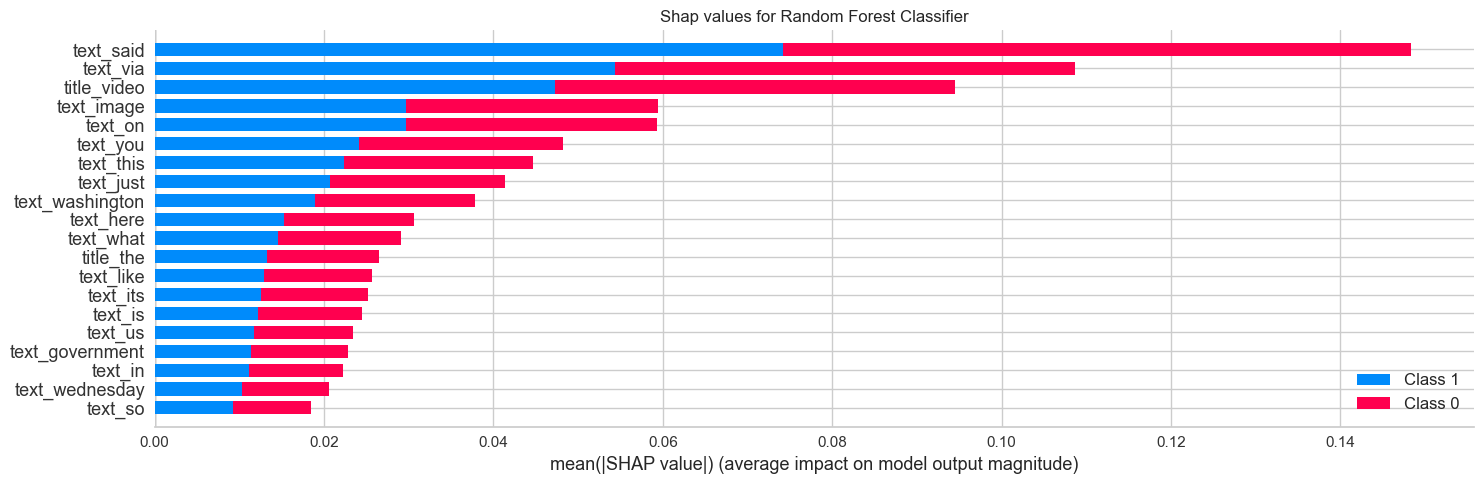

<IPython.core.display.Javascript object>

In [606]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.title(f"Shap values for {model_list[0]}", fontsize=12)
plt.xlabel("")
plt.ylabel("")

shap.summary_plot(
    shap_values_list[0],
    features=X_pipe_val,
    feature_names=X_val.columns,
    plot_size=None,
    show=False,
)


### 2. Modelling based on both heuristic rules

### Spliting the data into training, validation, and test datasets

First, the data were split into feature variables and a target variable and several variables were removed to prevent the classifiers to depend entirely on these words (the word 'reuters' was removed because it is included into text of almost every truenews article; the words 'video', 'watch' is included in a high number of fakenews articles; the word 'twitter' was included into text of fakenews articles.) Also, the column containg subject information was removed for in the potential use of the trained models in real-life situations the subject of the article would not necessarily be known.

Then th dataset was split into training, validation testing datasets with the proportion of 70 percent of data allocated for training, 15 percent for validation, and 15 percent for test purposes. 

In [96]:
len(final_df_selected.columns)

229

<IPython.core.display.Javascript object>

In [97]:
X_s = final_df_selected.drop(
    [
        "text_reuters",
        "text_via",
        "text_said",
        "text_says",
        "text_image"
    ],
    axis=1,
)
y_s = final_df["title_news_status"]

X_train_s, X_temp_s, y_train_s, y_temp_s = train_test_split(X_s, y_s, test_size=0.3, random_state=42)
X_val_s, X_test_s, y_val_s, y_test_s = train_test_split(X_temp_s, y_temp_s, test_size=0.5, random_state=42)


<IPython.core.display.Javascript object>

### Building machine learning pipelines

Next task was to build pipelines for data preprocessing. As the data were already preprocessed, the pipeline was made from a single passthrough step. 

In [98]:
features_to_leave_unprocessed = X_s.columns


<IPython.core.display.Javascript object>

Preprocessor was created grouping pipelines transforming categorical and numerical variables. 

In [99]:
preprocessor = ColumnTransformer(
    transformers=[
        ("passthrough", "passthrough", features_to_leave_unprocessed),
    ]
)

<IPython.core.display.Javascript object>

Preprocessor was created grouping pipelines transforming categorical and numerical variables. 

#### Running the machine learning pipeline

The function for fitting the pipelines, predicting y values on validation or test datasets, plotting confusion matrixes and presenting classification reports, saving metrics in the dictionary was created. 

The function was run on all classifiers presented in the list of classifiers.

RandomForestClassifier


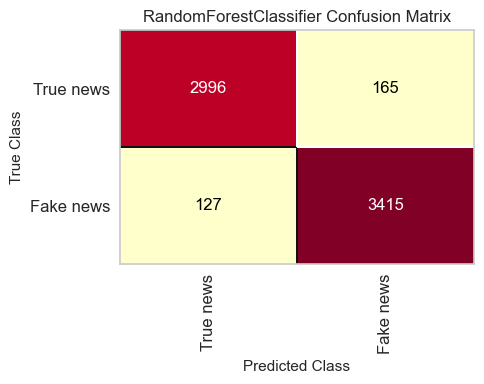

Classification Report:
              precision    recall  f1-score   support

   True news       0.96      0.95      0.95      3161
   Fake news       0.95      0.96      0.96      3542

    accuracy                           0.96      6703
   macro avg       0.96      0.96      0.96      6703
weighted avg       0.96      0.96      0.96      6703

Accuracy score: 0.95644
Average F1 score: 0.95627
ROC-AUC score: 0.95597
PR-AUC score: 0.93865

AdaBoostClassifier


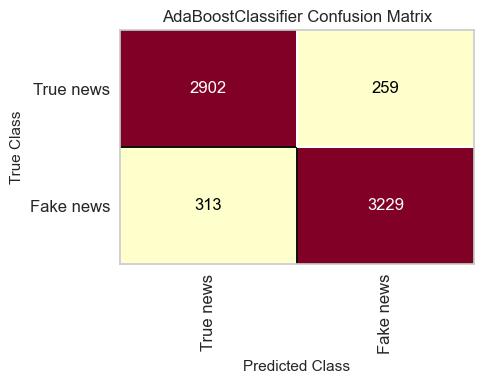

Classification Report:
              precision    recall  f1-score   support

   True news       0.90      0.92      0.91      3161
   Fake news       0.93      0.91      0.92      3542

    accuracy                           0.91      6703
   macro avg       0.91      0.91      0.91      6703
weighted avg       0.91      0.91      0.91      6703

Accuracy score: 0.91467
Average F1 score: 0.91446
ROC-AUC score: 0.91485
PR-AUC score: 0.89063

GaussianNB


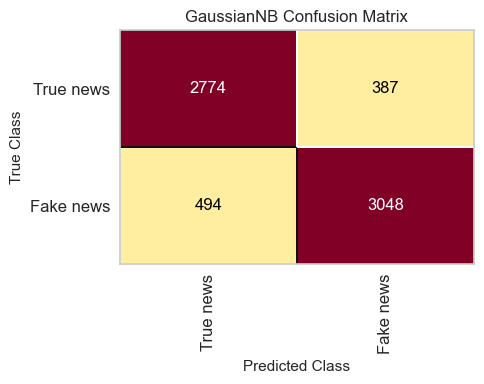

Classification Report:
              precision    recall  f1-score   support

   True news       0.85      0.88      0.86      3161
   Fake news       0.89      0.86      0.87      3542

    accuracy                           0.87      6703
   macro avg       0.87      0.87      0.87      6703
weighted avg       0.87      0.87      0.87      6703

Accuracy score: 0.86857
Average F1 score: 0.86835
ROC-AUC score: 0.86905
PR-AUC score: 0.83728

LogisticRegression


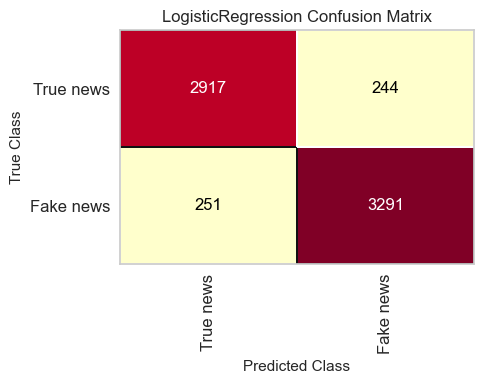

Classification Report:
              precision    recall  f1-score   support

   True news       0.92      0.92      0.92      3161
   Fake news       0.93      0.93      0.93      3542

    accuracy                           0.93      6703
   macro avg       0.93      0.93      0.93      6703
weighted avg       0.93      0.93      0.93      6703

Accuracy score: 0.92615
Average F1 score: 0.92592
ROC-AUC score: 0.92597
PR-AUC score: 0.90245

BaggingClassifier


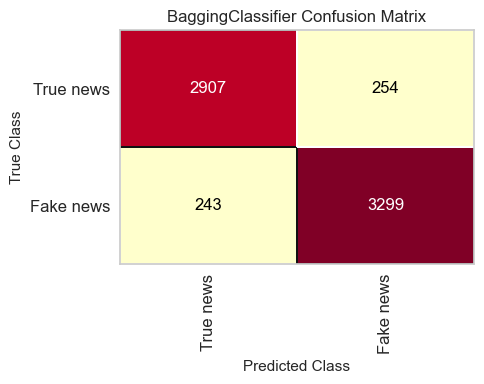

Classification Report:
              precision    recall  f1-score   support

   True news       0.92      0.92      0.92      3161
   Fake news       0.93      0.93      0.93      3542

    accuracy                           0.93      6703
   macro avg       0.93      0.93      0.93      6703
weighted avg       0.93      0.93      0.93      6703

Accuracy score: 0.92585
Average F1 score: 0.9256
ROC-AUC score: 0.92552
PR-AUC score: 0.90106

ExtraTreesClassifier


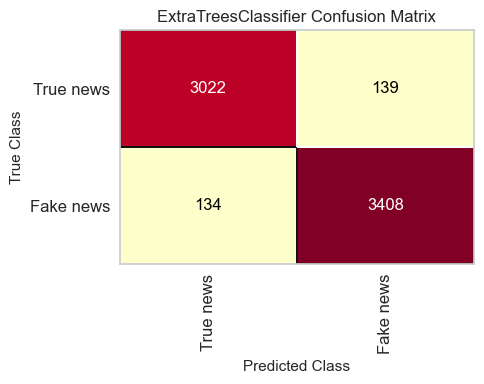

Classification Report:
              precision    recall  f1-score   support

   True news       0.96      0.96      0.96      3161
   Fake news       0.96      0.96      0.96      3542

    accuracy                           0.96      6703
   macro avg       0.96      0.96      0.96      6703
weighted avg       0.96      0.96      0.96      6703

Accuracy score: 0.95927
Average F1 score: 0.95914
ROC-AUC score: 0.9591
PR-AUC score: 0.94445

SVC


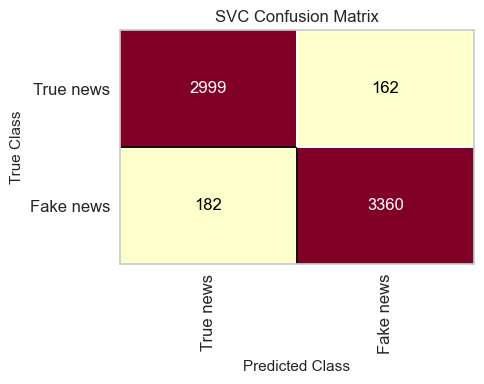

Classification Report:
              precision    recall  f1-score   support

   True news       0.94      0.95      0.95      3161
   Fake news       0.95      0.95      0.95      3542

    accuracy                           0.95      6703
   macro avg       0.95      0.95      0.95      6703
weighted avg       0.95      0.95      0.95      6703

Accuracy score: 0.94868
Average F1 score: 0.94853
ROC-AUC score: 0.94868
PR-AUC score: 0.93214

GradientBoostingClassifier


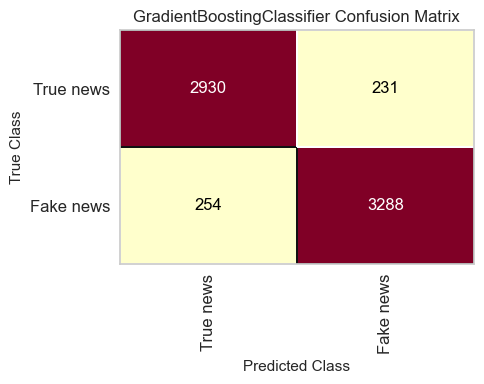

Classification Report:
              precision    recall  f1-score   support

   True news       0.92      0.93      0.92      3161
   Fake news       0.93      0.93      0.93      3542

    accuracy                           0.93      6703
   macro avg       0.93      0.93      0.93      6703
weighted avg       0.93      0.93      0.93      6703

Accuracy score: 0.92764
Average F1 score: 0.92744
ROC-AUC score: 0.92761
PR-AUC score: 0.90525

XGBClassifier


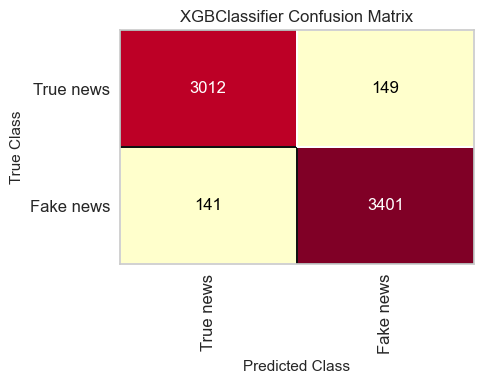

Classification Report:
              precision    recall  f1-score   support

   True news       0.96      0.95      0.95      3161
   Fake news       0.96      0.96      0.96      3542

    accuracy                           0.96      6703
   macro avg       0.96      0.96      0.96      6703
weighted avg       0.96      0.96      0.96      6703

Accuracy score: 0.95674
Average F1 score: 0.95659
ROC-AUC score: 0.95653
PR-AUC score: 0.94093



<IPython.core.display.Javascript object>

In [499]:
classes = ["True news", "Fake news"]
size = (200, 100)
models_list_s = []
scores = {}
scores["model_name"] = []
scores["a_score"] = []
scores["f1_score"] = []
scores["precision_score"] = []
scores["recall_score"] = []
scores["ROC_AUC_score"] = []
scores["PR_AUC_score"] = []

for classifier in classifiers:
    score_model(
        X_train_s,
        y_train_s,
        X_val_s,
        y_val_s,
        classifier,
        preprocessor,
        scores,
        models_list_s,
        classes,
        size,
        "all",
    )

In [256]:
scores_s = pd.DataFrame(scores).sort_values("f1_score", ascending=False)
scores_s = scores_s.set_index("model_name")
scores_s

a_score  f1_score  precision_score  recall_score  \
model_name                                                                     
ExtraTreesClassifier        0.95927   0.95914          0.95918       0.95910   
XGBClassifier               0.95674   0.95659          0.95665       0.95653   
RandomForestClassifier      0.95644   0.95627          0.95662       0.95597   
SVC                         0.94868   0.94853          0.94839       0.94868   
GradientBoostingClassifier  0.92764   0.92744          0.92729       0.92761   
LogisticRegression          0.92615   0.92592          0.92587       0.92597   
BaggingClassifier           0.92585   0.92560          0.92568       0.92552   
AdaBoostClassifier          0.91467   0.91446          0.91419       0.91485   
GaussianNB                  0.86857   0.86835          0.86809       0.86905   

                            ROC_AUC_score  PR_AUC_score  
model_name                                               
ExtraTreesClassifier              0.95910       0.94445  
XGBClassifier                     0.95653       0.94093  
RandomForestClassifier            0.95597       0.93865  
SVC                               0.94868       0.93214  
GradientBoostingClassifier        0.92761       0.90525  
LogisticRegression                0.92597       0.90245  
BaggingClassifier                 0.92552       0.90106  
AdaBoostClassifier                0.91485       0.89063  
GaussianNB                        0.86905       0.83728

<IPython.core.display.Javascript object>

In [503]:
for model in models_list_s:
    joblib.dump(model, f"model_news_status_s_{models_list_s.index(model)}.joblib")

<IPython.core.display.Javascript object>

In [504]:
scores = pd.DataFrame(scores).set_index("model_name")
scores_s.to_csv("scores_news.csv")

<IPython.core.display.Javascript object>

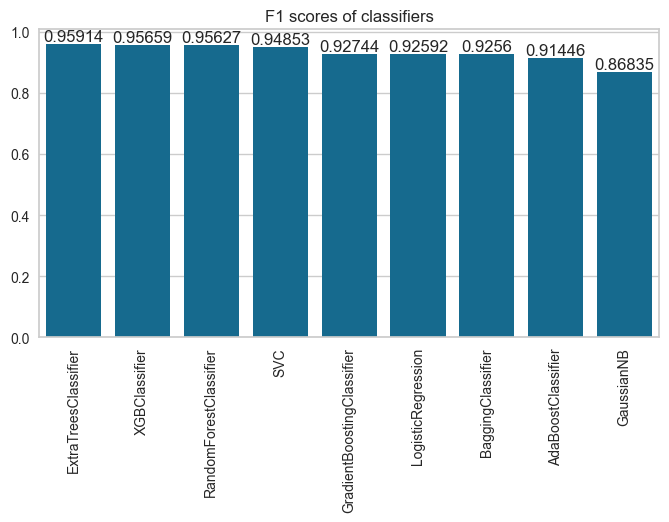

<IPython.core.display.Javascript object>

In [257]:
plot_bars(scores_s, "f1_score", "", "F1 scores of classifiers")

#### Feature importances

In order to better understand which features contributed to these prediction results, feature importances of for selected decision-tree-type classifiers were examined.

Initially, the data were preprocessed. 

In [100]:
preprocessor.fit(X_s)
X_pipe_s = pd.DataFrame(preprocessor.transform(X_s))
X_pipe_train_s = pd.DataFrame(preprocessor.transform(X_train_s))
X_pipe_val_s = pd.DataFrame(preprocessor.transform(X_val_s))
X_pipe_test_s = pd.DataFrame(preprocessor.transform(X_test_s))

<IPython.core.display.Javascript object>

In [101]:
X_pipe_s.columns = list(preprocessor.get_feature_names_out())

<IPython.core.display.Javascript object>

Feature importances were calculated for ensemble classifiers.

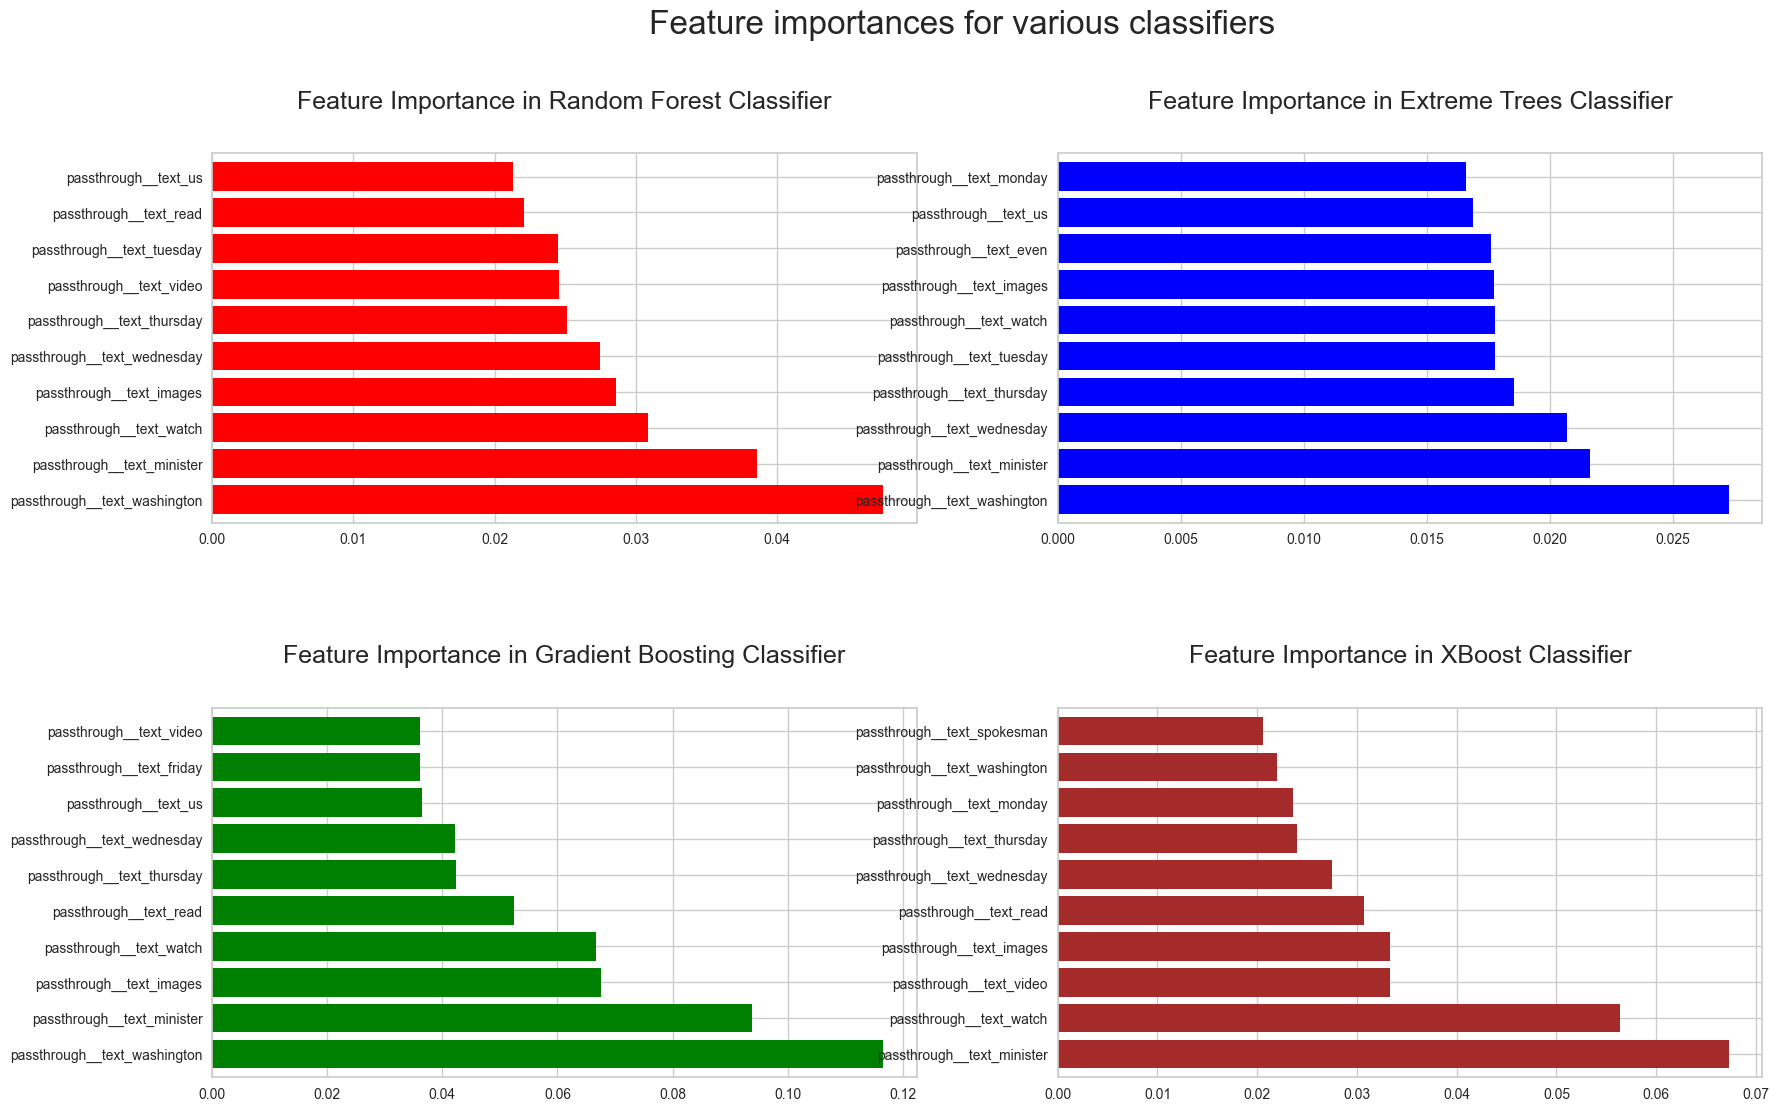

<IPython.core.display.Javascript object>

In [510]:
indices = [0, 5, 7, 8]
models_new = [models_list_s[index] for index in indices]
model_name_list_new = [
    "Random Forest Classifier",
    "Extreme Trees Classifier",
    "Gradient Boosting Classifier",
    "XBoost Classifier",
]
color_list = ["red", "blue", "green", "brown"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Feature importances for various classifiers", fontsize=24, y=1)

for model, ax, model_name in zip(models_new, axs.ravel(), model_name_list_new):
    pd.Series(model[-1].feature_importances_, X_pipe_s.columns).sort_values(
        ascending=False
    ).head(10).plot.barh(width=0.8, ax=ax, color=color_list[models_new.index(model)])
    ax.set_title(
        f"Feature Importance in {model_name}",
        fontsize=18,
        y=1.1,
    )
    ax.set_xlabel("")

plt.show()

It can be observed that words "com", 'minister', 'watch','https','images''video', 'pic', 'spokesman','know' are the words in text of articles that have the highest importance, 'hillary' is the word in titles of articles that is one of 10 most important words determining the performance of classifier. 

It has to be noted that such words as 'reuters', 'said', 'featured', 'via', 'image', 'the', 'twitter' (from text), 'video', 'watch' (from titles) had been already removed from the initial dataset after the previous rounds of model training, when it was noticed that these words have the decisive impact of the classifiers' ability to predict if news articles are fake or real (that is, with these words the classifiers achieved almost 100 percent accuracy).

### Predictions

#### Predicting on the test data

In [197]:
def test_model(
    x_test: pd.DataFrame,
    y_test: pd.DataFrame,
    model: BaseEstimator,
    df: pd.DataFrame,
    classes: List[str],
    size: float,
    **kwargs: Any,
) -> BaseEstimator:
    """
    This function tests a model, and updates a dataframe with metrics.

    :returns: The fitted model.
    """

    # Prediction:

    prediction = model.predict(x_test)
    predicted = pd.Series(prediction, index=y_test.index)
    predictions_list.append(predicted)
    if model_name != "SVC":
        prediction_proba = model.predict_proba(x_test)
        prediction_proba_true = prediction_proba[:, 0]
        predicted_series = pd.Series(prediction_proba_true, index=y_test.index)
        predictions_proba_list.append(predicted_series)
    else:
        pass

    # Metrics:
    f1 = f1_score(y_test, prediction, average="macro").round(5)
    prec = precision_score(y_test, prediction, average="macro").round(5)
    rec = recall_score(y_test, prediction, average="macro").round(5)
    acc_sq = accuracy_score(y_test, prediction).round(5)
    report = classification_report(y_test, prediction, target_names=classes)
    roc_auc = roc_auc_score(y_test, prediction).round(5)
    pr_auc = average_precision_score(y_test, prediction).round(5)

    # Prints:
    print(model_name)

    fig = plt.figure(figsize=(5, 4))
    cm = ConfusionMatrix(
        model, classes=classes, label_encoder={0: "True news", 1: "Fake news"}
    )
    cm.score(x_test, y_test)
    cm.show()
    print("Classification Report:")
    print(report)
    print(f"Accuracy score: {acc_sq}")
    print(f"Average F1 score: {f1}")
    print(f"ROC-AUC score: {roc_auc}")
    print(f"PR-AUC score: {pr_auc}")
    print("")

    # Appends:
    df["model_name"].append(f"{model_name}")
    df["a_score"].append(acc_sq)
    df["f1_score"].append(f1)
    df["precision_score"].append(prec)
    df["recall_score"].append(rec)
    df["ROC_AUC_score"].append(roc_auc)
    df["PR_AUC_score"].append(pr_auc)
    return model

<IPython.core.display.Javascript object>

RandomForestClassifier


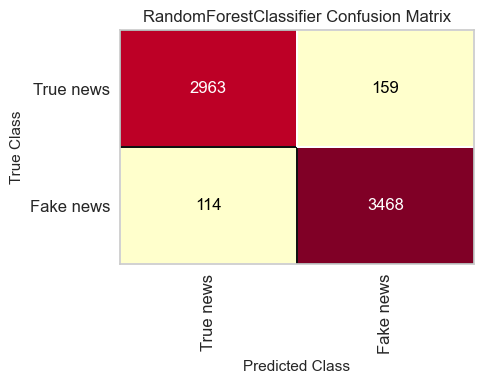

Classification Report:
              precision    recall  f1-score   support

   True news       0.96      0.95      0.96      3122
   Fake news       0.96      0.97      0.96      3582

    accuracy                           0.96      6704
   macro avg       0.96      0.96      0.96      6704
weighted avg       0.96      0.96      0.96      6704

Accuracy score: 0.95928
Average F1 score: 0.95905
ROC-AUC score: 0.95862
PR-AUC score: 0.94274

AdaBoostClassifier


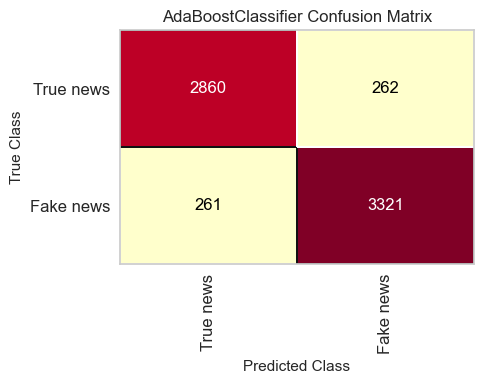

Classification Report:
              precision    recall  f1-score   support

   True news       0.92      0.92      0.92      3122
   Fake news       0.93      0.93      0.93      3582

    accuracy                           0.92      6704
   macro avg       0.92      0.92      0.92      6704
weighted avg       0.92      0.92      0.92      6704

Accuracy score: 0.92199
Average F1 score: 0.92162
ROC-AUC score: 0.92161
PR-AUC score: 0.89827

GaussianNB


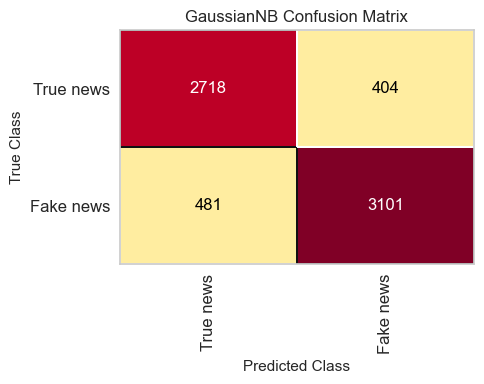

Classification Report:
              precision    recall  f1-score   support

   True news       0.85      0.87      0.86      3122
   Fake news       0.88      0.87      0.88      3582

    accuracy                           0.87      6704
   macro avg       0.87      0.87      0.87      6704
weighted avg       0.87      0.87      0.87      6704

Accuracy score: 0.86799
Average F1 score: 0.86756
ROC-AUC score: 0.86816
PR-AUC score: 0.83768

LogisticRegression


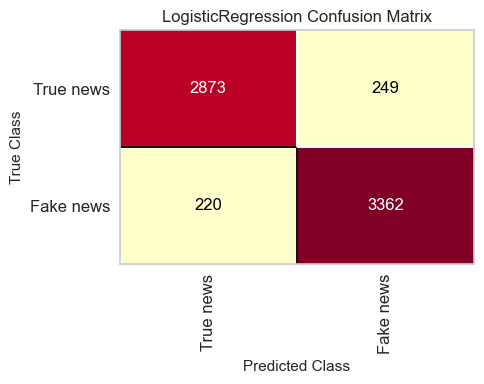

Classification Report:
              precision    recall  f1-score   support

   True news       0.93      0.92      0.92      3122
   Fake news       0.93      0.94      0.93      3582

    accuracy                           0.93      6704
   macro avg       0.93      0.93      0.93      6704
weighted avg       0.93      0.93      0.93      6704

Accuracy score: 0.93004
Average F1 score: 0.92967
ROC-AUC score: 0.92941
PR-AUC score: 0.90668

BaggingClassifier


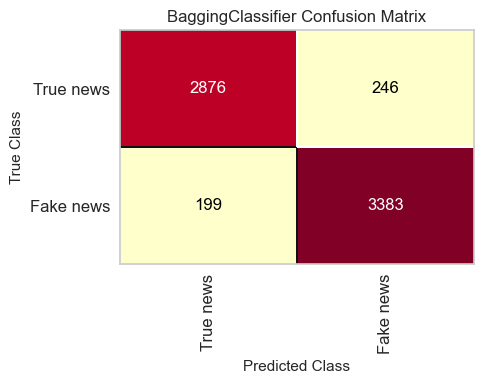

Classification Report:
              precision    recall  f1-score   support

   True news       0.94      0.92      0.93      3122
   Fake news       0.93      0.94      0.94      3582

    accuracy                           0.93      6704
   macro avg       0.93      0.93      0.93      6704
weighted avg       0.93      0.93      0.93      6704

Accuracy score: 0.93362
Average F1 score: 0.93324
ROC-AUC score: 0.93282
PR-AUC score: 0.91011

ExtraTreesClassifier


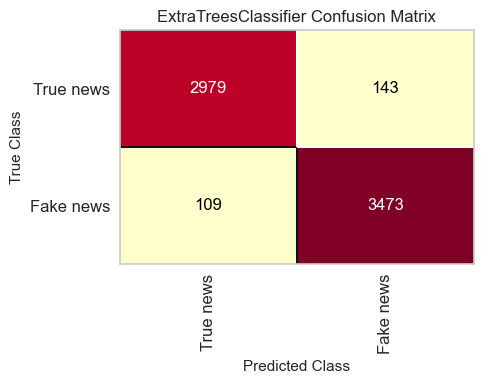

Classification Report:
              precision    recall  f1-score   support

   True news       0.96      0.95      0.96      3122
   Fake news       0.96      0.97      0.96      3582

    accuracy                           0.96      6704
   macro avg       0.96      0.96      0.96      6704
weighted avg       0.96      0.96      0.96      6704

Accuracy score: 0.96241
Average F1 score: 0.96221
ROC-AUC score: 0.96188
PR-AUC score: 0.94749

SVC


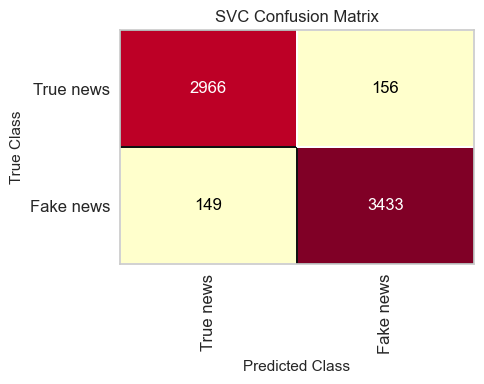

Classification Report:
              precision    recall  f1-score   support

   True news       0.95      0.95      0.95      3122
   Fake news       0.96      0.96      0.96      3582

    accuracy                           0.95      6704
   macro avg       0.95      0.95      0.95      6704
weighted avg       0.95      0.95      0.95      6704

Accuracy score: 0.9545
Average F1 score: 0.95428
ROC-AUC score: 0.95422
PR-AUC score: 0.93897

GradientBoostingClassifier


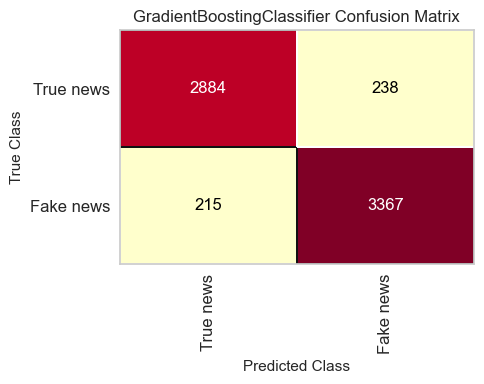

Classification Report:
              precision    recall  f1-score   support

   True news       0.93      0.92      0.93      3122
   Fake news       0.93      0.94      0.94      3582

    accuracy                           0.93      6704
   macro avg       0.93      0.93      0.93      6704
weighted avg       0.93      0.93      0.93      6704

Accuracy score: 0.93243
Average F1 score: 0.93208
ROC-AUC score: 0.93187
PR-AUC score: 0.90999

XGBClassifier


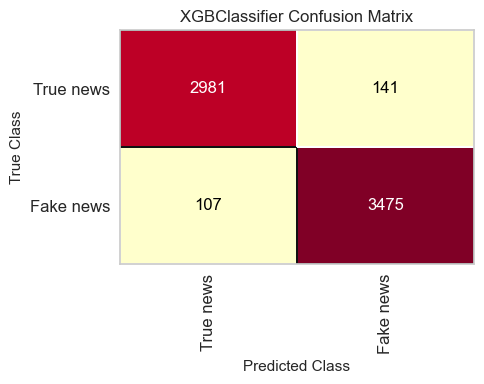

Classification Report:
              precision    recall  f1-score   support

   True news       0.97      0.95      0.96      3122
   Fake news       0.96      0.97      0.97      3582

    accuracy                           0.96      6704
   macro avg       0.96      0.96      0.96      6704
weighted avg       0.96      0.96      0.96      6704

Accuracy score: 0.96301
Average F1 score: 0.96281
ROC-AUC score: 0.96248
PR-AUC score: 0.94826



<IPython.core.display.Javascript object>

In [202]:
predictions_list = []
predictions_proba_list = []
classes = ["True news", "Fake news"]
size = (200, 100)
scores_test = {}
scores_test["model_name"] = []
scores_test["a_score"] = []
scores_test["f1_score"] = []
scores_test["precision_score"] = []
scores_test["recall_score"] = []
scores_test["ROC_AUC_score"] = []
scores_test["PR_AUC_score"] = []

for model, model_name in zip(models_list_s, model_name_list):
    test_model(X_test_s, y_test_s, model, scores_test, classes, size)

In [252]:
scores_test = pd.DataFrame(scores_test).sort_values("f1_score", ascending=False)
#scores_test = scores_test.set_index("model_name")
scores_test

a_score  f1_score  precision_score  recall_score  \
model_name                                                                     
XGBClassifier               0.96301   0.96281          0.96318       0.96248   
ExtraTreesClassifier        0.96241   0.96221          0.96258       0.96188   
RandomForestClassifier      0.95928   0.95905          0.95956       0.95862   
SVC                         0.95450   0.95428          0.95435       0.95422   
BaggingClassifier           0.93362   0.93324          0.93375       0.93282   
GradientBoostingClassifier  0.93243   0.93208          0.93230       0.93187   
LogisticRegression          0.93004   0.92967          0.92996       0.92941   
AdaBoostClassifier          0.92199   0.92162          0.92162       0.92161   
GaussianNB                  0.86799   0.86756          0.86719       0.86816   

                            ROC_AUC_score  PR_AUC_score  
model_name                                               
XGBClassifier                     0.96248       0.94826  
ExtraTreesClassifier              0.96188       0.94749  
RandomForestClassifier            0.95862       0.94274  
SVC                               0.95422       0.93897  
BaggingClassifier                 0.93282       0.91011  
GradientBoostingClassifier        0.93187       0.90999  
LogisticRegression                0.92941       0.90668  
AdaBoostClassifier                0.92161       0.89827  
GaussianNB                        0.86816       0.83768

<IPython.core.display.Javascript object>

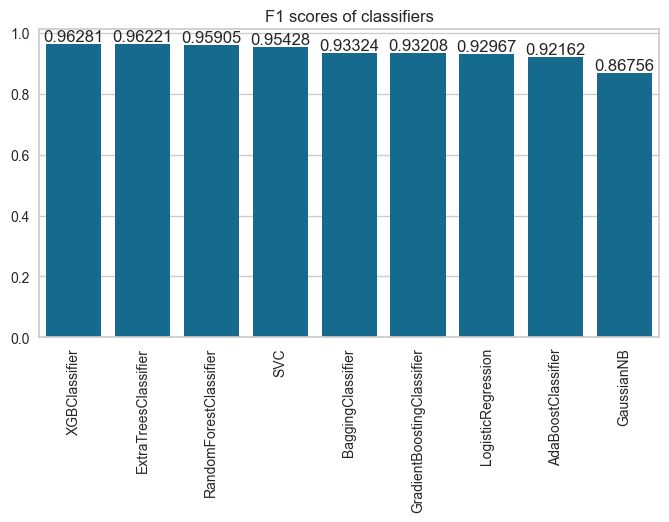

<IPython.core.display.Javascript object>

In [253]:
plot_bars(scores_test, "f1_score", "", "F1 scores of classifiers")

It can be observed that the classifiers provide excellent results on the test data as well. 

#### Predicting on new data

In order to observe, how models perform on the new articles uploaded from the internet the following steps were implemented:
1. Load trained models from the local directory;
2. a text from CNN was saved as a txt file;
3. the file was uploaded to a string, also a string for title was created;
4. a dataframe was created from these strings;
5. stopwords were removed;
6. text and title of the dataframe were vectorized with the function 'vectorize_text()' which uses TfidfVectorizer from sklearn;
7. dictionaries for keys as words and values as vector scores were created;
8. dataframes from dictionaries were created for both text and titles, they were renamed and concatenated into a single dataframe;
9. Columns which correspond with columns in the main dataset were filtered;
10. The dataframe from the article data was concatenated with the main dataset on axis 1.

In [188]:
model_directory = "/Users/user/PycharmProjects/NewsAnalysis"

model_file_paths = [
    os.path.join(model_directory, f"model_news_status{i}.joblib") for i in range(9)
]

models_list = []

for file_path in model_file_paths:
    model = load(file_path)
    models_list.append(model)

<IPython.core.display.Javascript object>

In [199]:
model_directory = "/Users/user/PycharmProjects/NewsAnalysis"

model_file_paths = [
    os.path.join(model_directory, f"model_news_status_s_{i}.joblib") for i in range(9)
]

models_list_s = []

for file_path in model_file_paths:
    model = load(file_path)
    models_list_s.append(model)

<IPython.core.display.Javascript object>

In [207]:
file_path = "news_article.txt"
new_title = 'Israel expanding ground offensive into central Gaza refugee camps'
with open(file_path, "r", encoding="ISO-8859-1") as file:
    new_text = file.read()


<IPython.core.display.Javascript object>

In [208]:
df = pd.DataFrame({"text": [new_text], "title": [new_title]})

<IPython.core.display.Javascript object>

In [211]:
stopwords = set(STOPWORDS)
df["text_no_stopwords"] = df["text"].apply(remove_stopwords)
df["title_no_stopwords"] = df["title"].apply(remove_stopwords)

<IPython.core.display.Javascript object>

In [212]:
denselist_text, feature_names_text = vectorize_text(400, df["text_no_stopwords"])
denselist_title, feature_names_title = vectorize_text(400, df["title_no_stopwords"])

<IPython.core.display.Javascript object>

In [213]:
word_importance_text = {
    word: round(score, 3) for word, score in zip(feature_names_text, denselist_text[0])
}
word_importance_title = {
    word: round(score, 3)
    for word, score in zip(feature_names_title, denselist_title[0])
}

<IPython.core.display.Javascript object>

In [214]:
new_df_text = pd.DataFrame({k: [v] for k, v in word_importance_text.items()})
new_df_title = pd.DataFrame({k: [v] for k, v in word_importance_title.items()})
new_df_text_renamed = rename_columns_add_substring(new_df_text, "text_")
new_df_title_renamed = rename_columns_add_substring(new_df_title, "title_")

new_df = pd.concat([new_df_title_renamed, new_df_text_renamed], axis=1)

common_columns = X.columns.intersection(new_df.columns)
new_df_filtered = new_df[common_columns]
concat_df = pd.concat([X, new_df_filtered], axis=0).fillna(0).reset_index(drop=True)
# concat_df = concat_df.iloc[:, 1:]

<IPython.core.display.Javascript object>

Predictions for the uploaded and vectorized article were made with all trained classifiers. 

In [215]:
predictions = []
for classifier, model, model_name in zip(classifiers, models_list, model_name_list):
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", classifier)]
    )

    prediction = model.predict(pd.DataFrame(concat_df.iloc[-1, :]).transpose())
    predictions.append(prediction)
    if prediction[0] == 0:
        print(f"The article is predicted as true news by {model_name}.")
    else:
        print(f"The article is predicted as fake news by {model_name}.")

The article is predicted as true news by RandomForestClassifier.
The article is predicted as true news by AdaBoostClassifier.
The article is predicted as true news by GaussianNB.
The article is predicted as true news by LogisticRegression.
The article is predicted as true news by BaggingClassifier.
The article is predicted as true news by ExtraTreesClassifier.
The article is predicted as true news by SVC.
The article is predicted as true news by GradientBoostingClassifier.
The article is predicted as true news by XGBClassifier.


<IPython.core.display.Javascript object>

It can be observed that only classifiers correctly predicted that this article is true news.

### Interpreting models' performance with LIME

For the LIME interpretation news articles which were mis-classified were randomly selected form the predictions of the GradientBoost classifier. 

In [248]:
misclassified = X_test[predictions_list[7] != y_test]

<IPython.core.display.Javascript object>

In [249]:
random_vectors = misclassified.sample(n=5, random_state=20)
random_vectors.index

Index([17403, 39374, 19246, 16033, 31217], dtype='int64')

<IPython.core.display.Javascript object>

The LIME tabular data explainer was set with training data as the array, and 'classification' model. 

In [247]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, 
    feature_names=X_train.columns.tolist(), 
    class_names=classes, 
    mode='classification'
)


<IPython.core.display.Javascript object>

The function, that accepts data in array format (it is required by the explainer), transforms it to a dataframe row and predicts probabilities on it, was created. 

In [219]:
def predict_proba_wrapper(data_array):
    if data_array.ndim == 1:
        data_array = data_array.reshape(1, -1)
    data_df = pd.DataFrame(data_array, columns=X_pipe.columns)
    return models_list[8][2].predict_proba(data_df)

<IPython.core.display.Javascript object>

#### Fake news articles classified as true news articles:

An article that was actually fake but it was mis-classified as true was selected for examination (when fakenews and truenews dataframes were concatenated, all articles from the fakenews dataset got index values until 21500). The data row was set into series and array formats as it is required by the explain_instance() function.

In [244]:
instance_index = 17403
instance = X_test.loc[instance_index]
instance_array = instance.values.T

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_proba_wrapper,
    num_features=10
)

exp.show_in_notebook(show_table=True, show_all=False)

<IPython.core.display.Javascript object>

Next, we observe the article itself by selecting it from the news dataset. 

In [230]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
news.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

In [231]:
news[["title", "text"]][news.index == 17403]

title  \
17403  DEATH PANELS? PRINCETON PROFESSOR WANTS TO KILL DISABLED BABIES And Wants Obamacare To Pay For It   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

<IPython.core.display.Javascript object>

It can be observed that the article's text actually does not contain the word 'factbox". On the other hand, the title contains the word "hillary", thus it is not clear why the explainer explained it otherwise.

In [ ]:
instance_index = 16033
instance = X_test.loc[instance_index]
instance_array = instance.values.T

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_proba_wrapper,
    num_features=10
)

exp.show_in_notebook(show_table=True, show_all=False)

In [238]:
news[["title", "text"]][news.index == 16033]

title  \
16033  SHUT IT DOWN! JUDICIAL WATCH PRES Calls Out Biased Mueller Witch Hunt “Are there any Trump donors on the team?” [Video]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               text  
16033   Are there any Trump donors on the team? GREAT QUESTION BY TOM FITTON! Judicial Watch President Tom Fitton joined FOX News to explain Mueller s latest hire of Andrew Goldstein, a former prosecutor who worked under Preet Bharara in New York. Remember Prett Bharara? Trump fired him! Fitton questioned who is overseeing Mueller s day-to-day conduct, pointing to the 12 hires he has made for his legal team all liberal political hacks!Special Counsel Mueller s investigation is out of control. @realDonaldTrump DOJ should shut it down. https://t.co/IYr9Hiqkix  Tom Fitton (@TomFitton) July 2, 2017A VERY KEY REASON FOR THIS WITCH HUNT TO END IS THAT: Several of the lawyers donated to Democrats and it seems that the team is  searching for a crime. Fitton said:  I don t understand what this investigation is about.. You know my count is 14, 15 lawyers to have working on this one investigation to investigate to investigate what? An employment dispute between Comey and the President? You have the conflicts caused by Comey leaking records to get Mueller appointed, you have Constitutional concerns about the way the office operates. Fitton then pointed out what s a big concern for most people watching this 

<IPython.core.display.Javascript object>

It can be observed for this article that: 
 - the absence of "title_obama", "title_breaking", "title_hillary", "text_images", etc. (or it being below a certain threshold, depending on your feature encoding) is contributing positively towards the prediction of a news item being "True News" with weight of 0.23 or lower. These features in its current state (being <= 0) is supporting the model's decision to classify the news as true.
 - The absence of "title_factbox", "text_minister", "text_wednesday" is a significant factor in the model predicting "Fake News" with a weight of 0.25 or lower. It influences the model towards the "Fake News" classification.
 - It can be observed that classification of the article is determined mainly not by the presence or by the absence of certain words in the text. It is probable that it is the reason why this article was mis-classified. 

#### True news articles classified as fake news article:

In the same way, the news article which was labeled as true news but was classified as fake news was examined. 

In [243]:
instance_index = 31217
instance = X_test.loc[instance_index]
instance_array = instance.values.T

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_proba_wrapper,
    num_features=10
)

exp.show_in_notebook(show_table=True, show_all=False)

<IPython.core.display.Javascript object>

In [235]:
news[["title", "text"]][news.index == 31217]

title  \
31217  Rejecting Trump, Wall Street Republican donors scatter largesse   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

<IPython.core.display.Javascript object>

In [ ]:
instance_index = 39374
instance = X_test.loc[instance_index]
instance_array = instance.values.T

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_proba_wrapper,
    num_features=10
)

exp.show_in_notebook(show_table=True, show_all=False)

In [241]:
news[["title", "text"]][news.index == 39374]

title  \
39374  Magnitude 7.0 undersea quake hits near New Caledonia, no tsunami   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  
39374  (Reuters) - A major undersea earthquake of magnitude 7.0 struck close to New Caledonia in the South Pacific on Tuesday, the U.S. Geological Survey said. The quake, which was at a shallow depth of 9.3 miles (15 km)below the seabed, did not trigger a tsunami, according to the Pacific Tsunami Warning Center in Hawaii and the Joint Australian Tsunami Warning Centre.The epicenter was located 73 miles (117.48 km) east of the town of Tadine, on the Loyalty Islands, part of France s New Caledonia territory. There were no immediate reports of injuries or damage. A spokesman for the government in Noumea, the New Caledonia capital, and staff of two hotels contacted by Reuters said they did not feel the quake.

<IPython.core.display.Javascript object>

It can be observed for this article that: 
 - the absence of "text_read", "title_breaking", "title_hillary", "text_https", presence of "text_wednesday", etc. (or it being below a certain threshold, depending on your feature encoding) is contributing positively towards the prediction of a news item being "True News" with weight of 0.24 or lower. These features in its current state (being <= 0) is supporting the model's decision to classify the news as true.
 - The absence of "title_factbox","title_emails", "text_minister", presence of "title_Obama" is a significant factor in the model predicting "Fake News" with a weight of 0.32 or lower. It influences the model towards the "Fake News" classification.
 - It can be observed that classification of the article is determined mainly not by the presence or by the absence of certain words in the text (except "Obama" in the title and "Wednesday" in the text). It is probable that it is the reason why this article was mis-classified. 

## 3. Deep learning

Next, the fake news classifier was training with deep learning models. Initially, it was trained with two layers network, then the pre-trained transformer model Roberta was used for classifier training.

### TWO LINEAR LAYERS NETWORK MODEL

### Preparing the dataset

For the two linear layers network training, the vectorized dataset (the same which was used for machine learnin) was transformed into tensor dataset (with the Pythorch Lightning module) and split into training, validation and test datasets (with the proportion 40 percent, 40 percent, and 20 percent).

In [105]:
X_tensor = torch.tensor(X_pipe.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset, temp_dataset = train_test_split(dataset, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp_dataset, test_size=0.5, random_state=42)



<IPython.core.display.Javascript object>

For the training and prediction purposes, data were loaded from the training, validation and test datasets with the training, validation and test data loaders.

In [106]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)

<IPython.core.display.Javascript object>

### Creating model class

The FakeNewsClassifier​ class is created as a Pytorch Lightning module. This class initiates creates a network os two linear layers (the first layer inputs all vectorized features and outputs 16 features; the second layer inputs 16 features and outputs the binary variable). It also contains methods which are commonly included into Pytorch Lightning modules used for deep learning:

- forward (to pass the input x through the Resnet model and return the output),
- training_step (to compute the predicted output using the forward pass and calculate the losses),
- validation_step and test_step (to compute the losses for the given batch of data and log these metrics),
- configure_optimizers (to select optimizers),

Some peculiartities of the class:

- the class uses AdamW optimizer as a more advanced version of Adam optimizer;
- the class uses binary cross entropy function for loss calculation;
- the class uses auroc metrics for performance metrics;
- the class uses the learning rate 0.001 that has proved to be as the most optimal in training deep learning networks.


In [107]:
class FakeNewsClassifier(pl.LightningModule):
    """
    A PyTorch Lightning module for classifying fake news using a simple neural network with dropout layers for regularization.

    Attributes:
        dense1 (nn.Linear): First dense layer of the network.
        dropout1 (nn.Dropout): First dropout layer.
        dense2 (nn.Linear): Second dense layer of the network.
        dropout2 (nn.Dropout): Second dropout layer.
        loss (nn.BCELoss): Binary cross-entropy loss function.
        roc_auc (torchmetrics.AUROC): ROC AUC metric for binary classification.

    Args:
        input_size (int): The number of input features.
        dropout_rate (float, optional): Dropout rate. Default is 0.5.
    """

    def __init__(self, input_size: int, dropout_rate: float = 0.5):
        super(FakeNewsClassifier, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dense2 = nn.Linear(16, 1)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.loss = nn.BCELoss()
        self.roc_auc = torchmetrics.AUROC(task="binary")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the classifier.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.dense2(x))
        x = self.dropout2(x)
        return x

    def training_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        """
        Training step for the classifier.

        Args:
            batch (tuple): A tuple containing input data and labels.
            batch_idx (int): Batch index.

        Returns:
            torch.Tensor: The computed loss for the batch.
        """
        x, y = batch
        logits = self(x)
        logits = logits.squeeze(-1)
        loss = self.loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch: tuple, batch_idx: int):
        """
        Validation step for the classifier.

        Args:
            batch (tuple): A tuple containing input data and labels.
            batch_idx (int): Batch index.
        """
        x, y = batch
        logits = self(x)
        logits = logits.squeeze(-1)
        loss = self.loss(logits, y)
        self.log("val_loss", loss)
        self.log("val_roc_auc", self.roc_auc(logits, y.int()))

    def configure_optimizers(self):
        """
        Configure optimizers for the classifier.

        Returns:
            Optimizer: The optimizer for the network.
        """
        return torch.optim.Adam(self.parameters(), lr=1e-3)


<IPython.core.display.Javascript object>

The model was instatiated with the created class. 

In [108]:
model = FakeNewsClassifier(input_size=len(X.columns))

<IPython.core.display.Javascript object>

GPU device was attached to the model.

In [109]:
device = torch.device("mps")
model.to(device)

FakeNewsClassifier(
  (dense1): Linear(in_features=1131, out_features=16, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dense2): Linear(in_features=16, out_features=1, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (loss): BCELoss()
  (roc_auc): BinaryAUROC()
)

<IPython.core.display.Javascript object>

Tensorboard_logger is a tool that helps visualize and track the training process of a machine learning model. In this case, the TensorBoardLogger is used to store the logs and results of a classification model in a specific directory ("./logs") (see bellow).

In [110]:
tensorboard_logger = pl.loggers.TensorBoardLogger(
    save_dir="./logs", name="binary_classification"
)

<IPython.core.display.Javascript object>

In [111]:
!tensorboard --logdir=/Users/user/PycharmProjects/NewsAnalysis/

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


<IPython.core.display.Javascript object>

### Specifying callbacks

The early_stopping_callback is a callback function that is used to stop the training process early if the validation loss does not improve for a certain number of epochs. 

The callback for automatically saving the trained model after each epoch was created.

Also, a callback classes for calculating training time and collecting validation logs were created and instantiated as callbacks.

In [118]:
early_stopping_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')


<IPython.core.display.Javascript object>

In [119]:
checkpoint_callback = ModelCheckpoint(
        dirpath="models/",
        filename=f'{{epoch}}-{{val_loss:.2f}}',
        monitor="val_loss",
        save_top_k=3,
        mode="min",
        every_n_epochs=1,
    )


<IPython.core.display.Javascript object>

In [120]:
class ValidationLogCollectorCallback(pl.Callback):
    """
    A PyTorch Lightning callback that collects validation metrics at the end of each validation epoch.
    """

    def __init__(self):
        """
        Initializes the ValidationLogCollectorCallback.
        """
        super().__init__()
        self.validation_metrics = []

    def on_validation_epoch_end(
        self, trainer: pl.Trainer, pl_module: pl.LightningModule
    ):
        """
        Collects the validation metrics at the end of each validation epoch.

        Args:
            trainer (pl.Trainer): The PyTorch Lightning trainer object.
            pl_module (pl.LightningModule): The PyTorch Lightning module being trained.
        """
        metrics = trainer.callback_metrics
        self.validation_metrics.append(metrics)

    def get_metrics_dataframe(self) -> pd.DataFrame:
        """
        Returns a Pandas DataFrame containing the collected validation metrics.

        Returns:
            pd.DataFrame: A Pandas DataFrame containing the collected validation metrics.
        """
        return pd.DataFrame(self.validation_metrics)

<IPython.core.display.Javascript object>

In [121]:
class EpochTimeCallback(pl.Callback):
    """
    A PyTorch Lightning callback to measure and store the duration of each epoch.
    
    Attributes:
    epoch_times_df (pd.DataFrame): A dataframe containing epoch numbers and their corresponding durations.
    """

    def __init__(self):
        """Initializes the callback and sets up an empty dataframe to store epoch times."""
        super().__init__()
        self.epoch_times_df: pd.DataFrame = pd.DataFrame(columns=['Epoch', 'Duration'])

    def on_epoch_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """
        Record the start time of the epoch.

        Args:
        trainer (pl.Trainer): The trainer object.
        pl_module (pl.LightningModule): The model/module being trained.
        """
        self.epoch_start_time = time.time()

    def on_epoch_end(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:
        """
        Calculate and store the duration of the epoch, and print the epoch duration.

        Args:
        trainer (pl.Trainer): The trainer object.
        pl_module (pl.LightningModule): The model/module being trained.
        """
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        epoch = trainer.current_epoch + 1

        self.epoch_times_df.loc[len(self.epoch_times_df)] = [epoch, epoch_duration]
        print(f"Epoch {epoch} execution time: {epoch_duration:.2f} seconds")

    def get_epoch_times_df(self) -> pd.DataFrame:
        """
        Retrieve the dataframe containing epoch durations.

        Returns:
        pd.DataFrame: A dataframe containing epoch numbers and their corresponding durations.
        """
        return self.epoch_times_df


<IPython.core.display.Javascript object>

In [122]:
log_collector = ValidationLogCollectorCallback()

<IPython.core.display.Javascript object>

In [123]:
epoch_time_callback = EpochTimeCallback()

<IPython.core.display.Javascript object>

### Training the models

The metrics of each models as well as time used for training and prediction were recorded into a dictionary which will be later transformed into a pandas dataframe. Initially, The structure of the dictionary was set that was latter filled with the appended data from the steps of training, model assessment and predictions. 

In [124]:
metrics_df = {}
metrics_df["train_time"] = []
metrics_df["prediction_time_val"] = []
metrics_df["prediction_time_test"] = []
metrics_df["validation_roc_auc"] = []
metrics_df["train_loss"] = []
metrics_df["val_loss"] = []
metrics_df["test_loss"] = []

<IPython.core.display.Javascript object>

The model is trained with the Pytorch Lighntning trainer and, after the training process ended, is got saved into a local file. Data on the total training time is saved in the dictionary. The maximum number of epochs was set to 30.

In [125]:
start_time = time.time()
trainer = pl.Trainer(
    max_epochs=30,
    logger=tensorboard_logger,
    callbacks=[
        checkpoint_callback,
        log_collector,
        early_stopping_callback,
        epoch_time_callback,
    ],
)
trainer.fit(
    model, train_loader, val_loader
)
end_time = time.time()
exec_time = (end_time - start_time) / len(train_dataset)
print("")
print(f"Execution time: {exec_time}")
print(f'Loss: {model.trainer.logged_metrics}')
metrics_df["train_time"].append(exec_time)
metrics_df["train_loss"].append(model.trainer.logged_metrics["train_loss"].tolist())
metrics_df["validation_roc_auc"].append(model.trainer.logged_metrics["val_roc_auc"].tolist())
checkpoint_path = f"models/model_trained_Linear.ckpt"
trainer.save_checkpoint(checkpoint_path)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params
-----------------------------------------
0 | dense1   | Linear      | 18.1 K
1 | dropout1 | Dropout     | 0     
2 | dense2   | Linear      | 17    
3 | dropout2 | Dropout     | 0     
4 | loss     | BCELoss     | 0     
5 | roc_auc  | BinaryAUROC | 0     
-----------------------------------------
18.1 K    Trainable params
0         Non-trainable params
18.1 K    Total params
0.073     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Execution time: 0.004540463984117404
Loss: {'train_loss': tensor(17.7299), 'val_loss': tensor(0.5357), 'val_roc_auc': tensor(0.9893)}


<IPython.core.display.Javascript object>

It can be observed that the model was trained in a relatively short time. The training process was interrupted by the early stopping callback after 10 epochs. 

### Predictions on the validation and test datasets

Next, predictions based on the trained model and validation as well as test datasets are generated. The model is loaded from the checkpoint path.

In [143]:
checkpoint_path = f"models/model_trained_Linear.ckpt"
model = FakeNewsClassifier.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    input_size=len(X.columns),
)

<IPython.core.display.Javascript object>

The GPU processor is attached to models, sample weights, and to the eval() function. 

In [144]:
device = torch.device("mps")
model.to(device)
model = model.eval().to(device)


<IPython.core.display.Javascript object>

#### Predictions generated on the trained model

The treshhold for the sigmoid probabilities to be interpreted as either 0 or 1 was set to 0.6 as it was observed that all probabilities values are distributed in the interval from 0.5 to 1. 

In [157]:
y_val_pred = []
y_true_val = []
sigmoids_list_val = []
losses_val = []
start_time = time.time()
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        sigmoids = torch.sigmoid(outputs).squeeze(-1)
        preds = (sigmoids > 0.55).to(torch.int)
        sigmoids_list_val.append(sigmoids.tolist())
        y_val_pred += preds.tolist()
        y_true_val += labels.tolist()

        loss = model.loss(sigmoids, labels.float())
        losses_val.append(loss.item())

end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time}")
metrics_df["prediction_time_val"].append(prediction_time)


Prediction time: 8.621392965316772


<IPython.core.display.Javascript object>

The mean of losses of from all prediction values is calculated.

In [158]:
val_loss = np.mean(losses_val)
metrics_df["val_loss"].append(val_loss)
print("Mean validation loss for the trained model:", val_loss)


Mean validation loss for the trained model: 0.612580375728153


<IPython.core.display.Javascript object>

In [159]:
y_test_pred = []
y_true_test = []
sigmoids_list_test = []
losses_test = []
start_time = time.time()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        sigmoids = torch.sigmoid(outputs).squeeze(-1)
        preds = (sigmoids > 0.55).to(torch.int)
        sigmoids_list_test.append(sigmoids.tolist())
        y_test_pred += preds.tolist()
        y_true_test += labels.tolist()

        loss = model.loss(sigmoids, labels.float())
        losses_test.append(loss.item())

end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time}")
metrics_df["prediction_time_test"].append(prediction_time)


Prediction time: 6.111366271972656


<IPython.core.display.Javascript object>

In [160]:
test_loss = np.mean(losses_test)
metrics_df["test_loss"].append(test_loss)
print("Mean validation loss for the trained model:", test_loss)


Mean validation loss for the trained model: 0.6101896765686217


<IPython.core.display.Javascript object>

The metrics is presented in the dataframe here.

In [161]:
metrics_df = {
    key: (value[1:] if len(value) > 1 else value) for key, value in metrics_df.items()
}
scores_df = pd.DataFrame(metrics_df)
scores_df.head()

train_time  prediction_time_val  prediction_time_test  validation_roc_auc  \
0     0.00454             8.621393              6.111366            0.989345   

   train_loss  val_loss  test_loss  
0   17.729935   0.61258    0.61019

<IPython.core.display.Javascript object>

The dictionary with the added validation and test metrics was saved to the local file.

In [162]:
with open("metrics_df.pkl", "wb") as fp:
    pickle.dump(metrics_df, fp)
    print("The dictionary saved to a file.")

The dictionary saved to a file.


<IPython.core.display.Javascript object>

### Assessment of the model

#### Validation data: 

#### Plotting confusion matrix

Based on values which were generated from running the models on validation data, confusion matrixes are created and presented as heatmaps bellow. 

In [163]:
conf_mat_val = cfm(y_true_val, y_val_pred)


<IPython.core.display.Javascript object>

<Figure size 400x300 with 0 Axes>

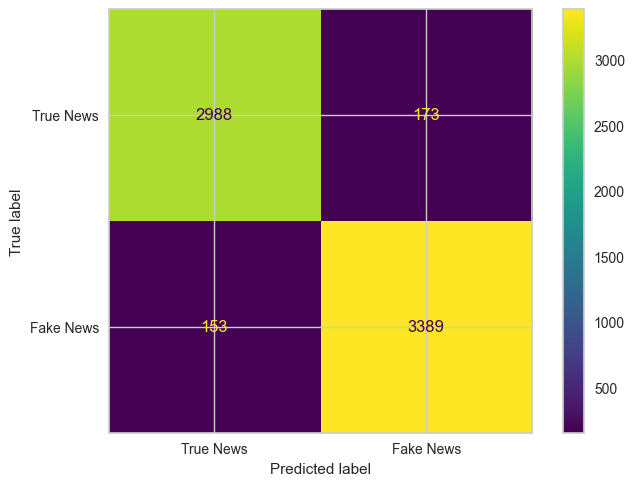

<IPython.core.display.Javascript object>

In [167]:
classes = ["True News", "Fake News"]
plt.figure(figsize=(4, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_val, display_labels=classes)
disp.plot()
plt.show()

#### Classification report

In [168]:
classification_report = classification_report(y_true_val, y_val_pred, target_names=classes)
print(classification_report)


              precision    recall  f1-score   support

   True News       0.95      0.95      0.95      3161
   Fake News       0.95      0.96      0.95      3542

    accuracy                           0.95      6703
   macro avg       0.95      0.95      0.95      6703
weighted avg       0.95      0.95      0.95      6703



<IPython.core.display.Javascript object>

#### Test data: 

In [169]:
conf_mat_test = cfm(y_true_test, y_test_pred)


<IPython.core.display.Javascript object>

<Figure size 400x300 with 0 Axes>

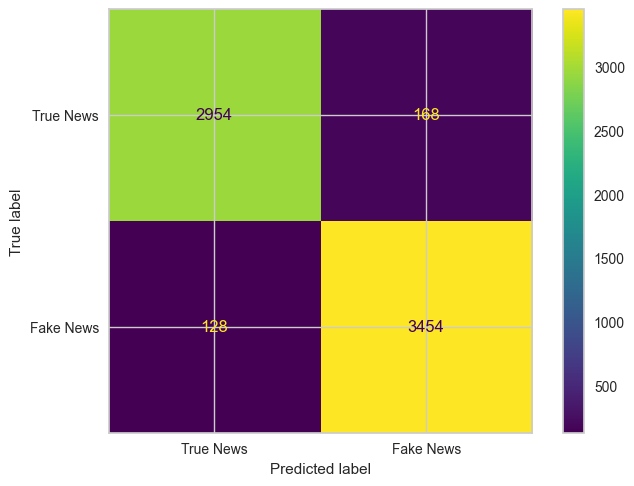

<IPython.core.display.Javascript object>

In [170]:
plt.figure(figsize=(4, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_test, display_labels=classes)
disp.plot()
plt.show()

#### Classification report

In [173]:
classification_report = classification_report(y_true_test, y_test_pred, target_names=classes)
print(classification_report)


              precision    recall  f1-score   support

   True News       0.96      0.95      0.95      3122
   Fake News       0.95      0.96      0.96      3582

    accuracy                           0.96      6704
   macro avg       0.96      0.96      0.96      6704
weighted avg       0.96      0.96      0.96      6704



<IPython.core.display.Javascript object>

It can be observed that predictions on both validation and test datasets generated excellent prediction results with f1 scores equat to 0.99.

### Predicting on new data

In order to observe, how models perform on the new articles uploaded from the internet the following steps were implemented:
1. a text from CNN was saved as a txt file;
2. the file was uploaded to a string, also a string for title was created;
3. a dataframe was created from these strings;
4. stopwords were removed;
5. text and title of the dataframe were vectorized with the function 'vectorize_text()' which uses TfidfVectorizer from sklearn;
6. dictionaries for keys as words and values as vector scores were created;
7. dataframes from dictionaries were created for both text and titles, they were renamed and concatenated into a single dataframe;
8. Columns which correspond with columns in the main dataset were filtered;
9. The dataframe from the article data was concatenated with the main dataset on axis 1.

In [174]:
checkpoint_path = f"models/model_trained_Linear.ckpt"
model = FakeNewsClassifier.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    input_size=len(X.columns),
)


<IPython.core.display.Javascript object>

In [175]:
file_path = "news_article.txt"
new_title = 'Israel expanding ground offensive into central Gaza refugee camps'
with open(file_path, "r", encoding="ISO-8859-1") as file:
    new_text = file.read()


<IPython.core.display.Javascript object>

In [176]:
df = pd.DataFrame({"text": [new_text], "title": [new_title]})

<IPython.core.display.Javascript object>

In [180]:
df["text_no_stopwords"] = df["text"].apply(remove_stopwords)
df["title_no_stopwords"] = df["title"].apply(remove_stopwords)

<IPython.core.display.Javascript object>

In [181]:
denselist_text, feature_names_text = vectorize_text(400, df["text_no_stopwords"])
denselist_title, feature_names_title = vectorize_text(400, df["title_no_stopwords"])

<IPython.core.display.Javascript object>

In [182]:
word_importance_text = {
    word: round(score, 3) for word, score in zip(feature_names_text, denselist_text[0])
}
word_importance_title = {
    word: round(score, 3)
    for word, score in zip(feature_names_title, denselist_title[0])
}

<IPython.core.display.Javascript object>

In [183]:
new_df_text = pd.DataFrame({k: [v] for k, v in word_importance_text.items()})
new_df_title = pd.DataFrame({k: [v] for k, v in word_importance_title.items()})
new_df_text_renamed = rename_columns_add_substring(new_df_text, "text_")
new_df_title_renamed = rename_columns_add_substring(new_df_title, "title_")

new_df = pd.concat([new_df_title_renamed, new_df_text_renamed], axis=1)

common_columns = X.columns.intersection(new_df.columns)
new_df_filtered = new_df[common_columns]
concat_df = pd.concat([X, new_df_filtered], axis=0).fillna(0).reset_index(drop=True)
# concat_df = concat_df.iloc[:, 1:]

<IPython.core.display.Javascript object>

Tensor dataset was created from the vectorized data of the article and an arbitrary y value (just for running predictions, but not used).

In [184]:
new_data_X = concat_df.iloc[-1,:]

new_data_X_tensor = torch.tensor([new_data_X.values], dtype=torch.float32) 
new_data_y_tensor = torch.tensor([1], dtype=torch.float32)  


new_dataset = TensorDataset(new_data_X_tensor, new_data_y_tensor)

new_data_loader = DataLoader(new_dataset, batch_size=32)


<IPython.core.display.Javascript object>

The GPU processor is attached to models, sample weights, and to the eval() function. 


In [185]:
device = torch.device("mps")
model.to(device)
model = model.eval().to(device)


<IPython.core.display.Javascript object>

The data for prediction were run by batches of 32 with data loader, probabilities were generated with the sigmoid function and were interpreted with teh threshhold 0.6 as either 'fake' or 'true'.

In [186]:
start_time = time.time()

with torch.no_grad():
    for batch in new_data_loader:
        inputs = batch[0]
        inputs = inputs.to(device)

        outputs = model(inputs)
        sigmoids = torch.sigmoid(outputs).squeeze(-1)
        preds = (sigmoids > 0.6).to(torch.int)

end_time = time.time()
prediction_time = end_time - start_time
print(f"Prediction time: {prediction_time}")
if preds[0] == 0:
    print(f"The article is predicted as true news by the model.")
else:
    print(f"The article is predicted as fake news by the model.")

Prediction time: 0.17292404174804688
The article is predicted as true news by the model.


<IPython.core.display.Javascript object>

We can observe that the model correctly predicts that the article from CNN is a true news article.

## Conclusions

The project provides the exploratory analysis and training of machine learning and deep learning models for the purpose of classification of news articles - that is, to train classifiers able to predict if news articles are true or fake.

The exploratory analysis (including counting of words, characters, most frequently used stopwords and non-stopwords, sentiment analysis, LDA analysis, wordcloud analysis) revealed that:

- More articles in the fakenews dataframe comparing to the articles in the truenews dataframe have less than 2500 characters in their text. Also, more 'true' articles have less 75 characters (while the majority of 'fake' articles have characters in the range (75 - 90)) in their titles. At the same, the outliers in the fakenews dataframe are more extreme - there are some articles with much larger number of characters than the articles with the largest number of outliers in the truenews dataframe.
- The counting of words comfirmed the same observations which were made by examining counts of characters - more 'fake' articles  have less than 400 words in their text but less 'fake' articles have less than 10 words. Also, articles in the fakenes dataframes have more extreme outliers. 
- No significant differences in the use of stopwords in fakenews and truenews dataframes are observed.
- Articles within the 'fakenews' dataset frequently mention first names of U.S. politicians, such as 'Donald' and 'Hilary'.
- Titles of articles categorized as 'fake' often contain keywords like 'WATCH:' or 'video'. Conversely, the text of 'true' articles commonly includes the keyword 'Reuters'.
 - Articles in the fakenews dataset are quite often written in the first-person style (the pronoun "I" is among the most used words).
 - Unlike the 'fakenews' articles, the titles in the 'truenews' dataset typically do not start with capital letters.
 - Quite a lot of so-called fake articles provide references to twitter comments ar are twitter comments themselves (twitter com is the most frequenty used bigram in the fakenews dataset) or to YouTube videos (next most frequenly used trigrams). 
- Other distinguishing features of fake news articles are frequenly used bigrams 'anti trump', 'pro-trump', 'anti-american' which are either lesser used (ant-trump) or not present ('pro-trump', 'anti-american') among the the most frequenly used bigrams in the articles from the truenews dataset.
- Articles from the truenews dataset are distinguished by frequenly used bigram 'reuters ipsos'.
- The topics in text and titles of articles of the fakenews dataset refer to the US foreign policy (Topic 1, text), police (Topic 2, text), FBI investigation of emails of Hillary Clinton (Topic 3, text), Donald Trump and Hillary Clinton (Topic 4, text; Topic 1, 2, 3, title), Trump (Topic 4, title).
- the topics in text and titles of articles of the truenews dataset refer to varrious issues of the US foreign and domestic policy, and not particularly to personalities or scandals.
- The distributions of polarity scores and sentiment categories in the texts of both fake and real news articles are strikingly similar, with a higher proportion of articles being classified as positive rather than neutral or negative.
- A significantly greater proportion of articles in the 'fakenews' dataset have titles that are either strongly positive or negative compared to those in the 'truenews' dataset. This suggests that a characteristic feature of 'fake' news articles is their use of emotionally charged titles, either positive or negative, to engage and attract the audience.
 - Most frequently used words in text of articles in the fakenews dataset do not have meaningful content (exept such words as Hillary, Clinton and Trump). The most frequently used words in titles are 'video', 'breaking', and 'watch' (which are used to attract attention); words which could refer to ideological divisions (racist, black, liberal,Republican, Democracy); words referring to personalities (Trump, Hillary, Sanders).
 
The modelling part consisted of training 9 machine learning classifiers (RandomForest, AdaBoost, XgBoost, Gradient Boosting, Logistic Regression, Support Vector Machines, Gaussian Naive Bayes, Bagging Classifier, Extra Trees Classifier) and thee deep learning models (a neural network with two linear layers, a pre-trained transformers model Distilbert, the pre-trained transformers model Roberta). By examining the modeling results it can be observed that:
- The modeling used euristic rules:
  - 1. features should be selected by selecting to 100 most frequently used words from text of each dataset and 50 frequently used words from text of each dataset;
  - 2. words causing information leakage such as "video", "watch" in titles of fakenews articles, "via", "featured", "pic", "com", "https", "twitter", "the", "said", says", should be removed;
- classifiers were trained in two ways: 1) by following only the second rule and 2) by following both rules;
- All the machine learning classifiers (both ways) provided excellent prediction results. For the first way the best performance was achieved by the XGboost classifier (f1 score 0.989); the lowest performance was achieved by the Gaussian NB classifier (f1 score 0.91). For the second way the best performance was achieved by the ExtraTree classifier (accuracy score 0.96, f1 score 0.989); the lowest performance was achieved by the Gaussian NB classifier (f1 score 0.86).
- As the training results were surprisingly good, no other hyperparameter tuning or feature selection steps were applied to the models. In fact, few words ('reuters', "video", "watch') had been removed from the dataset after the initial running of the models and exploratory analysis when it was  observed that these words had had decisive impact on the prediction results.
- the feature importance analysis revealed that the most important 10 words which have impact on the classifier (XgBoost classifier) are found in the text of articles: "minister", "image", "pic", "the", "com", "https", "features", "said", "via"; only the word "factbox" among the 10 most important words was found in titles of articles.
- It was observed after conducting the interpretability analysis with LIME of mis-classified news articles that classification of the article as determined mainly not by the presence or by the absence of certain words in the text, with some exceptions. It was assumed that it was one of the reasons of mis-classification of news articles.
- the neural network model with two linear layers, trained with the AdamW optimizer and learning rate 0.001, provided the best performance (f1 score 0.99) on both validation and test datasets.
- the deep learning models which were trained on the basis of pre-trained trasformer models Distilbert preformed very well:
 - Two Distilbert models with different parameters were trained
   1) a model with parameters: learning rate 0.001 (training) 0.0001 (fine-tuning);maximum sequence length was set to 300; training-validation-test split 0.4x0.4x0.2.
     - the trained model performed not well both with validation and test datasets;
     - the fine-tuned model performed quite well both with validation and test dataset (f1 score equal to 0.99 for validation and 1 for test dataset).
   2) a model with parameters: learning rate 0.0001 (training) 0.00001 (fine-tuning);maximum sequence length was set to 128;training-validation-test split 0.7x0.15x0.15.
     - the trained model performed quite well both with validation and test datasets (but only after adjustment of sigmoid threshhold to 0.52 - all probabilites were distributed in the scale from 0.51 to 0.54);
     - the fine-tuned model performed even better both with validation and test dataset (f1 score equal to 1; only 6 articles were misclassified).
- the too good performance of all trained and fine-tuned models indicates that there is still information leakage and the models possibly would not perform well on the new data.

#### Limitations and suggestions for improvement:

##### Limitations:

1. The major limitation of the project is the potentially biased dataset that limits the applicability of trained classifiers in real life situations. According to the definition of fake news from the Cambridge dictionnairy, fake news are "false stories that appear to be news, spread on the internet or using other media, usually created to influence political views or as a joke (https://dictionary.cambridge.org/dictionary/english/fake-news). However, by searching the news article which are included in the dataset as fake news in the internet, it was found that quite a number of these news were from CBS News portals or comments discussing news the news which were published in some portal (USA Today, etc.). Thus, they could not be labeled as fake news by definition. (Maybe that's the reason why the dataset is already removed from the Kaggle).
2. The dataset is collected in the short period in few months of years 2016 and 2017. The content of the news is related with political situation and events of that period of time. Thus, tt is quite possible that the models would not be able to detect fake news in another political context (e.g. fake news spread during the period of the Covid-19 pandemia). 
3. By examining the content of the dataset it was observed that in many cases the text of fakenews has the word combination "Featured image via" which caused the good performance of the classfiers. The words were not removed from the dataset before training the models.

##### Suggestions for improvement:

1. To enrich the dataset with news articles from other political contexts. 
2. To remove the words from the dataset which are specific to not to the content of the text but to the form of the collected data (such as 'Featured image via' present in each article labeled as 'fake news'.)

## References

1. ChatGPT.OpenAI, https://chat.openai.com/
2. Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools, https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
3. Hugging Face, https://huggingface.co/
4. Fake and Real News Dataset, https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
